# Cleaning Data

At this stage, it is important to clean the 100x100data. 

Several issues were highlighted throughout the process.

### # of Finishers
As part of the analysis, DUV and ITRA finishers time were downloaded to verify runner's status and, if lucky, finishing time. 

When comparing the scraped 100x100 data to DUV and ITRA, it came to light that sometimes, runners are marked as finished on 100x100trail, although they did not get a finishers status on ITRA or DUV. THis required cleaning. 

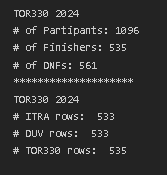

Furthermore, sometimes runners were given a status of not finished. THis was easily fixed by checking their timestamp at finish line (Courmayer). However, in that case, it was made sure that there was a timestamp for them between road Stages

### Life bases / Refugees

Several cleaning methods were deployed to clean this column. There were 'RITIRIO' in some values, so this needed to be stripped and kept in a different column 

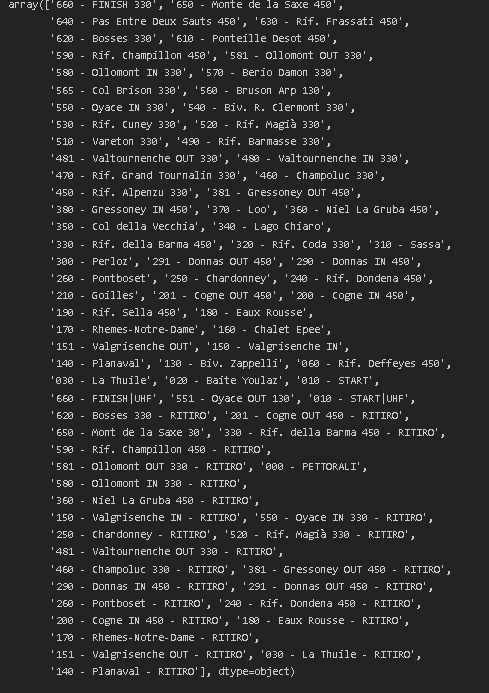


### 'Time' column
'Time' Column is one the most important columns in this process and needs to be meticulously cleaned for errors and inconsitencies!

The timesstamps had '+02:00' which was not necessary once inspected. 
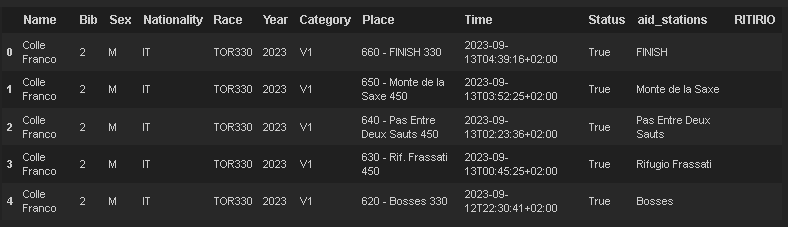


### Starting Time
Starting Times were also inaccurate. The starting time was set random times (who knows why?) but the times were changed to reflect wave start times!
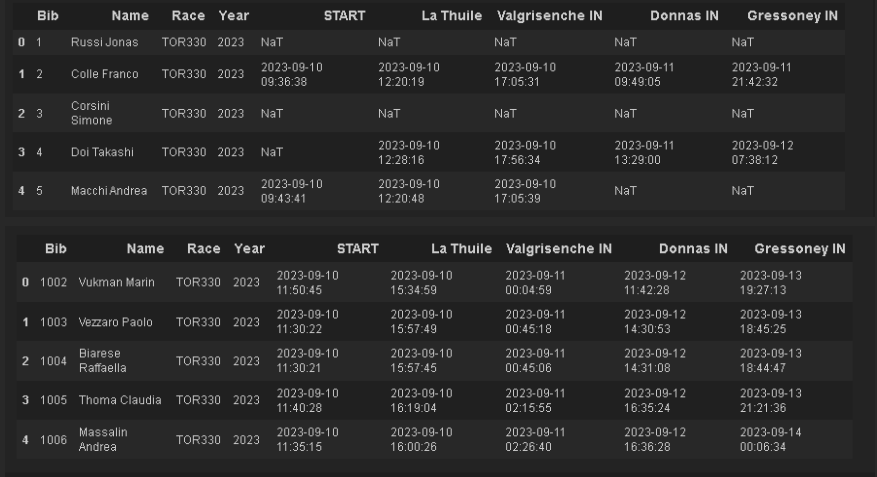

To deal with the Start Time, issue, DUV data was used to detect the start date for each year

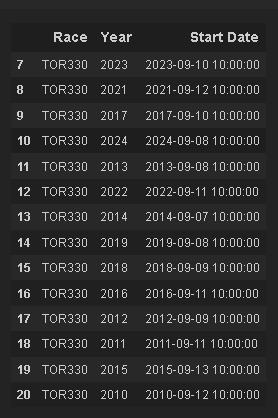

In [1]:
import re
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd
# import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### FIX BARMASSE
### FIX BARMA

In [3]:
# # Set pandas options to display all columns and rows
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.max_rows', None)     # Show all rows

## Looping through scraped data from 100X100trail

In [4]:
races = ['TOR330'
#         ,'TOR450'
        ]
years = [ 
#     '2021',
#         '2022',
         '2023', 
#     '2024'
        ]

TORX_df = {}

for race in races:
    for year in years:
        df = pd.read_excel(f'{race} Data/1. 100x100trail/{race}_{year}.xlsx',
                                 dtype={'Start Date': 'string',
                                        'Year': 'string'})
        print(f'{race}_{year} {df.shape}')
        # Store the DataFrame in the dictionary with a key like 'TOR330_2021'
        TORX_df[f'{race}_{year}'] = df
    print('*'*50),

TOR330_2023 (42964, 10)
**************************************************


In [5]:
TORX_df_concat = pd.concat(TORX_df)

In [6]:
TOR330 = TORX_df_concat[TORX_df_concat['Year'] == year]
TOR330.head()

Name  Bib Sex Nationality    Race  Year Category  \
TOR330_2023 0  Colle Franco    2   M          IT  TOR330  2023       V1   
            1  Colle Franco    2   M          IT  TOR330  2023       V1   
            2  Colle Franco    2   M          IT  TOR330  2023       V1   
            3  Colle Franco    2   M          IT  TOR330  2023       V1   
            4  Colle Franco    2   M          IT  TOR330  2023       V1   

                                        Place                       Time  \
TOR330_2023 0                660 - FINISH 330  2023-09-13T04:39:16+02:00   
            1      650 - Monte de la Saxe 450  2023-09-13T03:52:25+02:00   
            2  640 - Pas Entre Deux Sauts 450  2023-09-13T02:23:36+02:00   
            3         630 - Rif. Frassati 450  2023-09-13T00:45:25+02:00   
            4                620 - Bosses 330  2023-09-12T22:30:41+02:00   

               Status  
TOR330_2023 0    True  
            1    True  
            2    True  
            3    True  
            4    True

In [7]:
def counting_finish_DNF_dataset(df):
    for year in years :
        for race in races:

            if len(df['Name'][(df['Year'] == year) & (df['Race'] == race)].unique()) != 0:
                print(race , year)
                ## The data is currently stacked so every checkpoint has a unique row
                # using the unique function to count unique participants in the data
                print('# of Partipants:', len(df['Name'][(df['Year'] == year) &
                                                        (df['Race'] == race)].unique()))
                
                
                
                # Finishers
                print('# of Finishers:', len(df['Name'][(df['Year'] == year) &
                                                        (df['Race'] == race) &
                                                        (df['Status'] ==  True)].unique()))
                # DNFs
                print('# of DNFs:', len(df['Name'][(df['Year'] == year) &
                                                        (df['Race'] == race) &
                                                        (df['Status'] ==  False)].unique()))
                print('*'*20)
            else:
                pass
            
counting_finish_DNF_dataset(TOR330)

TOR330 2023
# of Partipants: 1206
# of Finishers: 630
# of DNFs: 576
********************


In [8]:
def counting_groupby_dataset(df, column):
    for year in years :
        for race in races:
            
            df = df[['Name', 'Status', 'Year', 'Race']].drop_duplicates()

            if len(df['Name'][(df['Year'] == year) & (df['Race'] == race)].unique()) != 0:
                print(race , year)
                ## The data is currently stacked so every checkpoint has a unique row
                # using the unique function to count unique participants in the data
                print('# of Partipants:', len(df['Name'][(df['Year'] == year) &
                                                        (df['Race'] == race)].unique()), '\n')
                
                print(df.groupby([column])[column].count())
                print('*'*20)
            else:
                pass
counting_groupby_dataset(df,  'Status')

TOR330 2023
# of Partipants: 1206 

Status
False    576
True     630
Name: Status, dtype: int64
********************


### DUV and ITRA data


#### # of Finishers
As part of the analysis, DUV and ITRA finishers time were downloaded to verify runner's status and, if lucky, finishing time. 

When comparing the scraped 100x100 data to DUV and ITRA, it came to light that sometimes, runners are marked as finished on 100x100trail, although they did not get a finishers status on ITRA or DUV. THis required cleaning. 

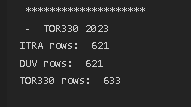


In [9]:
TORX_duv_df = pd.read_excel(f'{race} data/5. Clean Data for Data Visualisation/{race}_duv.xlsx',
                                     dtype={'Year': 'string'})

TORX_itra_no_DNF = pd.read_excel(f'{race} Data/5. Clean Data for Data Visualisation/{race}_itra_no_DNF.xlsx',
                                     dtype={'Year': 'string'})

In [10]:
def find_out_the_rows_difference_between_datasets(df):
    for year in years :
        for race in races:
            if len(df['Name'][(df['Year'] == year)]) != 0:

                print(race, year)
                print('# ITRA rows: ', TORX_itra_no_DNF[(TORX_itra_no_DNF['Year'] == year) &
                                  (TORX_itra_no_DNF['Race'] == race)].shape[0])
                print('# DUV rows: ',TORX_duv_df[(TORX_duv_df['Year'] == year) &
                                  (TORX_duv_df['Race'] == race)].shape[0])

                print('# TOR330 rows: ', len(df['Name'][(df['Year'] == year) &
                                                 (df['Race'] == race) &
                                                 (df['Status'] == True)].unique()))
                print('\n', '*'*20)
                
                if year == '2022':
                    print(' - ','TOR330','2022')
                    print(TORX_itra_no_DNF[(TORX_itra_no_DNF['Race'] == 'TOR330') &
                          (TORX_itra_no_DNF['Year'] == '2022')].groupby(['Status'])['Status'].count())
                    print('\n', '*'*20)
            else: 
                pass

In [11]:
counting_finish_DNF_dataset(TOR330)
find_out_the_rows_difference_between_datasets(TOR330)
counting_groupby_dataset(TOR330,  'Status')

TOR330 2023
# of Partipants: 1206
# of Finishers: 630
# of DNFs: 576
********************
TOR330 2023
# ITRA rows:  621
# DUV rows:  621
# TOR330 rows:  630

 ********************
TOR330 2023
# of Partipants: 1206 

Status
False    576
True     630
Name: Status, dtype: int64
********************


### Cleaning Place column

In [12]:
TOR330['Place'].unique()

array(['660 - FINISH 330', '650 - Monte de la Saxe 450',
       '640 - Pas Entre Deux Sauts 450', '630 - Rif. Frassati 450',
       '620 - Bosses 330', '610 - Ponteille Desot 450',
       '590 - Rif. Champillon 450', '581 - Ollomont OUT 330',
       '580 - Ollomont IN 330', '570 - Berio Damon 330',
       '565 - Col Brison 330', '551 - Oyace OUT 330',
       '550 - Oyace IN 330', '540 - Biv. R. Clermont 330',
       '530 - Rif. Cuney 330', '520 - Rif. Magià 330',
       '490 - Rif. Barmasse 330', '481 - Valtournenche OUT 330',
       '480 - Valtournenche IN 330', '470 - Rif. Grand Tournalin 330',
       '460 - Champoluc 330', '450 - Rif. Alpenzu 330',
       '381 - Gressoney OUT 330', '380 - Gressoney IN 330', '370 - Loo',
       '360 - Niel La Gruba 450', '350 - Col della Vecchia',
       '340 - Lago Chiaro', '330 - Rif. della Barma 450',
       '320 - Rif. Coda 450', '310 - Sassa', '300 - Perloz',
       '291 - Donnas OUT 450', '290 - Donnas IN 330', '260 - Pontboset',
       '250 - 

In [13]:
# 030 - La Thuile - RITIRO
TOR330['aid_stations'] = TOR330['Place'].str.split(r'^\d+ - ').str.get(-1)
TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('Rif. della Balm 450a','Rif. della Barma')
TOR330['aid_stations'] = TOR330['aid_stations'].str.replace(r'\d+', '', regex=True)
TOR330['aid_stations'] = TOR330['aid_stations'].str.split('|').str.get(0)
TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('Rif.', 'Rifugio')
TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('Biv.','Bivacco')
TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('Niel - ','Niel ')
TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('Oyace IN','Oyace')
TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('  ',' ')
TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('Mont de la Saxe','Monte de la Saxe')
TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('Rifugio della Barmasse', 'Rifugio Barmasse')
TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('Promoud','Bivacco Zappelli')
TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('FINISH - UHF','FINISH')
TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('START - MANUAL','START')
TOR330['aid_stations'] = TOR330['aid_stations'].str.strip()
TOR330['RITIRIO'] = np.where(
    TOR330['aid_stations'].str.contains('RITIRO', na=False), 
    TOR330['aid_stations'],  '')
# TOR330['RITIRIO] =TOR330['RITIRIO].str.replace('- RITIRO', '')
TOR330['aid_stations'] = TOR330['aid_stations'].str.split(' - RITIRO').str.get(0)

TOR330 = TOR330[~(TOR330['aid_stations'] == '') ]
print(', '.join(list(TOR330['aid_stations'].unique())))


C:\Users\Karina\AppData\Local\Temp\ipykernel_7752\502743564.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('Rif. della Balm 450a','Rif. della Barma')
C:\Users\Karina\AppData\Local\Temp\ipykernel_7752\502743564.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('Rif.', 'Rifugio')
C:\Users\Karina\AppData\Local\Temp\ipykernel_7752\502743564.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('Biv.','Bivacco')


FINISH, Monte de la Saxe, Pas Entre Deux Sauts, Rifugio Frassati, Bosses, Ponteille Desot, Rifugio Champillon, Ollomont OUT, Ollomont IN, Berio Damon, Col Brison, Oyace OUT, Oyace, Bivacco R. Clermont, Rifugio Cuney, Rifugio Magià, Rifugio Barmasse, Valtournenche OUT, Valtournenche IN, Rifugio Grand Tournalin, Champoluc, Rifugio Alpenzu, Gressoney OUT, Gressoney IN, Loo, Niel La Gruba, Col della Vecchia, Lago Chiaro, Rifugio della Barma, Rifugio Coda, Sassa, Perloz, Donnas OUT, Donnas IN, Pontboset, Chardonney, Rifugio Dondena, Goilles, Cogne OUT, Cogne IN, Rifugio Sella, Eaux Rousse, Rhemes-Notre-Dame, Chalet Epee, Valgrisenche OUT, Valgrisenche IN, Planaval, Bivacco Zappelli, Rifugio Deffeyes, La Thuile, Baite Youlaz, START, PETTORALI, Parco Bollino, Bruson Arp, Vareton, Rifugio Miserin


In [14]:
# copy the column to make a new column
for i in list(TOR330['RITIRIO'].unique()):
    print(i)


Donnas IN - RITIRO
Rifugio Magià - RITIRO
Donnas OUT - RITIRO
Gressoney OUT - RITIRO
Ollomont OUT - RITIRO
Ollomont IN - RITIRO
Lago Chiaro - RITIRO
Oyace - RITIRO
Valtournenche OUT - RITIRO
Champoluc - RITIRO
Sassa - RITIRO
Rifugio della Barma - RITIRO
Gressoney IN - RITIRO
Niel La Gruba - RITIRO
Col della Vecchia - RITIRO
Chardonney - RITIRO
Valgrisenche OUT - RITIRO
Rifugio Dondena - RITIRO
Goilles - RITIRO
Cogne OUT - RITIRO
Cogne IN - RITIRO
Rifugio Sella - RITIRO
Eaux Rousse - RITIRO
Rhemes-Notre-Dame - RITIRO
Chalet Epee - RITIRO
Valgrisenche IN - RITIRO
La Thuile - RITIRO
Baite Youlaz - RITIRO


### Cleaning Time column

Column '2024-09-11T07:08:32+02:00' needs to be fixed into '2024-09-11 07:08:32' and turned into the datetime

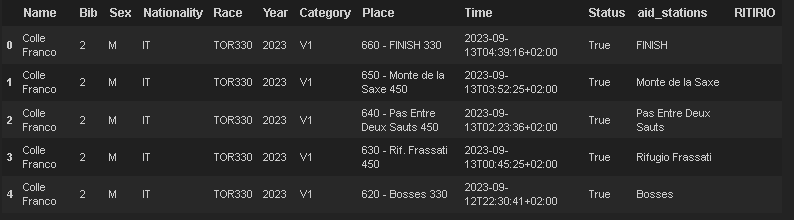

In [15]:
# 2024-09-11T07:08:32+02:00

# Split the 'Time' column to remove the timezone offset
TOR330['new_Time'] = TOR330['Time'].str.split('+').str[0]

# Convert the cleaned time string to a datetime object
TOR330['new_Time'] = pd.to_datetime(TOR330['new_Time'])

# # Add the 2-hour offset using timedelta
# # NO NEED!!!
# TOR330['new_Time'] = TOR330['new_Time'] + pd.to_timedelta('02:00:00')

# Preview the DataFrame
TOR330.head()

Name  Bib Sex Nationality    Race  Year Category  \
TOR330_2023 0  Colle Franco    2   M          IT  TOR330  2023       V1   
            1  Colle Franco    2   M          IT  TOR330  2023       V1   
            2  Colle Franco    2   M          IT  TOR330  2023       V1   
            3  Colle Franco    2   M          IT  TOR330  2023       V1   
            4  Colle Franco    2   M          IT  TOR330  2023       V1   

                                        Place                       Time  \
TOR330_2023 0                660 - FINISH 330  2023-09-13T04:39:16+02:00   
            1      650 - Monte de la Saxe 450  2023-09-13T03:52:25+02:00   
            2  640 - Pas Entre Deux Sauts 450  2023-09-13T02:23:36+02:00   
            3         630 - Rif. Frassati 450  2023-09-13T00:45:25+02:00   
            4                620 - Bosses 330  2023-09-12T22:30:41+02:00   

               Status          aid_stations RITIRIO            new_Time  
TOR330_2023 0    True                FINISH         2023-09-13 04:39:16  
            1    True      Monte de la Saxe         2023-09-13 03:52:25  
            2    True  Pas Entre Deux Sauts         2023-09-13 02:23:36  
            3    True      Rifugio Frassati         2023-09-13 00:45:25  
            4    True                Bosses         2023-09-12 22:30:41

In [16]:
for i in TOR330.aid_stations.unique():
    print(i)

FINISH
Monte de la Saxe
Pas Entre Deux Sauts
Rifugio Frassati
Bosses
Ponteille Desot
Rifugio Champillon
Ollomont OUT
Ollomont IN
Berio Damon
Col Brison
Oyace OUT
Oyace
Bivacco R. Clermont
Rifugio Cuney
Rifugio Magià
Rifugio Barmasse
Valtournenche OUT
Valtournenche IN
Rifugio Grand Tournalin
Champoluc
Rifugio Alpenzu
Gressoney OUT
Gressoney IN
Loo
Niel La Gruba
Col della Vecchia
Lago Chiaro
Rifugio della Barma
Rifugio Coda
Sassa
Perloz
Donnas OUT
Donnas IN
Pontboset
Chardonney
Rifugio Dondena
Goilles
Cogne OUT
Cogne IN
Rifugio Sella
Eaux Rousse
Rhemes-Notre-Dame
Chalet Epee
Valgrisenche OUT
Valgrisenche IN
Planaval
Bivacco Zappelli
Rifugio Deffeyes
La Thuile
Baite Youlaz
START
PETTORALI
Parco Bollino
Bruson Arp
Vareton
Rifugio Miserin


### PIVOTING the Dataset

In [17]:
# Pivot the data so that each participant has its own column
pivoted_TOR330 = TOR330.pivot_table(
    index=['Name','Bib', 'Sex', 
           'Nationality', 'Category', 'Race','Year', 'Status' , #'RITIRIO'
          ],
    columns='aid_stations',  
    values='new_Time',
    aggfunc='first'  # Ensures only the first match is kept in case of duplicates
).reset_index()


# pivoted_TOR330 = pivoted_TOR330.sort_values(by = 'Bib', ascending = True)
pivoted_TOR330.head()

aid_stations,Name,Bib,Sex,Nationality,Category,Race,Year,Status,Baite Youlaz,Berio Damon,...,Rifugio Miserin,Rifugio Sella,Rifugio della Barma,START,Sassa,Valgrisenche IN,Valgrisenche OUT,Valtournenche IN,Valtournenche OUT,Vareton
0,Abe Takashi,443,M,JP,V1,TOR330,2023,True,2023-09-10 12:32:30,2023-09-15 12:13:32,...,NaT,2023-09-11 17:49:52,2023-09-13 03:14:01,NaT,2023-09-12 20:07:44,2023-09-10 22:29:16,2023-09-11 01:27:00,2023-09-14 11:20:43,2023-09-14 16:38:25,2023-09-14 19:55:33
1,Acerbi Luca,1290,M,IT,V3,TOR330,2023,False,2023-09-10 15:26:07,NaT,...,NaT,NaT,NaT,2023-09-10 11:22:44,NaT,2023-09-11 04:16:59,NaT,NaT,NaT,NaT
2,Acerbi Maria Luisa,1234,F,IT,SEN,TOR330,2023,False,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,Adamczyk Guillaume,1215,M,BE,V2,TOR330,2023,False,2023-09-10 15:30:04,NaT,...,NaT,NaT,NaT,2023-09-10 11:50:58,NaT,2023-09-11 06:20:04,NaT,NaT,NaT,NaT
4,Affre Roxane,1320,F,FR,V2,TOR330,2023,False,2023-09-10 16:00:38,NaT,...,NaT,NaT,NaT,2023-09-10 11:19:55,NaT,2023-09-11 06:25:00,NaT,NaT,NaT,NaT


In [18]:
print(pivoted_TOR330.shape)
print(pivoted_TOR330.groupby(['Status'])['Status'].count())

(1206, 65)
Status
False    576
True     630
Name: Status, dtype: int64


In [19]:
pivoted_TOR330.columns

Index(['Name', 'Bib', 'Sex', 'Nationality', 'Category', 'Race', 'Year',
       'Status', 'Baite Youlaz', 'Berio Damon', 'Bivacco R. Clermont',
       'Bivacco Zappelli', 'Bosses', 'Bruson Arp', 'Chalet Epee', 'Champoluc',
       'Chardonney', 'Cogne IN', 'Cogne OUT', 'Col Brison',
       'Col della Vecchia', 'Donnas IN', 'Donnas OUT', 'Eaux Rousse', 'FINISH',
       'Goilles', 'Gressoney IN', 'Gressoney OUT', 'La Thuile', 'Lago Chiaro',
       'Loo', 'Monte de la Saxe', 'Niel La Gruba', 'Ollomont IN',
       'Ollomont OUT', 'Oyace', 'Oyace OUT', 'PETTORALI', 'Parco Bollino',
       'Pas Entre Deux Sauts', 'Perloz', 'Planaval', 'Pontboset',
       'Ponteille Desot', 'Rhemes-Notre-Dame', 'Rifugio Alpenzu',
       'Rifugio Barmasse', 'Rifugio Champillon', 'Rifugio Coda',
       'Rifugio Cuney', 'Rifugio Deffeyes', 'Rifugio Dondena',
       'Rifugio Frassati', 'Rifugio Grand Tournalin', 'Rifugio Magià',
       'Rifugio Miserin', 'Rifugio Sella', 'Rifugio della Barma', 'START',
       'Sass

In [20]:
# reordering columns 
pivoted_TOR330 = pivoted_TOR330[[
'Name', 'Bib', 'Sex', 'Nationality', 'Year', 'Race','Category', 'Status', #'RITIRIO',  
'START', 'Baite Youlaz', 'La Thuile', 'Rifugio Deffeyes', 
    # 'Bivacco Zappelli', 'Col Brison', 'Berio Damon' # Dropping these because its not very useful anyway!
    'Planaval', 'Valgrisenche IN', 'Valgrisenche OUT', 'Chalet Epee', 'Rhemes-Notre-Dame',
    'Eaux Rousse', 'Rifugio Sella', 'Cogne IN', 'Cogne OUT', 'Goilles', 'Rifugio Dondena', 
    'Chardonney', 'Pontboset', 'Donnas IN', 'Donnas OUT', 'Perloz', 'Sassa', 'Rifugio Coda',
    'Rifugio della Barma', 'Lago Chiaro', 'Col della Vecchia', 'Niel La Gruba', 'Loo',
    'Gressoney IN', 'Gressoney OUT', 'Rifugio Alpenzu', 'Champoluc', 'Rifugio Grand Tournalin', 
    'Valtournenche IN', 'Valtournenche OUT', 'Rifugio Barmasse', 'Vareton',
    'Rifugio Magià', 'Rifugio Cuney', 'Bivacco R. Clermont', 
    'Oyace', 'Bruson Arp',   'Ollomont IN', 
    'Ollomont OUT', 'Rifugio Champillon', 'Ponteille Desot', 'Bosses', 'Rifugio Frassati', 
    'Pas Entre Deux Sauts', 'Monte de la Saxe', 'FINISH']]

pivoted_TOR330 = pivoted_TOR330.sort_values(by = 'Bib', ascending = True)
pivoted_TOR330.head()

aid_stations,Name,Bib,Sex,Nationality,Year,Race,Category,Status,START,Baite Youlaz,...,Bruson Arp,Ollomont IN,Ollomont OUT,Rifugio Champillon,Ponteille Desot,Bosses,Rifugio Frassati,Pas Entre Deux Sauts,Monte de la Saxe,FINISH
955,Russi Jonas,1,M,CH,2023,TOR330,SEN,False,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
224,Colle Franco,2,M,IT,2023,TOR330,V1,True,2023-09-10 09:36:38,2023-09-10 11:48:06,...,NaT,2023-09-12 17:57:48,2023-09-12 17:57:55,2023-09-12 19:36:02,2023-09-12 21:04:38,2023-09-12 22:30:41,2023-09-13 00:45:25,2023-09-13 02:23:36,2023-09-13 03:52:25,2023-09-13 04:39:16
243,Corsini Simone,3,M,IT,2023,TOR330,SEN,False,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
306,Doi Takashi,4,M,JP,2023,TOR330,V1,True,NaT,2023-09-10 11:54:54,...,2023-09-13 10:05:36,2023-09-13 12:01:36,2023-09-13 12:25:30,2023-09-13 14:39:25,2023-09-13 16:25:39,2023-09-13 18:06:33,2023-09-13 21:18:38,2023-09-13 23:50:12,2023-09-14 01:28:34,2023-09-14 02:20:44
634,Macchi Andrea,5,M,IT,2023,TOR330,SEN,False,2023-09-10 09:43:41,2023-09-10 11:47:59,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [21]:
print(pivoted_TOR330.shape)
print(pivoted_TOR330.groupby(['Status'])['Status'].count())

(1206, 58)
Status
False    576
True     630
Name: Status, dtype: int64


### RITIRIO

Although every attempt was tried to include RITIRIO column in the dataset, it came to light that some people were twice marked retired. 

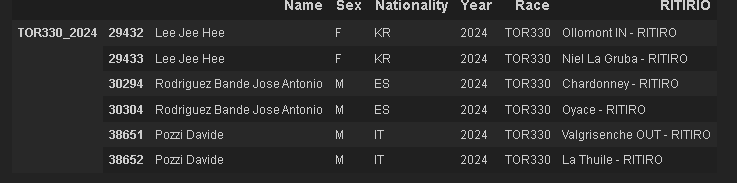

#### Solution
Do nothing. Dont reattach it to the pivoted dataset. It is useless anyway. Only 140 runners were marked as retired, very far from the DNF number.  

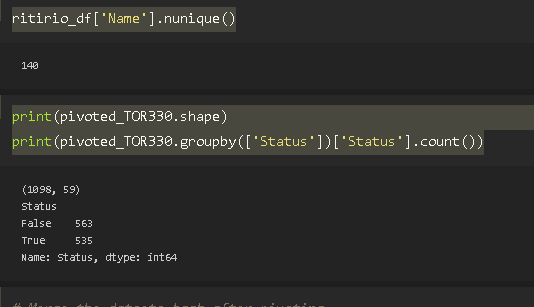

In [22]:
ritirio_df = TOR330[~(TOR330['RITIRIO'] == '')]
# ritirio_df = ritirio_df[['Bib', 'RITIRIO']]
ritirio_df.head()

Name   Bib Sex Nationality    Race  Year  \
TOR330_2023 73            Verjee Sabrina    48   F          GB  TOR330  2023   
            2381          Brumana Andrea    62   M          IT  TOR330  2023   
            7267      Hartmuth Katharina   665   F          CH  TOR330  2023   
            8901          Smith Jonathan  1321   M          AU  TOR330  2023   
            32389  Houteer Magni Justine   275   F          FR  TOR330  2023   

                  Category                             Place  \
TOR330_2023 73          V1      290 - Donnas IN 330 - RITIRO   
            2381        V1     520 - Rif. Magià 330 - RITIRO   
            7267       SEN      290 - Donnas IN 330 - RITIRO   
            8901        V2     291 - Donnas OUT 450 - RITIRO   
            32389       V1  381 - Gressoney OUT 330 - RITIRO   

                                        Time  Status   aid_stations  \
TOR330_2023 73     2023-09-11T14:00:51+02:00    True      Donnas IN   
            2381   2023-09-13T10:28:07+02:00    True  Rifugio Magià   
            7267   2023-09-11T14:00:58+02:00    True      Donnas IN   
            8901   2023-09-12T17:18:56+02:00    True     Donnas OUT   
            32389  2023-09-14T01:33:04+02:00    True  Gressoney OUT   

                                  RITIRIO            new_Time  
TOR330_2023 73         Donnas IN - RITIRO 2023-09-11 14:00:51  
            2381   Rifugio Magià - RITIRO 2023-09-13 10:28:07  
            7267       Donnas IN - RITIRO 2023-09-11 14:00:58  
            8901      Donnas OUT - RITIRO 2023-09-12 17:18:56  
            32389  Gressoney OUT - RITIRO 2023-09-14 01:33:04

In [23]:
# Get a list of duplicate names
duplicate_list = ritirio_df['Name'][ritirio_df['Name'].duplicated()].unique()

# Filter the DataFrame to only rows where 'Name' is in the duplicate list
duplicates_in_dataframe = ritirio_df[ritirio_df['Name'].isin(duplicate_list)]

# Display or process the result
duplicates_in_dataframe[['Name', 'Sex', 'Nationality', 'Year', 'Race', 'RITIRIO' ]]


Name Sex Nationality  Year    Race  \
TOR330_2023 36474    Nakajima Mizue   F          JP  2023  TOR330   
            36475    Nakajima Mizue   F          JP  2023  TOR330   
            36667       Brun Fabien   M          FR  2023  TOR330   
            36668       Brun Fabien   M          FR  2023  TOR330   
            36775  Higuchi Hiroyuki   M          JP  2023  TOR330   
            36776  Higuchi Hiroyuki   M          JP  2023  TOR330   

                                        RITIRIO  
TOR330_2023 36474        Gressoney OUT - RITIRO  
            36475                Sassa - RITIRO  
            36667        Gressoney OUT - RITIRO  
            36668  Rifugio della Barma - RITIRO  
            36775        Gressoney OUT - RITIRO  
            36776  Rifugio della Barma - RITIRO

In [24]:
ritirio_df['Name'].nunique()

132

In [25]:
print(pivoted_TOR330.shape)
print(pivoted_TOR330.groupby(['Status'])['Status'].count())

(1206, 58)
Status
False    576
True     630
Name: Status, dtype: int64


In [26]:
# # Merge the datsets back after pivoting
# pivoted_TOR330 = pivoted_TOR330.merge(
#     ritirio_df[['Bib', 'RITIRIO']].drop_duplicates(),  # Ensure no duplicates in 'Bib' and 'RITIRIO'
#     on='Bib',
#     how='left'
# )

In [27]:
print(pivoted_TOR330.shape)
print(pivoted_TOR330.groupby(['Status'])['Status'].count())

(1206, 58)
Status
False    576
True     630
Name: Status, dtype: int64


### Dealing with Anomalies

Several anomalies were spotted with the finish times. 

Some runners had a timestamp at the finish line, yet failed to be scanned Ollomont IN or OUT or any other refugee or checkpoints on the last stage. 


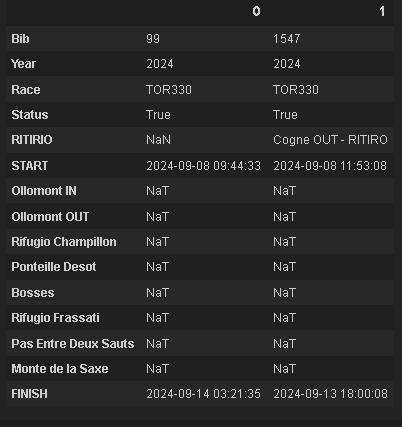

SOLUTION: change their status to FALSE and remove the timestamp

### 2023 Solution
9 participants were incorrectly labelled as finished!
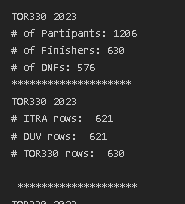

8 participants were identified as labelled finished and had a finish time but missed all stage 7 checkpoints
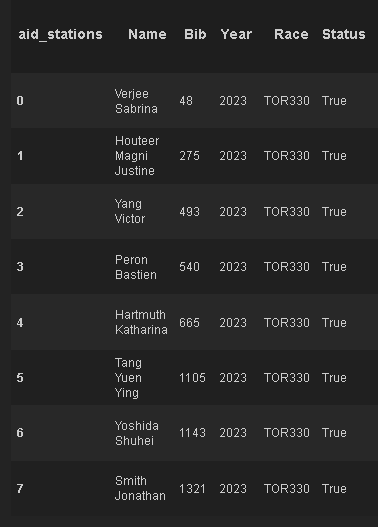



### 2024 Solution

In [28]:
# Looking for runners who have FINISHED< BUT have missing values for all last 3 checkpoints!
anomalies_df = pivoted_TOR330[(pivoted_TOR330['Status'] == True) &
               (pivoted_TOR330['Bosses'].isna()) &                
               (pivoted_TOR330['Rifugio Frassati'].isna()) & 
               (pivoted_TOR330['Pas Entre Deux Sauts'].isna()) &
               (pivoted_TOR330['Monte de la Saxe'].isna())]

anomalies_df[[ 'Name', 'Bib', 'Year', 'Race', 'Status',  'START',
    	'Ollomont IN',	'Ollomont OUT',
    'Rifugio Champillon', 'Ponteille Desot',
    'Bosses',	'Rifugio Frassati',	'Pas Entre Deux Sauts',	'Monte de la Saxe',
    'FINISH']].reset_index(drop = True)

### Conclusion: Easily visible that there are several other places that have missing values 

aid_stations,Name,Bib,Year,Race,Status,START,Ollomont IN,Ollomont OUT,Rifugio Champillon,Ponteille Desot,Bosses,Rifugio Frassati,Pas Entre Deux Sauts,Monte de la Saxe,FINISH
0,Verjee Sabrina,48,2023,TOR330,True,2023-09-10 09:33:01,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2023-09-13 05:38:22
1,Houteer Magni Justine,275,2023,TOR330,True,2023-09-10 09:20:29,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2023-09-16 14:12:20
2,Yang Victor,493,2023,TOR330,True,2023-09-10 09:49:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2023-09-14 00:08:44
3,Peron Bastien,540,2023,TOR330,True,2023-09-10 09:32:59,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2023-09-13 20:12:12
4,Hartmuth Katharina,665,2023,TOR330,True,2023-09-10 09:27:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2023-09-15 08:58:31
5,Tang Yuen Ying,1105,2023,TOR330,True,2023-09-10 11:52:42,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2023-09-14 17:35:33
6,Yoshida Shuhei,1143,2023,TOR330,True,2023-09-10 11:39:57,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2023-09-16 17:07:25
7,Smith Jonathan,1321,2023,TOR330,True,2023-09-10 11:23:04,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2023-09-15 13:59:51


In [29]:
# EXECUTING SOLUTION
for name in anomalies_df['Name'].unique():  

    # Fixing the code with .loc[] for proper assignment
    pivoted_TOR330.loc[pivoted_TOR330['Name'] == name, 'FINISH'] = pd.NaT
    pivoted_TOR330.loc[pivoted_TOR330['Name'] == name, 'Status'] = False

In [30]:
# Looking for runners who have FINISHED< BUT dont haave a finish time!
anomalies_df = pivoted_TOR330[((pivoted_TOR330['Status'] == True) 
#                               &(pivoted_TOR330['FINISH'] == pd.NaT) 
                              )&
                              
                              (
                                  (pivoted_TOR330['Bosses'].isna()) |                
               (pivoted_TOR330['Rifugio Frassati'].isna()) | 
               (pivoted_TOR330['Pas Entre Deux Sauts'].isna()) |
               (pivoted_TOR330['Monte de la Saxe'].isna())
                              )]

anomalies_df[[ 'Name', 'Bib', 'Year', 'Race', 'Status',  'START',
    	'Ollomont IN',	'Ollomont OUT',
    'Rifugio Champillon', 'Ponteille Desot',
    'Bosses',	'Rifugio Frassati',	'Pas Entre Deux Sauts',	'Monte de la Saxe',
    'FINISH']]

### Conclusion: Easily visible that there are several other places that have missing values 

aid_stations,Name,Bib,Year,Race,Status,START,Ollomont IN,Ollomont OUT,Rifugio Champillon,Ponteille Desot,Bosses,Rifugio Frassati,Pas Entre Deux Sauts,Monte de la Saxe,FINISH
80,Bertrand Ludovic,190,2023,TOR330,True,2023-09-10 09:27:13,2023-09-15 16:49:39,2023-09-15 18:58:30,2023-09-15 21:26:58,2023-09-16 01:12:28,2023-09-16 04:49:52,2023-09-16 08:32:26,NaT,2023-09-16 14:57:31,2023-09-16 15:50:53
882,Pupier Samuel,310,2023,TOR330,True,2023-09-10 09:26:21,2023-09-15 14:58:35,2023-09-15 17:24:12,2023-09-15 19:36:02,2023-09-15 23:11:20,2023-09-16 02:54:04,NaT,2023-09-16 10:13:44,2023-09-16 12:29:40,2023-09-16 13:55:31
807,Parra Hernandez Vicente ( Tito),658,2023,TOR330,True,2023-09-10 09:24:35,2023-09-13 17:39:03,2023-09-13 18:24:25,2023-09-13 20:12:45,2023-09-13 22:22:38,2023-09-14 00:35:51,2023-09-14 03:46:25,2023-09-14 07:16:29,NaT,2023-09-14 09:26:12
29,Arnus Matej,1023,2023,TOR330,True,2023-09-10 11:50:16,2023-09-15 18:25:45,2023-09-15 20:51:57,NaT,2023-09-16 02:26:03,2023-09-16 05:49:02,2023-09-16 10:06:33,NaT,2023-09-16 15:26:22,2023-09-16 16:52:17
708,Mondin Placido,1155,2023,TOR330,True,2023-09-10 11:22:22,2023-09-15 18:38:55,2023-09-15 20:07:43,NaT,2023-09-16 03:40:47,2023-09-16 06:41:41,2023-09-16 10:11:26,NaT,2023-09-16 17:06:09,2023-09-16 20:05:50
1011,Slobodzian Fabien,1170,2023,TOR330,True,2023-09-10 11:29:39,2023-09-15 15:57:01,NaT,2023-09-15 19:59:07,2023-09-15 23:11:28,2023-09-16 03:31:01,2023-09-16 09:13:30,NaT,2023-09-16 15:19:13,2023-09-16 17:03:30
1059,Tanaka Yoshikazu,1219,2023,TOR330,True,2023-09-10 11:29:37,2023-09-15 17:23:46,2023-09-15 20:28:03,NaT,2023-09-16 02:57:20,2023-09-16 05:35:45,2023-09-16 09:09:39,NaT,2023-09-16 14:43:13,2023-09-16 16:13:06
206,Cheung Ming Fung,1311,2023,TOR330,True,NaT,2023-09-15 18:50:14,2023-09-15 20:53:50,NaT,2023-09-16 02:00:11,2023-09-16 04:36:26,2023-09-16 09:22:07,NaT,2023-09-16 14:31:01,2023-09-16 15:26:37
441,Gostan Bojana,1469,2023,TOR330,True,2023-09-10 11:50:16,2023-09-15 18:25:43,2023-09-15 20:52:03,NaT,2023-09-16 02:25:54,2023-09-16 05:49:24,2023-09-16 10:06:29,NaT,2023-09-16 15:26:26,2023-09-16 16:52:07
1170,Wu Yihua,1514,2023,TOR330,True,2023-09-10 11:37:48,2023-09-15 03:40:06,2023-09-15 07:19:56,2023-09-15 09:07:56,2023-09-15 11:23:57,2023-09-15 13:14:06,2023-09-15 17:01:51,2023-09-15 19:15:45,NaT,2023-09-15 22:12:44


In [31]:
counting_finish_DNF_dataset(pivoted_TOR330)
find_out_the_rows_difference_between_datasets(pivoted_TOR330)
counting_groupby_dataset(pivoted_TOR330,  'Status')

TOR330 2023
# of Partipants: 1206
# of Finishers: 622
# of DNFs: 584
********************
TOR330 2023
# ITRA rows:  621
# DUV rows:  621
# TOR330 rows:  622

 ********************
TOR330 2023
# of Partipants: 1206 

Status
False    584
True     622
Name: Status, dtype: int64
********************


### Start Line Issues

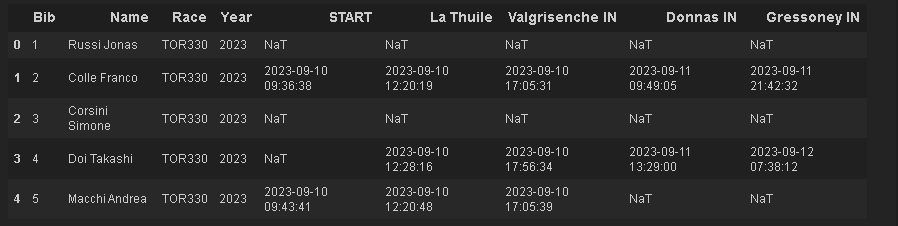

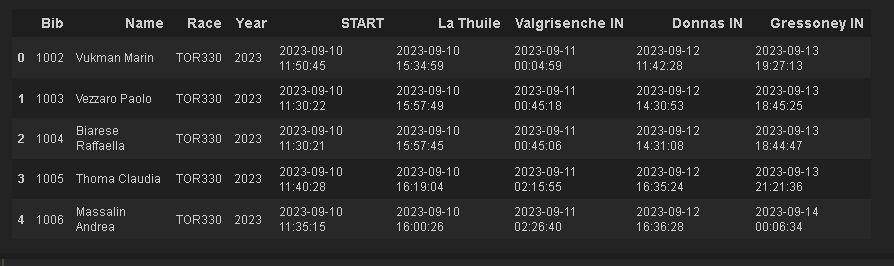

START times are all over the place and this is a MAJOR issue! 
It is important because if the start is not cleaned, it will affet the race finishing time and all the durations in between. 


#### SOLUTION
1) Made a new TIME column from DUV dates

2) added start times based on the wave (based on the bib)

##### Reading in TORX dates extracted from DUV

In [32]:
file = f'TORX DUV dates/TORX_duv_dates_df.xlsx'
dates_duv_df = pd.read_excel(file)

# Drop the intermediate columns if they're no longer needed
dates_duv_df = dates_duv_df.drop(columns=['Day_of_Week Start_Date'])    
dates_duv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Race        26 non-null     object        
 1   Year        26 non-null     int64         
 2   Start Date  26 non-null     datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 752.0+ bytes


In [33]:
dates_duv_df[dates_duv_df['Race'] =='TOR330']

,Race,Year,Start Date
7,TOR330,2023,2023-09-10 10:00:00
8,TOR330,2021,2021-09-12 10:00:00
9,TOR330,2017,2017-09-10 10:00:00
10,TOR330,2024,2024-09-08 10:00:00
11,TOR330,2013,2013-09-08 10:00:00
12,TOR330,2022,2022-09-11 10:00:00
13,TOR330,2014,2014-09-07 10:00:00
14,TOR330,2019,2019-09-08 10:00:00
15,TOR330,2018,2018-09-09 10:00:00
16,TOR330,2016,2016-09-11 10:00:00


### Adding dates into TOR330

In [34]:
# making sure both columns are years!
pivoted_TOR330['Year'] = pivoted_TOR330['Year'].astype('str')
dates_duv_df['Year'] = dates_duv_df['Year'].astype('str')

# have I dropped any rows?
print(pivoted_TOR330.shape)

# Merging on two columns: 'Race' and 'Year'
pivoted_TOR330_dates = pd.merge(pivoted_TOR330, dates_duv_df, on=['Race', 'Year'], how='inner')

# have I dropped any rows?
print(pivoted_TOR330_dates.shape)



(1206, 58)
(1206, 59)


In [35]:
# Following the assumption that every bib prior to 1001 starts at 10:00:00
pivoted_TOR330_dates['new_Start Date'] = np.where(
    pivoted_TOR330_dates['Bib'] < 1001, 
        pivoted_TOR330_dates['Start Date'], 
        pivoted_TOR330_dates['Start Date'] + pd.to_timedelta('02:00:00'))

# Following the assumption that every bib from 1001 onwards starts at 12:00:00
pivoted_TOR330_dates['Wave'] = np.where(
    pivoted_TOR330_dates['Bib'] <= 1001, 
        'Wave1', 
        'Wave2')

In [36]:
pivoted_TOR330_dates[['Bib','Name', 'Race', 'Year',  
                'new_Start Date', 'La Thuile', 'Valgrisenche IN',
                'Donnas IN', 'Gressoney IN']][pivoted_TOR330_dates['Bib']< 1001].sort_values(by = 'Bib', ascending = True).reset_index(drop = True).head()

,Bib,Name,Race,Year,new_Start Date,La Thuile,Valgrisenche IN,Donnas IN,Gressoney IN
0,1,Russi Jonas,TOR330,2023,2023-09-10 10:00:00,NaT,NaT,NaT,NaT
1,2,Colle Franco,TOR330,2023,2023-09-10 10:00:00,2023-09-10 12:20:19,2023-09-10 17:05:31,2023-09-11 09:49:05,2023-09-11 21:42:32
2,3,Corsini Simone,TOR330,2023,2023-09-10 10:00:00,NaT,NaT,NaT,NaT
3,4,Doi Takashi,TOR330,2023,2023-09-10 10:00:00,2023-09-10 12:28:16,2023-09-10 17:56:34,2023-09-11 13:29:00,2023-09-12 07:38:12
4,5,Macchi Andrea,TOR330,2023,2023-09-10 10:00:00,2023-09-10 12:20:48,2023-09-10 17:05:39,NaT,NaT


In [37]:
pivoted_TOR330_dates[['Bib','Name', 'Race', 'Year',  
                'new_Start Date', 'La Thuile', 'Valgrisenche IN',
                'Donnas IN', 'Gressoney IN']][pivoted_TOR330_dates['Bib']> 1001].sort_values(by = 'Bib', ascending = True).reset_index(drop = True).head()

,Bib,Name,Race,Year,new_Start Date,La Thuile,Valgrisenche IN,Donnas IN,Gressoney IN
0,1002,Vukman Marin,TOR330,2023,2023-09-10 12:00:00,2023-09-10 15:34:59,2023-09-11 00:04:59,2023-09-12 11:42:28,2023-09-13 19:27:13
1,1003,Vezzaro Paolo,TOR330,2023,2023-09-10 12:00:00,2023-09-10 15:57:49,2023-09-11 00:45:18,2023-09-12 14:30:53,2023-09-13 18:45:25
2,1004,Biarese Raffaella,TOR330,2023,2023-09-10 12:00:00,2023-09-10 15:57:45,2023-09-11 00:45:06,2023-09-12 14:31:08,2023-09-13 18:44:47
3,1005,Thoma Claudia,TOR330,2023,2023-09-10 12:00:00,2023-09-10 16:19:04,2023-09-11 02:15:55,2023-09-12 16:35:24,2023-09-13 21:21:36
4,1006,Massalin Andrea,TOR330,2023,2023-09-10 12:00:00,2023-09-10 16:00:26,2023-09-11 02:26:40,2023-09-12 16:36:28,2023-09-14 00:06:34


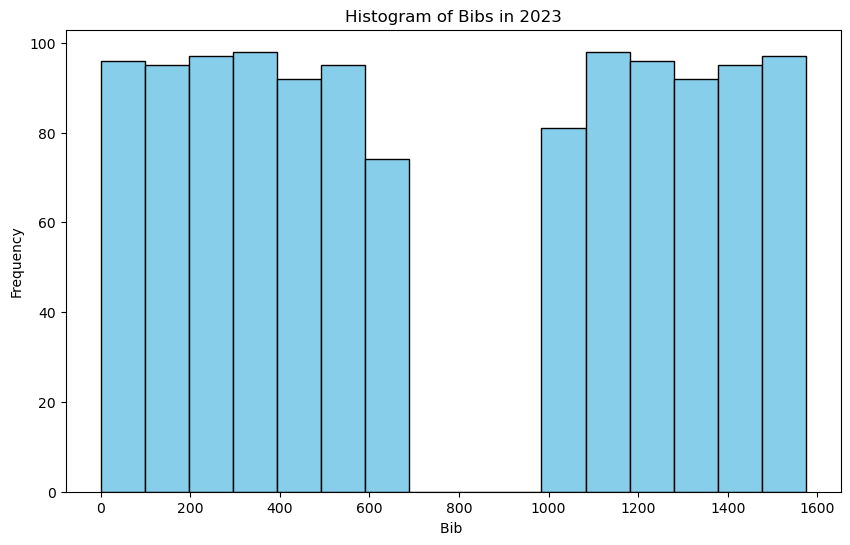

In [38]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(pivoted_TOR330_dates['Bib'], bins=16, color='skyblue', edgecolor='black')
plt.title(f'Histogram of Bibs in {year}')
plt.xlabel('Bib ')
plt.ylabel('Frequency')
plt.show()

In [39]:
### WHich wave is more likely to finish? 
### Wave 1 seems to have way more finishers - they do have a higher ITRA score, meaning that they are more
### experienced and stronger than Wave 2..
pivoted_TOR330_dates.groupby(['Wave', 'Status'])['Status'].size()

Wave   Status
Wave1  False     239
       True      409
Wave2  False     345
       True      213
Name: Status, dtype: int64

### Calculating Duration - THE MOST IMPORTANT!

In [40]:
# Calculate Duration
pivoted_TOR330_dates['Duration'] = pivoted_TOR330_dates['FINISH'] - pivoted_TOR330_dates['new_Start Date'] 

# Sort the DataFrame by the 'Duration' column
pivoted_TOR330_dates = pivoted_TOR330_dates.sort_values(by='Duration')


Processing column: Duration
1     2 days 18:39:16
643   2 days 21:49:38
5     2 days 23:22:30
19    3 days 00:04:07
629   3 days 00:16:06
Name: Duration, dtype: timedelta64[ns]


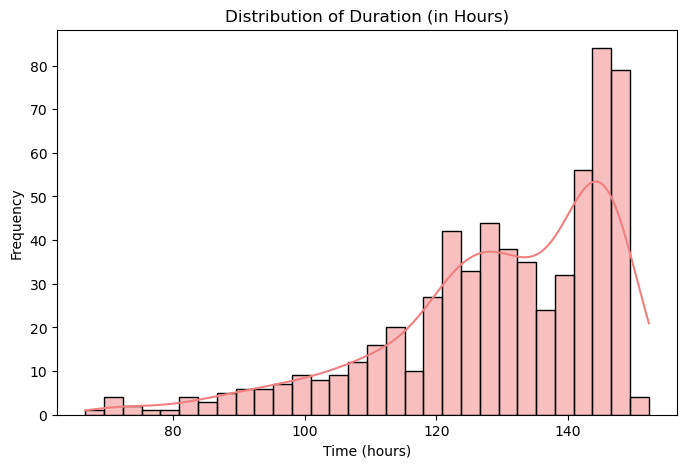

In [41]:
print(f"Processing column: Duration")
print(pivoted_TOR330_dates['Duration'].head())


pivoted_TOR330_dates['Duration']
# Convert to timedelta and get total hours (handling NaT)
pivoted_TOR330_dates['Duration_hours'] = pd.to_timedelta(
    pivoted_TOR330_dates['Duration'], errors='coerce'
).dt.total_seconds() / 3600  # Convert seconds to hours

# Drop NaN values for histogram visualization
data_to_plot = pivoted_TOR330_dates['Duration_hours'].dropna()

# Plot the histogram
plt.figure(figsize=(8, 5))
sns.histplot(data_to_plot, kde=True, bins=30, color="lightcoral")
plt.ticklabel_format(style='plain', axis='x')
plt.title(f"Distribution of Duration (in Hours)")
plt.xlabel("Time (hours)")
plt.ylabel("Frequency")
plt.show()


In [42]:
# Reorder the columns in the correct order
pivoted_TOR330_dates = pivoted_TOR330_dates[[
        'Name', 'Bib', 'Sex', 'Nationality', 'Year', 'Race', 
        'Category', 'Status','Wave', 'Duration', # MOVING DURATION CLOSER TO THE START SO I CAN SEE IT!
        
        'new_Start Date', 'Baite Youlaz', 'La Thuile', 'Rifugio Deffeyes',
         'Planaval', 'Valgrisenche IN', 'Valgrisenche OUT',
        'Chalet Epee', 'Rhemes-Notre-Dame', 'Eaux Rousse', 'Rifugio Sella',
        'Cogne IN', 'Cogne OUT', 'Goilles', 'Rifugio Dondena', 'Chardonney',
        'Pontboset', 'Donnas IN', 'Donnas OUT', 'Perloz', 'Sassa',
        'Rifugio Coda', 'Rifugio della Barma', 'Lago Chiaro',
        'Col della Vecchia', 'Niel La Gruba', 'Loo', 'Gressoney IN',
        'Gressoney OUT', 'Rifugio Alpenzu', 'Champoluc',
        'Rifugio Grand Tournalin', 'Valtournenche IN', 'Valtournenche OUT',
        'Rifugio Barmasse', 'Vareton', 'Rifugio Magià', 'Rifugio Cuney',
        'Bivacco R. Clermont', 'Oyace', 'Bruson Arp', 
         'Ollomont IN', 'Ollomont OUT', 'Rifugio Champillon',
        'Ponteille Desot', 'Bosses', 'Rifugio Frassati', 'Pas Entre Deux Sauts',
        'Monte de la Saxe', 'FINISH'
]]

### Checking accuracy of the Duration calculation

Because of issues with Start Date, it was thought that it would be a good idea to try and compare the DUV and ITRA duration time to establish accuracy of the calculation...

There are issues with the names, so some will be not be successfully merged.

In [43]:
# print(pivoted_TOR330_dates['Duration'][pivoted_TOR330_dates['Name'].str.contains('Jonina')])
# # print(TORX_duv_df['Performance'][TORX_duv_df['Name'].str.contains('Jonina')])
# # Finished in 144:46:43 hours and 

In [44]:
counting_finish_DNF_dataset(pivoted_TOR330)
find_out_the_rows_difference_between_datasets(pivoted_TOR330)
counting_groupby_dataset(pivoted_TOR330,  'Status')

TOR330 2023
# of Partipants: 1206
# of Finishers: 622
# of DNFs: 584
********************
TOR330 2023
# ITRA rows:  621
# DUV rows:  621
# TOR330 rows:  622

 ********************
TOR330 2023
# of Partipants: 1206 

Status
False    584
True     622
Name: Status, dtype: int64
********************


## extracting DNF and FInisher's for more cleaning!

In [45]:
pivoted_TOR330_dates_noDNF = pivoted_TOR330_dates[
                        # extracting runners whose status is True (Finished)
                        (pivoted_TOR330_dates['Status'] == True) &
                    ~(pivoted_TOR330_dates['FINISH'].isna())].reset_index()


In [46]:
pivoted_TOR330_dates_DNF = pivoted_TOR330_dates[
                    # selecting all rows that DNFed
                    (pivoted_TOR330_dates['Status'] == False) & # AND
                    # selecting all rows where FINISH does not have a time
                    (pivoted_TOR330_dates['FINISH'].isna())]

In [47]:
print(pivoted_TOR330_dates_noDNF.shape)
print(pivoted_TOR330_dates_DNF.shape)
print('MUST ADD UP TO:')
print(pivoted_TOR330_dates.shape)

(622, 61)
(584, 60)
MUST ADD UP TO:
(1206, 60)


### FINISHER'S Missing Timestamps
From time to time, timestamps are missing, even for finishers. Here is the missing values count for all finishers. 

THis is could be for several issues:
1) Participant's Fatigue - they forget to ask to be scanned

2) Volunteer's Fatigue - they forget to scan participants /  they thought they had already scanned the runer

3) Technology Failure - something goes wrong... ?
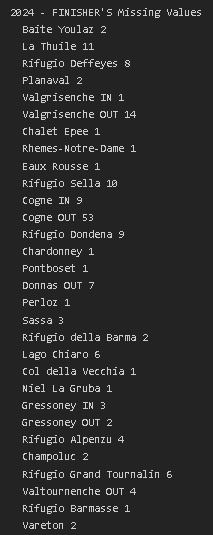

This is just a screenshot, more can be seen below!

### DNFs 

In [48]:
#### What missing values are there? 
### Some missing value is okay due to the fact that they DNFed so they wont have a timestamp
pivoted_TOR330_dates_DNF.isna().sum()

Name                         0
Bib                          0
Sex                          0
Nationality                  0
Year                         0
Race                         0
Category                     0
Status                       0
Wave                         0
Duration                   584
new_Start Date               0
Baite Youlaz               117
La Thuile                  119
Rifugio Deffeyes           131
Planaval                   149
Valgrisenche IN            155
Valgrisenche OUT           202
Chalet Epee                248
Rhemes-Notre-Dame          222
Eaux Rousse                253
Rifugio Sella              334
Cogne IN                   316
Cogne OUT                  347
Goilles                    344
Rifugio Dondena            353
Chardonney                 353
Pontboset                  363
Donnas IN                  358
Donnas OUT                 362
Perloz                     374
Sassa                      384
Rifugio Coda               391
Rifugio 

### What is the last place that DNFers reached?

In [49]:
# Function to find the last non-blank column
def get_last_non_blank(row):
    for col in reversed(row.index):
        if pd.notna(row[col]):  # Check if the value is not NaN
#             print(col)
            return col
#     return None  # In case all columns are blank

# # Apply the function to each row and assign the result to 'Retired'
pivoted_TOR330_dates['Retired'] = np.where(pivoted_TOR330_dates['Status'] == False, 
                                               pivoted_TOR330_dates.apply(get_last_non_blank, axis=1),
                                               np.nan)


In [50]:
pivoted_TOR330_dates = pivoted_TOR330_dates[['Name', 'Bib',
                                                     'Sex', 'Nationality',
                                                     'Year', 'Race', 
                                                     'Category', 'Status', 'Wave', 'Duration', 
                                                      'Retired', # putting retired at the from and not the back
                                                     'new_Start Date',
       'Baite Youlaz', 'La Thuile', 'Rifugio Deffeyes', 
       'Planaval', 'Valgrisenche IN', 'Valgrisenche OUT', 'Chalet Epee',
       'Rhemes-Notre-Dame', 'Eaux Rousse', 'Rifugio Sella', 'Cogne IN',
       'Cogne OUT', 'Goilles', 'Rifugio Dondena', 'Chardonney', 'Pontboset',
       'Donnas IN', 'Donnas OUT', 'Perloz', 'Sassa', 'Rifugio Coda',
       'Rifugio della Barma', 'Lago Chiaro', 'Col della Vecchia',
       'Niel La Gruba', 'Loo', 'Gressoney IN', 'Gressoney OUT',
       'Rifugio Alpenzu', 'Champoluc', 'Rifugio Grand Tournalin',
       'Valtournenche IN', 'Valtournenche OUT', 'Rifugio Barmasse', 'Vareton',
       'Rifugio Magià', 'Rifugio Cuney', 'Bivacco R. Clermont', 'Oyace',
       'Bruson Arp',   'Ollomont IN',
       'Ollomont OUT', 'Rifugio Champillon', 'Ponteille Desot', 'Bosses',
       'Rifugio Frassati', 'Pas Entre Deux Sauts', 'Monte de la Saxe',
       'FINISH']]

In [51]:
# creating a dataset to examine DNFs in the excel
pivoted_TOR330_dates_DNF_for_excel = pivoted_TOR330_dates_DNF.copy().drop(columns=['Sex', 'Nationality',
                                                          'Category', 'Status', 
                                                          'Wave', 'Duration'])    

# pivoted_TOR330_dates_DNF_for_excel.to_excel(f'{race} Data/5. Clean Data for Data Visualisation/{race}_{year}_DNF_df.xlsx', index = False)


In [52]:
pivoted_TOR330_dates[pivoted_TOR330_dates['Status'] == True].head(1)

,Name,Bib,Sex,Nationality,Year,Race,Category,Status,Wave,Duration,...,Bruson Arp,Ollomont IN,Ollomont OUT,Rifugio Champillon,Ponteille Desot,Bosses,Rifugio Frassati,Pas Entre Deux Sauts,Monte de la Saxe,FINISH
1,Colle Franco,2,M,IT,2023,TOR330,V1,True,Wave1,2 days 18:39:16,...,NaT,2023-09-12 17:57:48,2023-09-12 17:57:55,2023-09-12 19:36:02,2023-09-12 21:04:38,2023-09-12 22:30:41,2023-09-13 00:45:25,2023-09-13 02:23:36,2023-09-13 03:52:25,2023-09-13 04:39:16


### Issues with Last location Detected
Some people who too far of a distance between last lifebase /  refuge / checkpoint for it to be an accurate representation of their last location.

2021
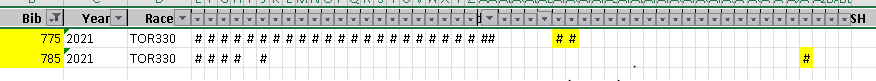

2023
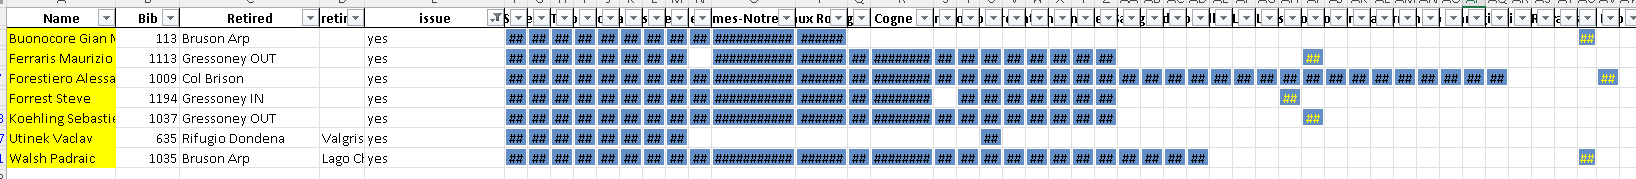

2024

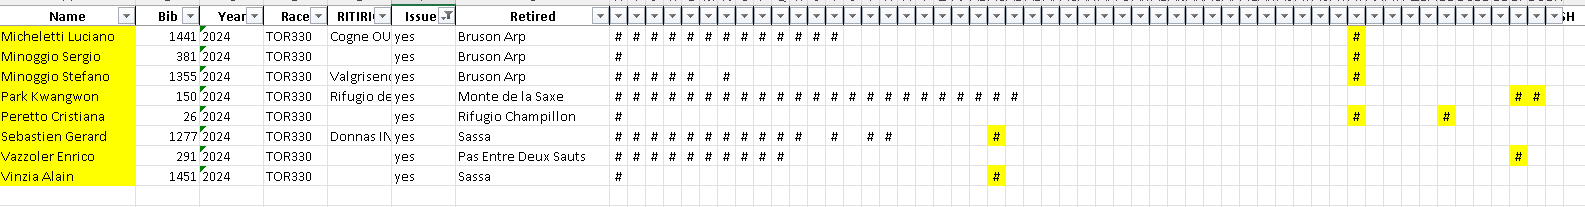

##### Solution
Create a loop that would clean those timestamps.

In [53]:
try:
    if year == '2023':

        names_that_DNFed_and_then_popped_up_miles_away =['Utinek Vaclav', 'Walsh Padraic',
                                                        'Ferraris Maurizio', 
    # 'Buonocore Gian Mario', 'Forestiero Alessandro', ## Have 2 timestamps of time travel
                                                         'Forrest Steve','Koehling Sebastien'
                                                        ]
        retired_list = list(pivoted_TOR330_dates['Retired'][
            pivoted_TOR330_dates['Name'].isin(names_that_DNFed_and_then_popped_up_miles_away)].unique())
        print(retired_list)

        for index, row in pivoted_TOR330_dates[pivoted_TOR330_dates['Name'].isin(names_that_DNFed_and_then_popped_up_miles_away)].iterrows():
            retired_column = row['Retired']  # Get the column name in 'Retired'


            if retired_column in retired_list:
                pivoted_TOR330_dates.at[index, retired_column] = pd.NaT

        # Prepending 'Name' and 'Bib' to the list
        retired_list = ['Name', 'Bib'] + retired_list  + ['Retired']
        print(retired_list)

    elif year == '2024':
        names_that_DNFed_and_then_popped_up_miles_away =['Micheletti Luciano', 'Minoggio Sergio','Minoggio Stefano', 
                                                        'Park Kwangwon',  ## Has 2 time teleportation 
                                                        'Peretto Cristiana', ## Has 2 time teleportation 
                                                        'Sebastien Gerard', 'Vazzoler Enrico', 'Vinzia Alain']

        for index, row in pivoted_TOR330_dates[pivoted_TOR330_dates['Name'].isin(names_that_DNFed_and_then_popped_up_miles_away)].iterrows():
            # Get the column name in 'Retired'
            retired_column = row['Retired']

            retired_list = list(pivoted_TOR330_dates['Retired'][
                pivoted_TOR330_dates['Name'].isin(names_that_DNFed_and_then_popped_up_miles_away)].unique())

            if row['Name'] == 'Park Kwangwon':
                # Has 2 cases of teletransportation
                pivoted_TOR330_dates.at[index, 'Pas Entre Deux Sauts'] = pd.NaT
                pivoted_TOR330_dates.at[index, 'Monte de la Saxe'] = pd.NaT

            elif row['Name'] == 'Peretto Cristiana':
                # Has 2 cases of teletransportation
                pivoted_TOR330_dates.at[index, 'Rifugio Champillon'] = pd.NaT
                pivoted_TOR330_dates.at[index, 'Bruson Arp'] = pd.NaT

            else:

                if retired_column in retired_list:
                    pivoted_TOR330_dates.at[index, retired_column] = pd.NaT

        retired_list = ['Name', 'Bib'] + retired_list + ['Retired']
        print(retired_list)
    elif year == '2021':

        names_that_DNFed_and_then_popped_up_miles_away =['Guillaume Adamczyk', 
                                                         'Andreu Casademont Roger']
        retired_list = list(pivoted_TOR330_dates['Retired'][
            pivoted_TOR330_dates['Name'].isin(names_that_DNFed_and_then_popped_up_miles_away)].unique())
        
        if row['Name'] == 'Guillaume Adamczyk':
                # Has 2 cases of teletransportation
            pivoted_TOR330_dates.at[index, 'Gressoney IN'] = pd.NaT
            pivoted_TOR330_dates.at[index, 'Gressoney OUT'] = pd.NaT
        
        elif row['Name'] == 'Andreu Casademont Roger':
                # Has 2 cases of teletransportation
            pivoted_TOR330_dates.at[index, 'Rifugio Frassati'] = pd.NaT

        # Prepending 'Name' and 'Bib' to the list
        retired_list = ['Name', 'Bib'] + retired_list  + ['Retired']
        print(retired_list)

     # Display the updated DataFrame
    pivoted_TOR330_dates[retired_list][pivoted_TOR330_dates['Name'].isin(names_that_DNFed_and_then_popped_up_miles_away)]

except:
    pass

['Rifugio Dondena', 'Bruson Arp', 'Gressoney OUT', 'Gressoney IN']
['Name', 'Bib', 'Rifugio Dondena', 'Bruson Arp', 'Gressoney OUT', 'Gressoney IN', 'Retired']


In [54]:
# Dropping the column retired otherwise it is going to think that RETIRED is the last column
pivoted_TOR330_dates = pivoted_TOR330_dates.drop(columns=['Retired'])    

# # Apply the function to each row and assign the result to 'Retired'
pivoted_TOR330_dates['Retired'] = np.where(pivoted_TOR330_dates['Status'] == False, 
                                               pivoted_TOR330_dates.apply(get_last_non_blank, axis=1),
                                               np.nan)

In [55]:
pivoted_TOR330_dates.head()

,Name,Bib,Sex,Nationality,Year,Race,Category,Status,Wave,Duration,...,Ollomont IN,Ollomont OUT,Rifugio Champillon,Ponteille Desot,Bosses,Rifugio Frassati,Pas Entre Deux Sauts,Monte de la Saxe,FINISH,Retired
1,Colle Franco,2,M,IT,2023,TOR330,V1,True,Wave1,2 days 18:39:16,...,2023-09-12 17:57:48,2023-09-12 17:57:55,2023-09-12 19:36:02,2023-09-12 21:04:38,2023-09-12 22:30:41,2023-09-13 00:45:25,2023-09-13 02:23:36,2023-09-13 03:52:25,2023-09-13 04:39:16,NaN
643,Romain Olivier,662,M,FR,2023,TOR330,SEN,True,Wave1,2 days 21:49:38,...,2023-09-12 18:42:27,2023-09-12 19:18:53,2023-09-12 20:52:03,2023-09-12 22:37:52,2023-09-13 00:19:25,2023-09-13 03:29:59,2023-09-13 05:45:09,2023-09-13 07:13:28,2023-09-13 07:49:38,NaN
5,Reynolds Galen,6,M,CA,2023,TOR330,SEN,True,Wave1,2 days 23:22:30,...,2023-09-12 22:44:14,2023-09-12 23:12:37,2023-09-13 00:32:25,2023-09-13 01:52:21,2023-09-13 03:10:12,2023-09-13 05:36:50,2023-09-13 07:12:51,2023-09-13 08:41:42,2023-09-13 09:22:30,NaN
19,Hall Damian,20,M,GB,2023,TOR330,V1,True,Wave1,3 days 00:04:07,...,2023-09-12 22:44:22,2023-09-12 23:12:43,2023-09-13 00:36:43,2023-09-13 01:59:30,2023-09-13 03:33:35,2023-09-13 06:28:38,2023-09-13 08:03:24,2023-09-13 09:29:29,2023-09-13 10:04:07,NaN
629,Galeati Gianluca,647,M,IT,2023,TOR330,V1,True,Wave1,3 days 00:16:06,...,2023-09-12 22:42:45,2023-09-12 23:04:24,2023-09-13 00:39:06,2023-09-13 02:09:40,2023-09-13 03:58:37,2023-09-13 06:28:51,2023-09-13 08:04:05,2023-09-13 09:33:49,2023-09-13 10:16:06,NaN


###  Unpredictable Weather of 2022 
In 2022, due to the weather,  the race directors decided to stop the race at Bosses and Refuge Frassati.  

In [56]:
pivoted_TOR330_dates['Status1'] = pivoted_TOR330_dates['Status'].astype('str')
# print(pivoted_TOR330_dates['Status1'].unique())

for year in years:
    if year == '2022':
        # Update 'Status1' for year 2022
        pivoted_TOR330_dates.loc[
            pivoted_TOR330_dates['Year'] == year, 'Status1'
        ] = pivoted_TOR330_dates.loc[
            pivoted_TOR330_dates['Year'] == year, 'Status1'
        ].str.replace('True', 'Finished')

        # For finishers at Bosses
        pivoted_TOR330_dates.loc[
            (pivoted_TOR330_dates['Year'] == year) & (pivoted_TOR330_dates['Retired'] == 'Bosses'), 'Status1'
        ] = pivoted_TOR330_dates.loc[
            (pivoted_TOR330_dates['Year'] == year) & (pivoted_TOR330_dates['Retired'] == 'Bosses'), 'Status1'
        ].str.replace('False', 'Finished at Bosses')

        # For finishers at Rifugio Frassati
        pivoted_TOR330_dates.loc[
            (pivoted_TOR330_dates['Year'] == year) & (pivoted_TOR330_dates['Retired'] == 'Rifugio Frassati'), 'Status1'
        ] = pivoted_TOR330_dates.loc[
            (pivoted_TOR330_dates['Year'] == year) & (pivoted_TOR330_dates['Retired'] == 'Rifugio Frassati'), 'Status1'
        ].str.replace('False', 'Finished at Rifugio Frassati')

        # For finishers at Rifugio Frassati
        pivoted_TOR330_dates.loc[
            (pivoted_TOR330_dates['Year'] == year) & (pivoted_TOR330_dates['Retired'] == 'Rifugio Frassati'), 'Status1'
        ] = pivoted_TOR330_dates.loc[
            (pivoted_TOR330_dates['Year'] == year) & (pivoted_TOR330_dates['Retired'] == 'Rifugio Frassati'), 'Status1'
        ].str.replace('False', 'Finished at Rifugio Frassati')

        
        
        # All other DNFs
        pivoted_TOR330_dates.loc[
            (pivoted_TOR330_dates['Year'] == year)
            & ~(pivoted_TOR330_dates['Retired'].isin(['Bosses', 'Rifugio Frassati'])), 'Status1'
        ] = pivoted_TOR330_dates.loc[
            (pivoted_TOR330_dates['Year'] == year)
            & ~(pivoted_TOR330_dates['Retired'].isin(['Bosses', 'Rifugio Frassati'])), 'Status1'
        ].str.replace('False', 'DNF')
        
        
        
        
        
    else:
        
        print(year)
        # Update 'Status1' for years other than 2022
        pivoted_TOR330_dates.loc[pivoted_TOR330_dates['Year'] == year, 'Status1'] = (
            pivoted_TOR330_dates.loc[pivoted_TOR330_dates['Year'] == year, 'Status1']
            .str.replace('True', 'Finished')
            .str.replace('False', 'DNF')
        )
        print(pivoted_TOR330_dates['Status1'].unique())


2023
['Finished' 'DNF']


In [57]:
pivoted_TOR330_dates['Status1'].unique()

array(['Finished', 'DNF'], dtype=object)

In [58]:
counting_finish_DNF_dataset(pivoted_TOR330_dates)
find_out_the_rows_difference_between_datasets(pivoted_TOR330_dates)
pivoted_TOR330_dates.groupby('Status1')['Status1'].count()

TOR330 2023
# of Partipants: 1206
# of Finishers: 622
# of DNFs: 584
********************
TOR330 2023
# ITRA rows:  621
# DUV rows:  621
# TOR330 rows:  622

 ********************


Status1
DNF         584
Finished    622
Name: Status1, dtype: int64

In [59]:
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.max_rows', None)     # Show all rows

### Where did the DNFs occur?

In [60]:
pivoted_TOR330_dates['Retired'] = pivoted_TOR330_dates['Retired'].str.replace(' IN', '')
pivoted_TOR330_dates['Retired'] = pivoted_TOR330_dates['Retired'].str.replace(' OUT', '')

In [61]:
Stage1 = ['Baite Youlaz', 'La Thuile', 'Rifugio Deffeyes', 
             'Planaval', 'Valgrisenche']
Stage2 = [ 'Chalet Epee', 'Rhemes-Notre-Dame',
            'Eaux Rousse', 'Rifugio Sella', 'Cogne']

Stage3 = [ 'Goilles', 'Rifugio Dondena', 'Chardonney', 'Pontboset', 'Donnas']
Stage4  = ['Perloz', 'Sassa', 'Rifugio Coda',
            'Rifugio della Barma', 'Lago Chiaro', 'Col della Vecchia',
            'Niel La Gruba', 'Loo', 'Gressoney']

Stage5 = ['Rifugio Alpenzu', 'Champoluc', 'Rifugio Grand Tournalin', 'Valtournenche'] 

Stage6 = [ 'Vareton', 'Rifugio Barmasse',
            'Rifugio Magià', 'Rifugio Cuney', 'Bivacco R. Clermont', 'Oyace',
            'Bruson Arp',   'Ollomont']
        
Stage7 = [ 'Rifugio Champillon', 'Ponteille Desot', 'Bosses',
            'Rifugio Frassati', 'Pas Entre Deux Sauts', 'Monte de la Saxe',
            'FINISH']

# finding the low / high season by date
pivoted_TOR330_dates.loc[pivoted_TOR330_dates['Retired'].isin(Stage1), 'Retired_Stage'] = 'Stage 1'
pivoted_TOR330_dates.loc[pivoted_TOR330_dates['Retired'].isin(Stage2), 'Retired_Stage'] = 'Stage 2'
pivoted_TOR330_dates.loc[pivoted_TOR330_dates['Retired'].isin(Stage3), 'Retired_Stage'] = 'Stage 3'
pivoted_TOR330_dates.loc[pivoted_TOR330_dates['Retired'].isin(Stage4), 'Retired_Stage'] = 'Stage 4'
pivoted_TOR330_dates.loc[pivoted_TOR330_dates['Retired'].isin(Stage5), 'Retired_Stage'] = 'Stage 5'
pivoted_TOR330_dates.loc[pivoted_TOR330_dates['Retired'].isin(Stage6), 'Retired_Stage'] = 'Stage 6'
pivoted_TOR330_dates.loc[pivoted_TOR330_dates['Retired'].isin(Stage7), 'Retired_Stage'] = 'Stage 7'
pivoted_TOR330_dates.loc[pivoted_TOR330_dates['Retired'] == 'new_Start Date', 'Retired_Stage'] = 'DNS'
pivoted_TOR330_dates[(pivoted_TOR330_dates['Retired'].isnull())]

,Name,Bib,Sex,Nationality,Year,Race,Category,Status,Wave,Duration,...,Rifugio Champillon,Ponteille Desot,Bosses,Rifugio Frassati,Pas Entre Deux Sauts,Monte de la Saxe,FINISH,Retired,Status1,Retired_Stage
1,Colle Franco,2,M,IT,2023,TOR330,V1,True,Wave1,2 days 18:39:16,...,2023-09-12 19:36:02,2023-09-12 21:04:38,2023-09-12 22:30:41,2023-09-13 00:45:25,2023-09-13 02:23:36,2023-09-13 03:52:25,2023-09-13 04:39:16,NaN,Finished,NaN
643,Romain Olivier,662,M,FR,2023,TOR330,SEN,True,Wave1,2 days 21:49:38,...,2023-09-12 20:52:03,2023-09-12 22:37:52,2023-09-13 00:19:25,2023-09-13 03:29:59,2023-09-13 05:45:09,2023-09-13 07:13:28,2023-09-13 07:49:38,NaN,Finished,NaN
5,Reynolds Galen,6,M,CA,2023,TOR330,SEN,True,Wave1,2 days 23:22:30,...,2023-09-13 00:32:25,2023-09-13 01:52:21,2023-09-13 03:10:12,2023-09-13 05:36:50,2023-09-13 07:12:51,2023-09-13 08:41:42,2023-09-13 09:22:30,NaN,Finished,NaN
19,Hall Damian,20,M,GB,2023,TOR330,V1,True,Wave1,3 days 00:04:07,...,2023-09-13 00:36:43,2023-09-13 01:59:30,2023-09-13 03:33:35,2023-09-13 06:28:38,2023-09-13 08:03:24,2023-09-13 09:29:29,2023-09-13 10:04:07,NaN,Finished,NaN
629,Galeati Gianluca,647,M,IT,2023,TOR330,V1,True,Wave1,3 days 00:16:06,...,2023-09-13 00:39:06,2023-09-13 02:09:40,2023-09-13 03:58:37,2023-09-13 06:28:51,2023-09-13 08:04:05,2023-09-13 09:33:49,2023-09-13 10:16:06,NaN,Finished,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,Tora Lodovico,418,M,IT,2023,TOR330,V2,True,Wave1,6 days 05:18:23,...,2023-09-15 21:39:51,2023-09-16 01:52:50,2023-09-16 04:04:19,2023-09-16 07:39:05,2023-09-16 11:18:26,2023-09-16 14:00:49,2023-09-16 15:18:23,NaN,Finished,NaN
575,Tsui Stella,593,F,SG,2023,TOR330,SEN,True,Wave1,6 days 05:44:12,...,NaT,2023-09-16 02:41:44,2023-09-16 05:55:16,2023-09-16 09:06:52,2023-09-16 12:15:06,2023-09-16 14:27:02,2023-09-16 15:44:12,NaN,Finished,NaN
184,Bertrand Ludovic,190,M,FR,2023,TOR330,V2,True,Wave1,6 days 05:50:53,...,2023-09-15 21:26:58,2023-09-16 01:12:28,2023-09-16 04:49:52,2023-09-16 08:32:26,NaT,2023-09-16 14:57:31,2023-09-16 15:50:53,NaN,Finished,NaN
800,Mondin Placido,1155,M,IT,2023,TOR330,V1,True,Wave2,6 days 08:05:50,...,NaT,2023-09-16 03:40:47,2023-09-16 06:41:41,2023-09-16 10:11:26,NaT,2023-09-16 17:06:09,2023-09-16 20:05:50,NaN,Finished,NaN


In [62]:
# making sure that I caught all aid stations!!!!
pivoted_TOR330_dates[
    (pivoted_TOR330_dates['Status'] == False) &
    
    (pivoted_TOR330_dates['Retired_Stage'].isnull())
                    ]

,Name,Bib,Sex,Nationality,Year,Race,Category,Status,Wave,Duration,...,Rifugio Champillon,Ponteille Desot,Bosses,Rifugio Frassati,Pas Entre Deux Sauts,Monte de la Saxe,FINISH,Retired,Status1,Retired_Stage


In [63]:
pivoted_TOR330_dates['Retired_Stage'].unique()

array([nan, 'DNS', 'Stage 3', 'Stage 2', 'Stage 4', 'Stage 6', 'Stage 1',
       'Stage 5', 'Stage 7'], dtype=object)

In [64]:
# finding the pre-post Gressoney
pivoted_TOR330_dates.loc[pivoted_TOR330_dates['Retired_Stage'] == 'Stage 1' , 'Pre-Post Gressoney'] ='Pre Gressoney' 
pivoted_TOR330_dates.loc[pivoted_TOR330_dates['Retired_Stage'] == 'Stage 2' , 'Pre-Post Gressoney'] ='Pre Gressoney' 
pivoted_TOR330_dates.loc[pivoted_TOR330_dates['Retired_Stage'] == 'Stage 3' , 'Pre-Post Gressoney'] ='Pre Gressoney' 
pivoted_TOR330_dates.loc[pivoted_TOR330_dates['Retired_Stage'] == 'Stage 4' , 'Pre-Post Gressoney'] ='Pre Gressoney' 
pivoted_TOR330_dates.loc[pivoted_TOR330_dates['Retired_Stage'] == 'Stage 5' , 'Pre-Post Gressoney'] ='Post Gressoney' 
pivoted_TOR330_dates.loc[pivoted_TOR330_dates['Retired_Stage'] == 'Stage 6' , 'Pre-Post Gressoney'] ='Post Gressoney' 
pivoted_TOR330_dates.loc[pivoted_TOR330_dates['Retired_Stage'] == 'Stage 7' , 'Pre-Post Gressoney'] ='Post Gressoney' 
pivoted_TOR330_dates.loc[pivoted_TOR330_dates['Retired'] == 'new_Start Date', 'Pre-Post Gressoney'] = 'Pre Gressoney'


In [65]:
pivoted_TOR330_dates.groupby('Pre-Post Gressoney')['Pre-Post Gressoney'].count()

Pre-Post Gressoney
Post Gressoney     64
Pre Gressoney     520
Name: Pre-Post Gressoney, dtype: int64

In [66]:
pivoted_TOR330_dates.groupby('Retired_Stage')['Retired_Stage'].count()

Retired_Stage
DNS        116
Stage 1     99
Stage 2    128
Stage 3     30
Stage 4    147
Stage 5     19
Stage 6     37
Stage 7      8
Name: Retired_Stage, dtype: int64

In [67]:
counting_retired_Stage_and_wave = pivoted_TOR330_dates[pivoted_TOR330_dates['Status'] == False].groupby(['Retired_Stage', 'Wave'] ).size().to_frame()

# Reset the index to make it more readable
counting_retired_Stage_and_wave.index = pd.MultiIndex.from_tuples(counting_retired_Stage_and_wave.index, 
                                            names=["Retired_Stage", "Wave"])

# Unstack the Wave level to create columns for Wave1 and Wave2
counting_retired_Stage_and_wave = counting_retired_Stage_and_wave.unstack(level="Wave")
counting_retired_Stage_and_wave.reset_index(drop =  False)
counting_retired_Stage_and_wave.columns = counting_retired_Stage_and_wave.columns.droplevel(0)

try:
    # counting_retired_Stage_and_wave.columns = counting_retired_Stage_and_wave.columns.droplevel(0)
    counting_retired_Stage_and_wave['Total'] = counting_retired_Stage_and_wave['Wave1'] +counting_retired_Stage_and_wave['Wave2']

    counting_retired_Stage_and_wave['Wave1_%'] = counting_retired_Stage_and_wave['Wave1']/counting_retired_Stage_and_wave['Total']
    counting_retired_Stage_and_wave['Wave2_%'] = counting_retired_Stage_and_wave['Wave2']/counting_retired_Stage_and_wave['Total']

    counting_retired_Stage_and_wave['Wave1_%'] = round(counting_retired_Stage_and_wave['Wave1_%']*100, 1)
    counting_retired_Stage_and_wave['Wave2_%']= round(counting_retired_Stage_and_wave['Wave2_%']*100, 2)

    counting_retired_Stage_and_wave
except:
    pass

In [68]:
# DNS
pivoted_TOR330_dates[pivoted_TOR330_dates['Retired'] == 'new_Start Date']

,Name,Bib,Sex,Nationality,Year,Race,Category,Status,Wave,Duration,...,Ponteille Desot,Bosses,Rifugio Frassati,Pas Entre Deux Sauts,Monte de la Saxe,FINISH,Retired,Status1,Retired_Stage,Pre-Post Gressoney
0,Russi Jonas,1,M,CH,2023,TOR330,SEN,False,Wave1,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,new_Start Date,DNF,DNS,Pre Gressoney
2,Corsini Simone,3,M,IT,2023,TOR330,SEN,False,Wave1,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,new_Start Date,DNF,DNS,Pre Gressoney
8,Collins Avery,9,M,US,2023,TOR330,SEN,False,Wave1,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,new_Start Date,DNF,DNS,Pre Gressoney
33,Schjolberg Hallvard,34,M,NO,2023,TOR330,V1,False,Wave1,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,new_Start Date,DNF,DNS,Pre Gressoney
37,Roberts Simon,38,M,GB,2023,TOR330,SEN,False,Wave1,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,new_Start Date,DNF,DNS,Pre Gressoney
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,Jimenez Roqhuett Marcelo,1487,M,CR,2023,TOR330,V1,False,Wave2,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,new_Start Date,DNF,DNS,Pre Gressoney
1137,Campion Mark,1505,M,GB,2023,TOR330,V1,False,Wave2,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,new_Start Date,DNF,DNS,Pre Gressoney
1152,Torre Silvere,1520,M,FR,2023,TOR330,V3,False,Wave2,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,new_Start Date,DNF,DNS,Pre Gressoney
1155,Vlatkovic Tatiana,1523,F,CH,2023,TOR330,SEN,False,Wave2,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,new_Start Date,DNF,DNS,Pre Gressoney


In [69]:
pivoted_TOR330_dates = pivoted_TOR330_dates[[
    'Name', 'Bib', 'Sex', 'Nationality', 'Year', 'Race', 'Category',
    'Status', 'Status1', 'Wave', 'Duration',  
    'Retired', 'Retired_Stage', 
    'new_Start Date', 'Baite Youlaz', 'La Thuile', 'Rifugio Deffeyes', 
    'Planaval', 'Valgrisenche IN', 'Valgrisenche OUT', 'Chalet Epee',
    'Rhemes-Notre-Dame', 'Eaux Rousse', 'Rifugio Sella', 'Cogne IN',
    'Cogne OUT', 'Goilles', 'Rifugio Dondena', 'Chardonney', 'Pontboset',
    'Donnas IN', 'Donnas OUT', 'Perloz', 'Sassa', 'Rifugio Coda',
    'Rifugio della Barma', 'Lago Chiaro', 'Col della Vecchia',
    'Niel La Gruba', 'Loo', 'Gressoney IN', 'Gressoney OUT',
    'Rifugio Alpenzu', 'Champoluc', 'Rifugio Grand Tournalin',
    'Valtournenche IN', 'Valtournenche OUT', 'Rifugio Barmasse', 'Vareton',
    'Rifugio Magià', 'Rifugio Cuney', 'Bivacco R. Clermont', 'Oyace',
    'Bruson Arp',   'Ollomont IN',
    'Ollomont OUT', 'Rifugio Champillon', 'Ponteille Desot', 'Bosses',
    'Rifugio Frassati', 'Pas Entre Deux Sauts', 'Monte de la Saxe',
    'FINISH']]

### Calculating the Times for each Stage

In [70]:
pivoted_TOR330_dates['Stage 1 Time'] = pivoted_TOR330_dates['Valgrisenche IN'] - pivoted_TOR330_dates['new_Start Date']

pivoted_TOR330_dates['Time Spent in Valgrisenche'] = pivoted_TOR330_dates['Valgrisenche OUT'] - pivoted_TOR330_dates['Valgrisenche IN']

pivoted_TOR330_dates['Stage 2 Time'] = pivoted_TOR330_dates['Cogne IN'] - pivoted_TOR330_dates['Valgrisenche OUT']
pivoted_TOR330_dates['Time Spent in Cogne'] = pivoted_TOR330_dates['Cogne OUT'] - pivoted_TOR330_dates['Cogne IN']


pivoted_TOR330_dates['Stage 3 Time'] = pivoted_TOR330_dates['Donnas IN'] - pivoted_TOR330_dates['Cogne OUT']
pivoted_TOR330_dates['Time Spent in Donnas'] = pivoted_TOR330_dates['Donnas OUT'] - pivoted_TOR330_dates['Donnas IN']


pivoted_TOR330_dates['Stage 4 Time'] = pivoted_TOR330_dates['Gressoney IN'] - pivoted_TOR330_dates['Donnas OUT']
pivoted_TOR330_dates['Time Spent in Gressoney'] = pivoted_TOR330_dates['Gressoney OUT'] - pivoted_TOR330_dates['Gressoney IN']

pivoted_TOR330_dates['Stage 5 Time'] = pivoted_TOR330_dates['Valtournenche IN'] - pivoted_TOR330_dates['Gressoney OUT']
pivoted_TOR330_dates['Time Spent in Valtournenche'] = pivoted_TOR330_dates['Valtournenche OUT'] - pivoted_TOR330_dates['Valtournenche IN']

pivoted_TOR330_dates['Stage 6 Time'] = pivoted_TOR330_dates['Ollomont IN'] - pivoted_TOR330_dates['Valtournenche OUT']
pivoted_TOR330_dates['Time Spent in Ollomont'] = pivoted_TOR330_dates['Ollomont OUT'] - pivoted_TOR330_dates['Ollomont IN']

pivoted_TOR330_dates['Stage 7 Time'] = pivoted_TOR330_dates['FINISH'] - pivoted_TOR330_dates['Ollomont OUT']

In [71]:
pivoted_TOR330_dates_noDNF = pivoted_TOR330_dates[
                        # extracting runners whose status is True (Finished)
                        (pivoted_TOR330_dates['Status'] == True) &
                    ~(pivoted_TOR330_dates['FINISH'].isna())].reset_index()
pivoted_TOR330_dates_noDNF.isnull().sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of      index   Name    Bib    Sex  Nationality   Year   Race  Category  Status  \
0    False  False  False  False        False  False  False     False   False   
1    False  False  False  False        False  False  False     False   False   
2    False  False  False  False        False  False  False     False   False   
3    False  False  False  False        False  False  False     False   False   
4    False  False  False  False        False  False  False     False   False   
..     ...    ...    ...    ...          ...    ...    ...       ...     ...   
617  False  False  False  False        False  False  False     False   False   
618  False  False  False  False        False  False  False     False   False   
619  False  False  False  False        False  False  False     False   False   
620  False  False  False  False        False  False  False     False   False   
621  False  False  False  False        False  False  False

### Converting to seconds for Tableau Analysis

In [72]:
tableau_pivoted_TOR330_dates = pivoted_TOR330_dates[[
    'Name', 'Bib', 'Sex', 'Nationality', 'Year', 'Race', 'Category',
    'Status', 'Status1', 'Wave',
    'Retired', 'Retired_Stage', 
    'new_Start Date',
    'Stage 1 Time', 'Time Spent in Valgrisenche', 
    'Stage 2 Time', 'Time Spent in Cogne',
    'Stage 3 Time', 'Time Spent in Donnas',
    'Stage 4 Time', 'Time Spent in Gressoney',
    'Stage 5 Time', 'Time Spent in Valtournenche',
    'Stage 6 Time', 'Time Spent in Ollomont',
    'Stage 7 Time',  'Duration']].copy()

In [73]:
pivoted_TOR330_dates[[
    'Name', 'Bib', 'Sex', 'Nationality', 'Year', 'Race', 'Category',
    'Status', 'Status1', 'Wave', 
    'Retired', 'Retired_Stage', 
    'new_Start Date',
    'Stage 1 Time', 'Time Spent in Valgrisenche', 
    'Stage 2 Time', 'Time Spent in Cogne', 'Cogne OUT',
    'Stage 3 Time', 'Time Spent in Donnas',
    'Stage 4 Time', 'Time Spent in Gressoney',
    'Stage 5 Time', 'Time Spent in Valtournenche',
    'Stage 6 Time', 'Time Spent in Ollomont',
    'Stage 7 Time',  'Duration']][pivoted_TOR330_dates['Name'].str.contains('Williams John')].transpose()

,1167
Name,Williams John
Bib,1535
Sex,M
Nationality,IE
Year,2023
Race,TOR330
Category,V1
Status,True
Status1,Finished
Wave,Wave2


In [74]:
pivoted_TOR330_dates[[
    'Name', 'Bib', 'Sex', 'Nationality', 'Year', 'Race', 'Category',
    'Status', 'Status1', 'Wave', 'Duration',  
    'Retired', 'Retired_Stage', 
    'new_Start Date',
    'Stage 1 Time', 'Time Spent in Valgrisenche', 
    'Stage 2 Time', 'Time Spent in Cogne', 'Cogne OUT',
    'Stage 3 Time', 'Time Spent in Donnas',
    'Stage 4 Time', 'Time Spent in Gressoney',
    'Stage 5 Time', 'Time Spent in Valtournenche',
    'Stage 6 Time', 'Time Spent in Ollomont',
    'Stage 7 Time',  'Duration']].isnull().sum()

Name                             0
Bib                              0
Sex                              0
Nationality                      0
Year                             0
Race                             0
Category                         0
Status                           0
Status1                          0
Wave                             0
Duration                       584
Retired                        622
Retired_Stage                  622
new_Start Date                   0
Stage 1 Time                   155
Time Spent in Valgrisenche     203
Stage 2 Time                   320
Time Spent in Cogne            383
Cogne OUT                      378
Stage 3 Time                   412
Time Spent in Donnas           378
Stage 4 Time                   512
Time Spent in Gressoney        511
Stage 5 Time                   538
Time Spent in Valtournenche    541
Stage 6 Time                   582
Time Spent in Ollomont         594
Stage 7 Time                   600
Duration            

In [75]:
for i in tableau_pivoted_TOR330_dates.columns:
    print(i)

Name
Bib
Sex
Nationality
Year
Race
Category
Status
Status1
Wave
Retired
Retired_Stage
new_Start Date
Stage 1 Time
Time Spent in Valgrisenche
Stage 2 Time
Time Spent in Cogne
Stage 3 Time
Time Spent in Donnas
Stage 4 Time
Time Spent in Gressoney
Stage 5 Time
Time Spent in Valtournenche
Stage 6 Time
Time Spent in Ollomont
Stage 7 Time
Duration


Processing column: Stage 1 Time
count                         1051
mean     0 days 12:39:59.897240723
std      0 days 02:10:05.496041764
min                0 days 07:05:31
25%         0 days 11:10:29.500000
50%                0 days 12:39:44
75%                0 days 14:11:59
max                0 days 18:59:40
Name: Stage 1 Time, dtype: object


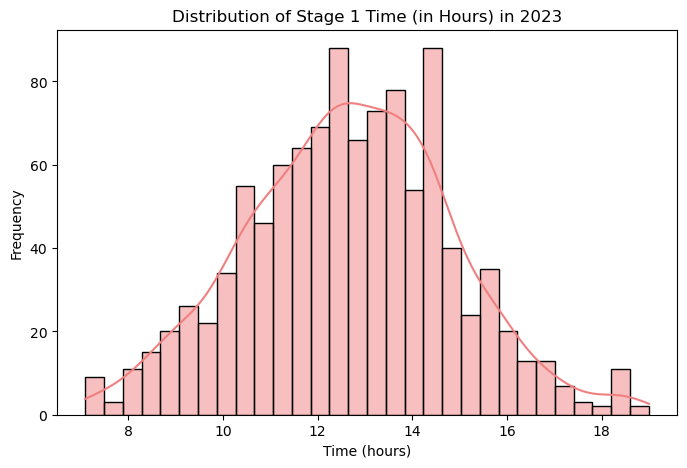

********************************************************************************
Processing column: Time Spent in Valgrisenche
count                         1003
mean     0 days 01:21:15.020937188
std      0 days 00:55:27.360589052
min                0 days 00:00:36
25%         0 days 00:41:59.500000
50%                0 days 01:04:39
75%                0 days 01:49:28
max                0 days 07:31:10
Name: Time Spent in Valgrisenche, dtype: object


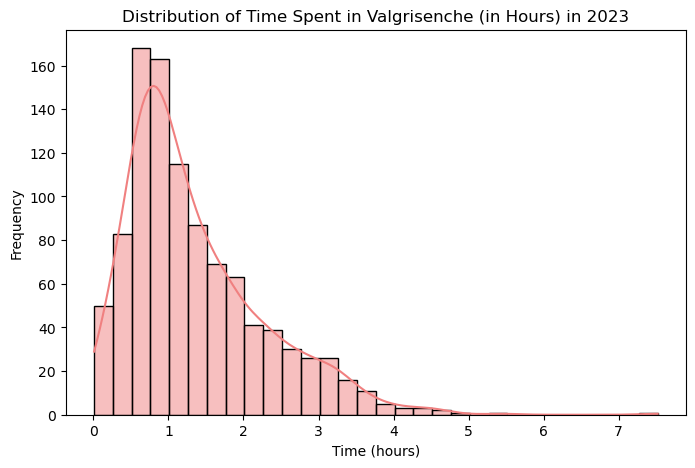

********************************************************************************
Processing column: Stage 2 Time
count                          886
mean     0 days 18:30:00.065462753
std      0 days 03:07:46.680286098
min                0 days 09:42:55
25%         0 days 16:30:00.500000
50%                0 days 18:35:59
75%                0 days 20:34:50
max                1 days 02:46:44
Name: Stage 2 Time, dtype: object


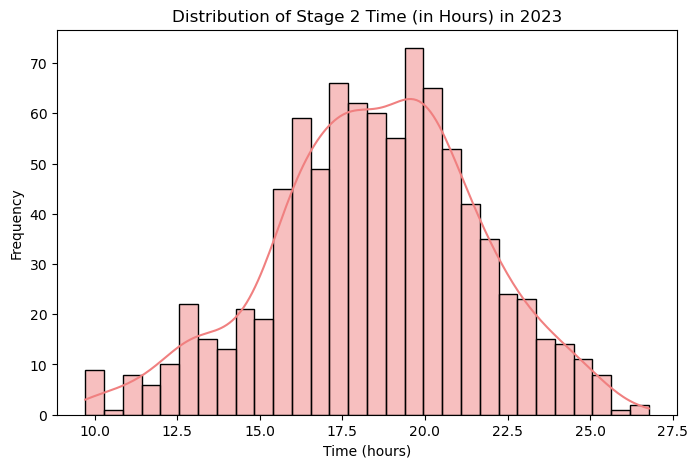

********************************************************************************
Processing column: Time Spent in Cogne
count                          823
mean     0 days 02:33:57.122721749
std      0 days 01:28:51.379066901
min              -1 days +23:59:42
25%         0 days 01:24:49.500000
50%                0 days 02:27:06
75%                0 days 03:36:05
max                0 days 11:32:57
Name: Time Spent in Cogne, dtype: object


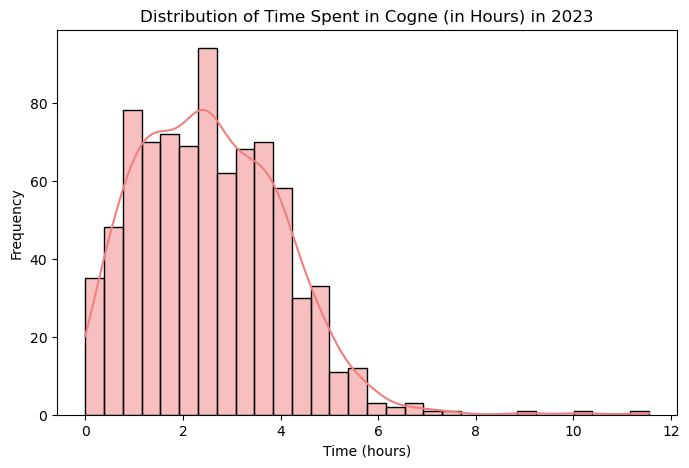

********************************************************************************
Processing column: Stage 3 Time
count                          794
mean     0 days 12:29:16.614609571
std      0 days 02:01:02.004749980
min              -1 days +22:37:53
25%         0 days 11:22:55.500000
50%                0 days 12:41:32
75%                0 days 13:49:45
max                0 days 17:30:31
Name: Stage 3 Time, dtype: object


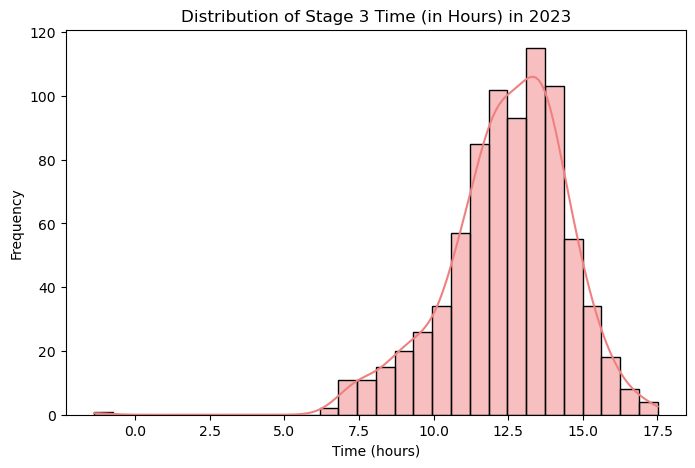

********************************************************************************
Processing column: Time Spent in Donnas
count                          828
mean     0 days 02:40:43.404589371
std      0 days 01:24:58.289866379
min                0 days 00:00:27
25%         0 days 01:42:25.750000
50%                0 days 02:35:32
75%                0 days 03:30:27
max                0 days 18:06:51
Name: Time Spent in Donnas, dtype: object


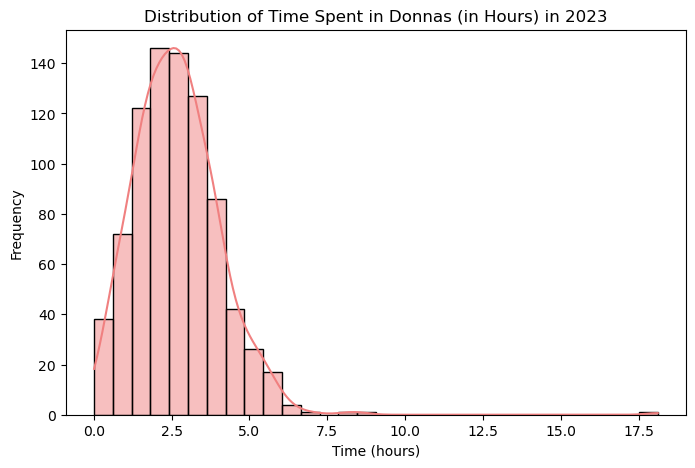

********************************************************************************
Processing column: Stage 4 Time
count                          694
mean     0 days 23:32:32.497118155
std      0 days 03:28:20.324667038
min                0 days 11:21:58
25%                0 days 21:14:45
50%                1 days 00:14:18
75%                1 days 02:01:51
max                1 days 07:19:28
Name: Stage 4 Time, dtype: object


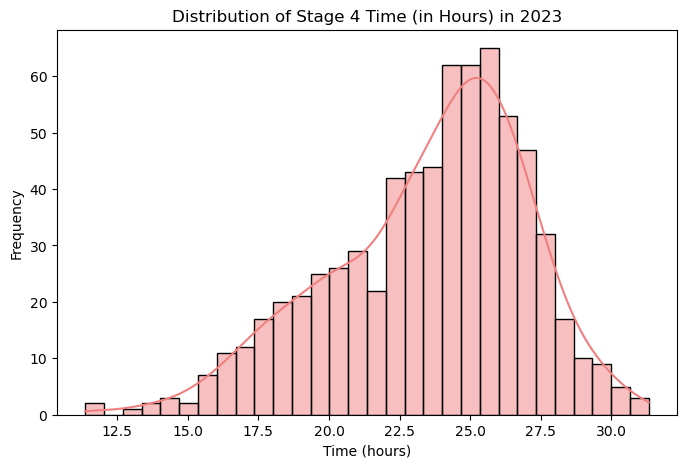

********************************************************************************
Processing column: Time Spent in Gressoney
count                          695
mean     0 days 03:14:26.913669064
std      0 days 01:35:09.165792086
min              -1 days +23:59:26
25%                0 days 02:14:47
50%                0 days 03:13:29
75%         0 days 04:03:28.500000
max                0 days 12:14:56
Name: Time Spent in Gressoney, dtype: object


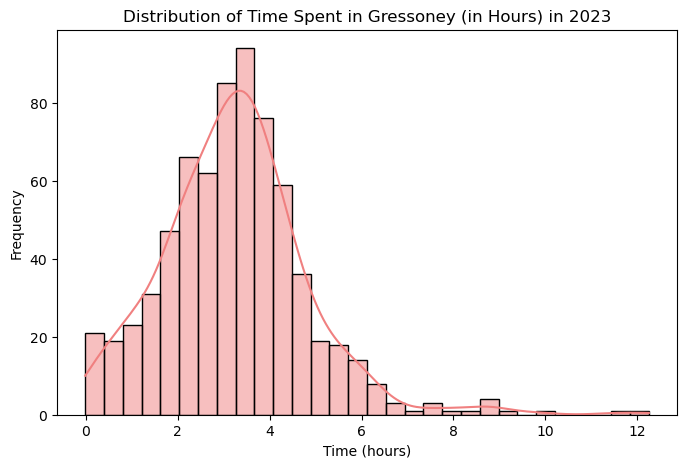

********************************************************************************
Processing column: Stage 5 Time
count                          668
mean     0 days 12:35:35.208083832
std      0 days 02:15:05.541661622
min                0 days 07:08:23
25%         0 days 11:01:48.250000
50%                0 days 12:39:06
75%         0 days 14:02:22.750000
max                0 days 22:27:00
Name: Stage 5 Time, dtype: object


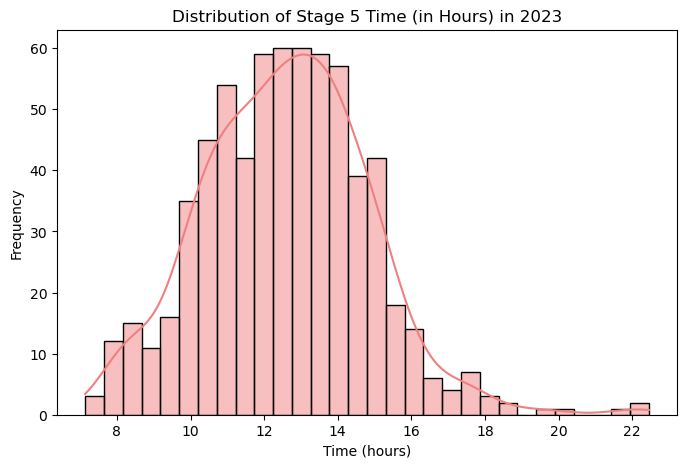

********************************************************************************
Processing column: Time Spent in Valtournenche
count                          665
mean     0 days 02:46:32.264661654
std      0 days 01:28:33.586060979
min                0 days 00:03:38
25%                0 days 01:38:27
50%                0 days 02:46:28
75%                0 days 03:40:32
max                0 days 09:52:00
Name: Time Spent in Valtournenche, dtype: object


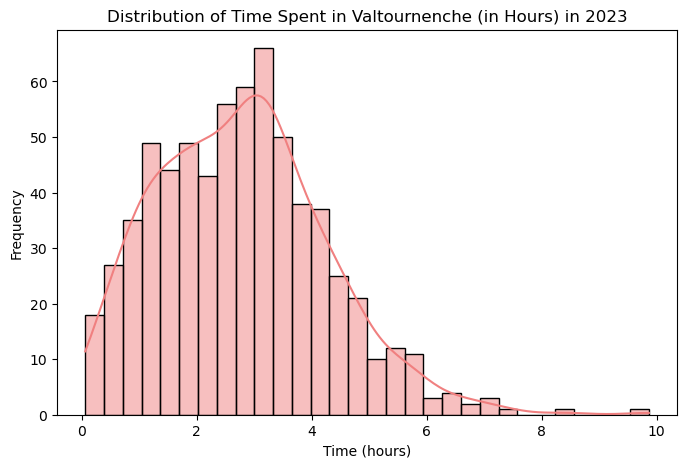

********************************************************************************
Processing column: Stage 6 Time
count                          624
mean     0 days 20:03:45.884615384
std      0 days 02:51:24.014907256
min                0 days 11:37:58
25%                0 days 18:11:23
50%                0 days 20:14:13
75%                0 days 21:58:31
max                1 days 05:03:50
Name: Stage 6 Time, dtype: object


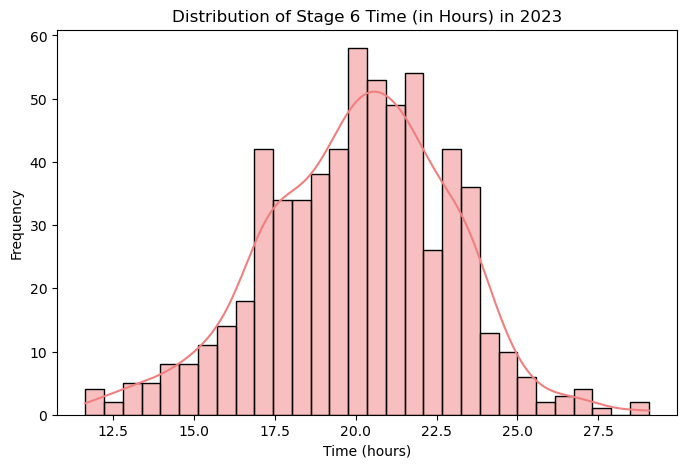

********************************************************************************
Processing column: Time Spent in Ollomont
count                          612
mean     0 days 02:28:25.325163398
std      0 days 01:27:42.756907637
min              -1 days +23:24:09
25%         0 days 01:25:54.500000
50%         0 days 02:18:37.500000
75%         0 days 03:15:50.500000
max                0 days 08:49:43
Name: Time Spent in Ollomont, dtype: object


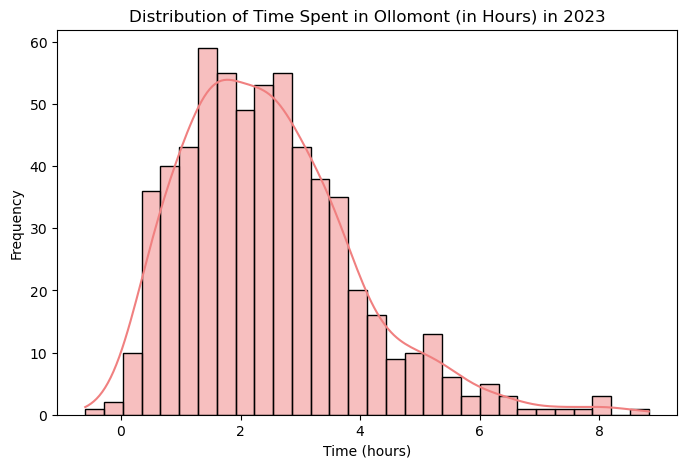

********************************************************************************
Processing column: Stage 7 Time
count                          606
mean     0 days 17:01:49.691419141
std      0 days 03:16:45.141012546
min                0 days 10:09:53
25%                0 days 14:36:02
50%                0 days 17:05:56
75%                0 days 19:22:35
max                1 days 17:34:31
Name: Stage 7 Time, dtype: object


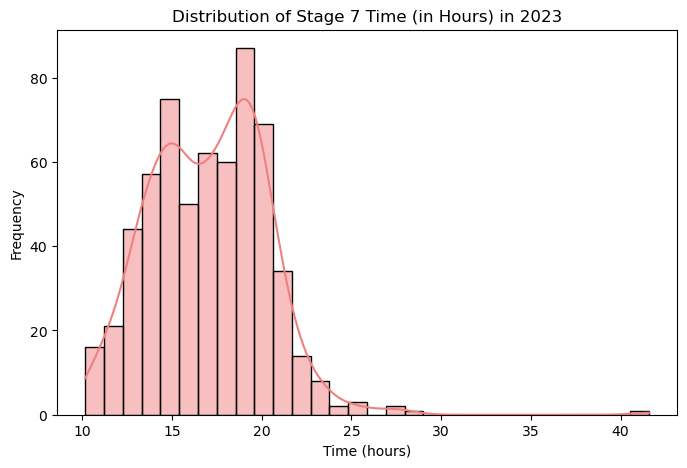

********************************************************************************
Processing column: Duration
count                          622
mean     5 days 09:30:33.818327974
std      0 days 17:06:51.041668145
min                2 days 18:39:16
25%         5 days 01:25:48.750000
50%         5 days 12:26:55.500000
75%                5 days 23:55:49
max                6 days 08:15:44
Name: Duration, dtype: object


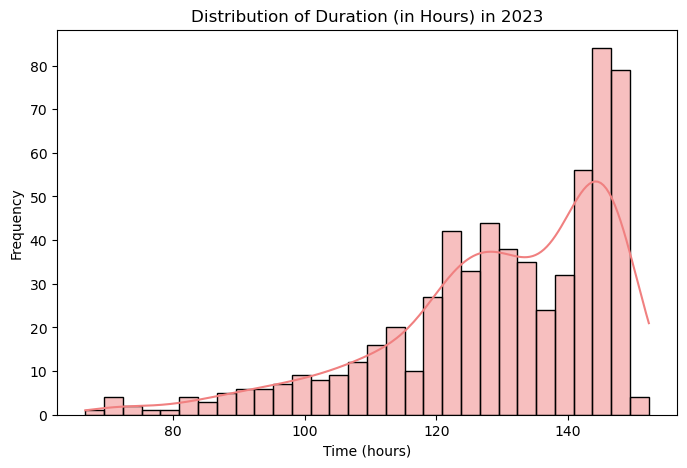

********************************************************************************


In [76]:
# Define the columns to process
time_columns = ['Stage 1 Time', 'Time Spent in Valgrisenche', 
                'Stage 2 Time', 'Time Spent in Cogne',
                'Stage 3 Time', 'Time Spent in Donnas',
                'Stage 4 Time', 'Time Spent in Gressoney',
                'Stage 5 Time', 'Time Spent in Valtournenche',
                'Stage 6 Time', 'Time Spent in Ollomont',
                'Stage 7 Time', 'Duration']

# Loop through the columns
for column in time_columns:
    print(f"Processing column: {column}")
    print(tableau_pivoted_TOR330_dates[column].describe())
    
    
    
    
    # Convert to timedelta and get total hours (handling NaT)
    tableau_pivoted_TOR330_dates[f'{column}_hours'] = pd.to_timedelta(
        tableau_pivoted_TOR330_dates[f'{column}'], errors='coerce'
    ).dt.total_seconds() / 3600  # Convert seconds to hours

    # Drop NaN values for histogram visualization
    data_to_plot = tableau_pivoted_TOR330_dates[f'{column}_hours'].dropna()

    # Plot the histogram
    plt.figure(figsize=(8, 5))
    sns.histplot(data_to_plot, kde=True, bins=30, color="lightcoral")
    plt.ticklabel_format(style='plain', axis='x')
    plt.title(f"Distribution of {column} (in Hours) in {year}")
    plt.xlabel("Time (hours)")
    plt.ylabel("Frequency")
    plt.show()
    
    print('*'*80)


### Sub-Finish Category

I labelled the Finisher's Sub-130 Finish times
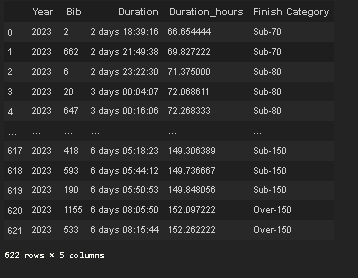

In [77]:
# Convert to timedelta and get total hours (handling NaT)
pivoted_TOR330_dates['Duration_hours'] = pd.to_timedelta(
    pivoted_TOR330_dates['Duration'], errors='coerce').dt.total_seconds() / 3600  # Convert seconds to hours
# Create a new column 'Finish Category'
def categorize_duration(hours):
    if pd.isna(hours):
        return 'DNF'  # Handle NaT values
    elif hours < 50:
        return 'Sub-50'
    elif hours <= 150:
        return f'Sub-{int(hours // 10) * 10 + 10}'  # Round to nearest 10 up to 150
    else:
        return 'Over-150'

pivoted_TOR330_dates['Finish Category'] = pivoted_TOR330_dates['Duration_hours'].apply(categorize_duration)


# Define the desired order of categories
category_order = [
    'Sub-50','Sub-60',
    'Sub-70','Sub-80','Sub-90', 'Sub-100', 'Sub-110', 'Sub-120',
    'Sub-130', 'Sub-140', 'Sub-150', 'Over-150', 'DNF'
]

# Set 'Finish Category' as a categorical column with the defined order
pivoted_TOR330_dates['Finish Category'] = pd.Categorical(
    pivoted_TOR330_dates['Finish Category'],
    categories=category_order,
    ordered=True
)


# Display the DataFrame
pivoted_TOR330_dates[['Year','Bib', 'Duration', 'Duration_hours', 'Finish Category']]

    

,Year,Bib,Duration,Duration_hours,Finish Category
1,2023,2,2 days 18:39:16,66.654444,Sub-70
643,2023,662,2 days 21:49:38,69.827222,Sub-70
5,2023,6,2 days 23:22:30,71.375000,Sub-80
19,2023,20,3 days 00:04:07,72.068611,Sub-80
629,2023,647,3 days 00:16:06,72.268333,Sub-80
...,...,...,...,...,...
1192,2023,1560,NaT,NaN,DNF
1199,2023,1568,NaT,NaN,DNF
1202,2023,1571,NaT,NaN,DNF
1203,2023,1572,NaT,NaN,DNF


In [78]:
pivoted_TOR330_dates.groupby(['Finish Category'])['Finish Category'].count()

Finish Category
Sub-50        0
Sub-60        0
Sub-70        2
Sub-80        7
Sub-90       12
Sub-100      25
Sub-110      36
Sub-120      61
Sub-130     138
Sub-140     113
Sub-150     226
Over-150      2
DNF         584
Name: Finish Category, dtype: int64

In [79]:

stages = [
    'Stage 1 Time', 'Time Spent in Valgrisenche',
    'Stage 2 Time', 'Time Spent in Cogne',
    'Stage 3 Time', 'Time Spent in Donnas',
    'Stage 4 Time', 'Time Spent in Gressoney',
    'Stage 5 Time', 'Time Spent in Valtournenche',
    'Stage 6 Time', 'Time Spent in Ollomont',
    'Stage 7 Time'
]


# Group by 'Finish Category' and calculate the mean for specified columns
result = (
    pivoted_TOR330_dates.groupby(['Year', 'Finish Category'])[stages].mean()
    
).reset_index(drop = False)

# Add a 'Total' column with the sum of all time columns
# result['Total'] = result.sum(axis=1)
# # Convert to timedelta and get total hours (handling NaT)
# result['Total'] = pd.to_timedelta(
#     result['Total'], errors='coerce').dt.total_seconds() / 3600  # Convert seconds to hours
# # Create a new column 'Finish Category'

for column in stages:
    # Convert the column to timedelta and strip milliseconds
    result[f'{column}'] = pd.to_timedelta(result[f'{column}']).dt.floor('s')


result.sort_values(by='Finish Category', ascending=True)


# Display the final table
# result[(result['Finish Category'] == 'Sub-130') |
#       (result['Finish Category'] == 'Sub-150')]

,Year,Finish Category,Stage 1 Time,Time Spent in Valgrisenche,Stage 2 Time,Time Spent in Cogne,Stage 3 Time,Time Spent in Donnas,Stage 4 Time,Time Spent in Gressoney,Stage 5 Time,Time Spent in Valtournenche,Stage 6 Time,Time Spent in Ollomont,Stage 7 Time
0,2023,Sub-50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2023,Sub-60,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,2023,Sub-70,0 days 07:10:38,0 days 00:04:32,0 days 09:47:47,0 days 00:10:40,0 days 06:36:03,0 days 00:19:24,0 days 11:33:24,0 days 00:12:59,0 days 07:59:16,0 days 00:15:58,0 days 12:09:24,0 days 00:18:16,0 days 11:36:03
3,2023,Sub-80,0 days 07:46:39,0 days 00:05:37,0 days 10:31:05,0 days 00:14:48,0 days 07:19:05,0 days 00:15:20,0 days 14:52:28,0 days 00:13:31,0 days 07:49:42,0 days 00:14:18,0 days 13:08:35,0 days 00:21:43,0 days 11:29:29
4,2023,Sub-90,0 days 08:32:39,0 days 00:16:25,0 days 11:56:37,0 days 00:23:58,0 days 07:56:23,0 days 00:40:03,0 days 16:40:13,0 days 00:44:52,0 days 08:26:22,0 days 00:53:10,0 days 15:45:54,0 days 00:36:48,0 days 12:26:21
5,2023,Sub-100,0 days 09:20:37,0 days 00:29:08,0 days 13:22:41,0 days 00:47:07,0 days 08:46:40,0 days 01:49:28,0 days 17:18:14,0 days 01:58:59,0 days 09:22:50,0 days 01:55:13,0 days 15:24:49,0 days 01:21:09,0 days 13:11:13
6,2023,Sub-110,0 days 09:51:37,0 days 00:39:29,0 days 14:37:49,0 days 01:15:07,0 days 09:48:20,0 days 02:17:44,0 days 18:46:56,0 days 02:20:15,0 days 10:42:46,0 days 01:59:39,0 days 17:45:39,0 days 01:43:39,0 days 13:39:15
7,2023,Sub-120,0 days 10:49:01,0 days 00:49:08,0 days 16:08:35,0 days 01:43:30,0 days 11:14:27,0 days 02:38:03,0 days 20:21:52,0 days 03:22:10,0 days 10:50:56,0 days 01:59:17,0 days 18:40:30,0 days 01:25:50,0 days 15:26:19
8,2023,Sub-130,0 days 11:26:39,0 days 01:13:30,0 days 17:07:08,0 days 02:26:12,0 days 12:02:29,0 days 02:36:01,0 days 22:39:50,0 days 03:13:15,0 days 11:40:18,0 days 03:09:06,0 days 18:46:59,0 days 03:02:58,0 days 15:55:54
9,2023,Sub-140,0 days 12:27:22,0 days 01:17:33,0 days 18:24:56,0 days 02:38:59,0 days 13:00:06,0 days 02:21:25,1 days 00:47:27,0 days 03:25:57,0 days 13:22:36,0 days 02:45:03,0 days 20:41:03,0 days 03:16:20,0 days 16:26:51


In [80]:
pivoted_TOR330_dates[[
    'Name', 'Bib', # 'Sex', 'Nationality', 'Year', 'Race','Category', 'Status', 'Status1', 'Wave', 'Duration', 'Retired','Retired_Stage', 
    'Stage 1 Time', 'Time Spent in Valgrisenche', 
    'Stage 2 Time', 'Time Spent in Cogne',
    'Stage 3 Time', 'Time Spent in Donnas',
    'Stage 4 Time', 'Time Spent in Gressoney',
    'Stage 5 Time', 'Time Spent in Valtournenche',
    'Stage 6 Time', 'Time Spent in Ollomont',
    'Stage 7 Time', 'Duration','Duration_hours', 'Finish Category'
]]

,Name,Bib,Stage 1 Time,Time Spent in Valgrisenche,Stage 2 Time,Time Spent in Cogne,Stage 3 Time,Time Spent in Donnas,Stage 4 Time,Time Spent in Gressoney,Stage 5 Time,Time Spent in Valtournenche,Stage 6 Time,Time Spent in Ollomont,Stage 7 Time,Duration,Duration_hours,Finish Category
1,Colle Franco,2,0 days 07:05:31,0 days 00:05:00,0 days 09:52:40,0 days 00:10:26,0 days 06:35:28,0 days 00:08:37,0 days 11:44:50,0 days 00:12:55,0 days 07:59:22,0 days 00:15:53,0 days 11:47:06,0 days 00:00:07,0 days 10:41:21,2 days 18:39:16,66.654444,Sub-70
643,Romain Olivier,662,0 days 07:15:46,0 days 00:04:04,0 days 09:42:55,0 days 00:10:54,0 days 06:36:39,0 days 00:30:12,0 days 11:21:58,0 days 00:13:04,0 days 07:59:10,0 days 00:16:03,0 days 12:31:42,0 days 00:36:26,0 days 12:30:45,2 days 21:49:38,69.827222,Sub-70
5,Reynolds Galen,6,0 days 07:16:48,0 days 00:05:37,0 days 10:11:16,0 days 00:19:11,0 days 06:59:04,0 days 00:02:01,0 days 13:33:23,0 days 00:11:38,0 days 08:23:21,0 days 00:11:27,0 days 13:30:28,0 days 00:28:23,0 days 10:09:53,2 days 23:22:30,71.375000,Sub-80
19,Hall Damian,20,0 days 07:16:45,0 days 00:05:42,0 days 10:08:11,0 days 00:18:55,0 days 07:04:46,0 days 00:22:05,0 days 13:17:00,0 days 00:23:46,0 days 08:05:42,0 days 00:10:44,0 days 13:30:46,0 days 00:28:21,0 days 10:51:24,3 days 00:04:07,72.068611,Sub-80
629,Galeati Gianluca,647,0 days 07:22:05,0 days 00:05:05,0 days 10:08:19,0 days 00:16:39,0 days 07:06:06,0 days 00:00:44,0 days 13:29:15,0 days 00:12:20,0 days 08:23:09,0 days 00:15:01,0 days 13:24:02,0 days 00:21:39,0 days 11:11:42,3 days 00:16:06,72.268333,Sub-80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,Delafond Sandra,1560,0 days 14:29:43,0 days 01:06:00,1 days 01:12:23,0 days 02:20:26,0 days 15:02:31,0 days 05:33:33,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,DNF
1199,Van Der Heijden Peter,1568,0 days 13:29:42,0 days 01:37:52,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,DNF
1202,Gribaldo Massimiliano,1571,0 days 15:26:49,0 days 00:52:50,1 days 00:45:51,0 days 01:36:06,0 days 15:36:58,0 days 02:46:44,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,DNF
1203,Offredi Giorgio,1572,0 days 15:27:22,0 days 01:20:24,1 days 00:01:39,0 days 02:11:59,0 days 15:29:55,0 days 01:38:15,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,DNF


In [81]:
# Filter rows for 'Sub-130' finish category
sub_130_df = pivoted_TOR330_dates[pivoted_TOR330_dates['Finish Category'] == 'Sub-130']

# Group by 'Year' and 'Finish Category', then calculate descriptive statistics for the specified columns
result = (
    sub_130_df.groupby(['Year', 'Finish Category'])[stages]
    .describe()  # Get descriptive statistics
    .stack()  # Reshape for easier manipulation
    .unstack(0)  # Bring 'Year' to columns
    .reset_index()  # Flatten the index
)


# Ensure all time columns are converted to timedelta, strip milliseconds
for column in stages:
    sub_130_df[column] = pd.to_timedelta(sub_130_df[column], errors='coerce').dt.floor('s')

result



C:\Users\Karina\AppData\Local\Temp\ipykernel_7752\88173512.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_130_df[column] = pd.to_timedelta(sub_130_df[column], errors='coerce').dt.floor('s')


,Finish Category,level_1,Stage 1 Time,Time Spent in Valgrisenche,Stage 2 Time,Time Spent in Cogne,Stage 3 Time,Time Spent in Donnas,Stage 4 Time,Time Spent in Gressoney,Stage 5 Time,Time Spent in Valtournenche,Stage 6 Time,Time Spent in Ollomont,Stage 7 Time
Year,,,2023,2023,2023,2023,2023,2023,2023,2023,2023,2023,2023,2023,2023
0,Sub-130,count,138,138,137,132,131,134,135,137,137,138,138,135,135
1,Sub-130,mean,0 days 11:26:39.797101449,0 days 01:13:30.405797101,0 days 17:07:08.284671532,0 days 02:26:12.386363636,0 days 12:02:29.954198473,0 days 02:36:01.932835820,0 days 22:39:50.711111111,0 days 03:13:15.160583941,0 days 11:40:18.992700729,0 days 03:09:06.072463768,0 days 18:46:59.413043478,0 days 03:02:58.037037037,0 days 15:55:54.311111111
2,Sub-130,std,0 days 01:02:08.078358954,0 days 00:55:51.136627390,0 days 01:35:06.283440658,0 days 01:08:25.054309033,0 days 01:40:55.793614843,0 days 01:44:13.445581603,0 days 01:55:06.263532698,0 days 01:15:59.505910786,0 days 01:18:10.727734986,0 days 01:33:40.207491088,0 days 01:57:29.845354962,0 days 01:41:14.107282122,0 days 02:45:26.451506677
3,Sub-130,min,0 days 08:24:21,0 days 00:07:16,0 days 12:59:17,0 days 00:16:46,-1 days +22:37:53,0 days 00:26:52,0 days 16:57:57,0 days 00:01:18,0 days 09:16:49,0 days 00:22:31,0 days 13:02:27,0 days 00:16:54,0 days 10:50:53
4,Sub-130,25%,0 days 10:42:17,0 days 00:42:46.750000,0 days 16:07:59,0 days 01:31:29.750000,0 days 11:14:36,0 days 01:42:32.500000,0 days 21:15:17,0 days 02:22:13,0 days 10:41:18,0 days 01:53:40.500000,0 days 17:29:25.750000,0 days 01:37:50,0 days 13:48:41.500000
5,Sub-130,50%,0 days 11:28:53.500000,0 days 00:55:47,0 days 16:57:44,0 days 02:16:06,0 days 12:05:28,0 days 02:23:02,0 days 22:37:17,0 days 03:10:15,0 days 11:34:13,0 days 03:12:37,0 days 18:39:15,0 days 02:54:35,0 days 15:38:58
6,Sub-130,75%,0 days 11:59:08.500000,0 days 01:27:35,0 days 17:50:11,0 days 03:10:24.500000,0 days 12:54:34,0 days 03:07:41.750000,0 days 23:59:07.500000,0 days 04:01:41,0 days 12:26:38,0 days 04:09:24.750000,0 days 20:03:47,0 days 03:57:29.500000,0 days 17:27:23.500000
7,Sub-130,max,0 days 14:17:20,0 days 07:31:10,1 days 01:37:35,0 days 05:26:06,0 days 15:28:41,0 days 18:06:51,1 days 03:31:58,0 days 07:21:21,0 days 15:54:40,0 days 07:28:35,1 days 01:55:09,0 days 08:10:54,1 days 01:18:48


### Time Travel Issues
While playing with min/max/ mean for the time spent on each stage, I spotted a negative number for Stage 3 TIme.

This means that the individual was scanned 'Donnas IN' prior to 'Cogne OUT'
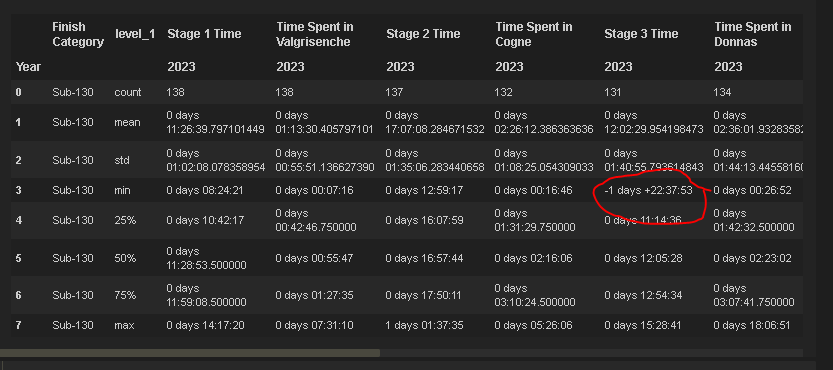

So I pulled the individual out to examine in more detail.

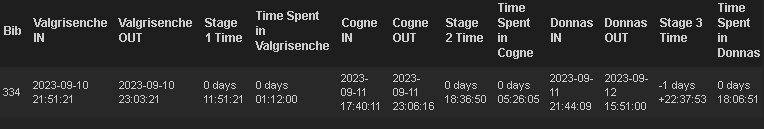

Looking at the raw data, it looks like it would make sense Bib# 334 to have been scanned 'DOnnas OUT' on the way in and 'Donnas IN' on the way out

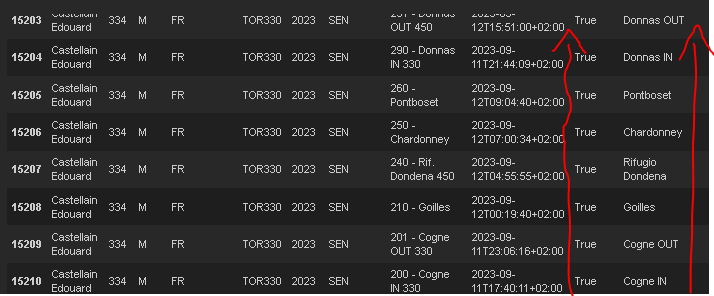

Code was written to detect more time travelling
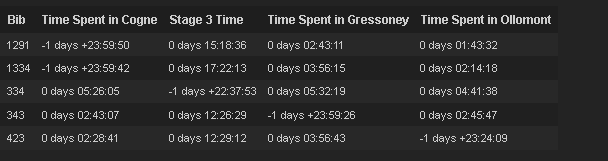


In [82]:
pivoted_TOR330_dates[[ 'Bib',  'Valgrisenche IN', 'Valgrisenche OUT', 'Stage 1 Time','Time Spent in Valgrisenche',  'Cogne IN', 'Cogne OUT', 'Stage 2 Time','Time Spent in Cogne', 'Donnas IN', 'Donnas OUT', 'Stage 3 Time', 'Time Spent in Donnas', 'Gressoney IN','Gressoney OUT', 'Stage 4 Time', 'Time Spent in Gressoney']][pivoted_TOR330_dates['Stage 3 Time'] == pd.to_timedelta('-1 days +22:37:53')]

,Bib,Valgrisenche IN,Valgrisenche OUT,Stage 1 Time,Time Spent in Valgrisenche,Cogne IN,Cogne OUT,Stage 2 Time,Time Spent in Cogne,Donnas IN,Donnas OUT,Stage 3 Time,Time Spent in Donnas,Gressoney IN,Gressoney OUT,Stage 4 Time,Time Spent in Gressoney
326,334,2023-09-10 21:51:21,2023-09-10 23:03:21,0 days 11:51:21,0 days 01:12:00,2023-09-11 17:40:11,2023-09-11 23:06:16,0 days 18:36:50,0 days 05:26:05,2023-09-11 21:44:09,2023-09-12 15:51:00,-1 days +22:37:53,0 days 18:06:51,2023-09-13 15:42:20,2023-09-13 21:14:39,0 days 23:51:20,0 days 05:32:19


In [83]:
bib334_places = ['Valgrisenche IN', 'Valgrisenche OUT'
                      'Cogne IN', 'Cogne OUT', 
                      'Donnas IN', 'Donnas OUT', 
                      'Gressoney IN','Gressoney OUT']

TOR330[(TOR330['Bib'] == 334) 
#       &(TOR330['aid_stations']).isin(bib334_places)
      ]

Name  Bib Sex Nationality    Race  Year  \
TOR330_2023 15169  Castellain Edouard  334   M          FR  TOR330  2023   
            15170  Castellain Edouard  334   M          FR  TOR330  2023   
            15171  Castellain Edouard  334   M          FR  TOR330  2023   
            15172  Castellain Edouard  334   M          FR  TOR330  2023   
            15173  Castellain Edouard  334   M          FR  TOR330  2023   
            15174  Castellain Edouard  334   M          FR  TOR330  2023   
            15175  Castellain Edouard  334   M          FR  TOR330  2023   
            15176  Castellain Edouard  334   M          FR  TOR330  2023   
            15177  Castellain Edouard  334   M          FR  TOR330  2023   
            15178  Castellain Edouard  334   M          FR  TOR330  2023   
            15179  Castellain Edouard  334   M          FR  TOR330  2023   
            15180  Castellain Edouard  334   M          FR  TOR330  2023   
            15181  Castellain Edouard  334   M          FR  TOR330  2023   
            15182  Castellain Edouard  334   M          FR  TOR330  2023   
            15183  Castellain Edouard  334   M          FR  TOR330  2023   
            15184  Castellain Edouard  334   M          FR  TOR330  2023   
            15185  Castellain Edouard  334   M          FR  TOR330  2023   
            15186  Castellain Edouard  334   M          FR  TOR330  2023   
            15187  Castellain Edouard  334   M          FR  TOR330  2023   
            15188  Castellain Edouard  334   M          FR  TOR330  2023   
            15189  Castellain Edouard  334   M          FR  TOR330  2023   
            15190  Castellain Edouard  334   M          FR  TOR330  2023   
            15191  Castellain Edouard  334   M          FR  TOR330  2023   
            15192  Castellain Edouard  334   M          FR  TOR330  2023   
            15193  Castellain Edouard  334   M          FR  TOR330  2023   
            15194  Castellain Edouard  334   M          FR  TOR330  2023   
            15195  Castellain Edouard  334   M          FR  TOR330  2023   
            15196  Castellain Edouard  334   M          FR  TOR330  2023   
            15197  Castellain Edouard  334   M          FR  TOR330  2023   
            15198  Castellain Edouard  334   M          FR  TOR330  2023   
            15199  Castellain Edouard  334   M          FR  TOR330  2023   
            15200  Castellain Edouard  334   M          FR  TOR330  2023   
            15201  Castellain Edouard  334   M          FR  TOR330  2023   
            15202  Castellain Edouard  334   M          FR  TOR330  2023   
            15203  Castellain Edouard  334   M          FR  TOR330  2023   
            15204  Castellain Edouard  334   M          FR  TOR330  2023   
            15205  Castellain Edouard  334   M          FR  TOR330  2023   
            15206  Castellain Edouard  334   M          FR  TOR330  2023   
            15207  Castellain Edouard  334   M          FR  TOR330  2023   
            15208  Castellain Edouard  334   M          FR  TOR330  2023   
            15209  Castellain Edouard  334   M          FR  TOR330  2023   
            15210  Castellain Edouard  334   M          FR  TOR330  2023   
            15211  Castellain Edouard  334   M          FR  TOR330  2023   
            15212  Castellain Edouard  334   M          FR  TOR330  2023   
            15213  Castellain Edouard  334   M          FR  TOR330  2023   
            15214  Castellain Edouard  334   M          FR  TOR330  2023   
            15215  Castellain Edouard  334   M          FR  TOR330  2023   
            15216  Castellain Edouard  334   M          FR  TOR330  2023   
            15217  Castellain Edouard  334   M          FR  TOR330  2023   
            15218  Castellain Edouard  334   M          FR  TOR330  2023   
            15219  Castellain Edouard  334   M          FR  TOR330  2023   
            15220  Castellain Edouard  334   M          FR  TOR330  2023   
     

In [84]:
pivoted_TOR330_dates[pivoted_TOR330_dates['Stage 3 Time'] == pd.to_timedelta('-1 days +22:37:53')]

,Name,Bib,Sex,Nationality,Year,Race,Category,Status,Status1,Wave,...,Time Spent in Donnas,Stage 4 Time,Time Spent in Gressoney,Stage 5 Time,Time Spent in Valtournenche,Stage 6 Time,Time Spent in Ollomont,Stage 7 Time,Duration_hours,Finish Category
326,Castellain Edouard,334,M,FR,2023,TOR330,SEN,True,Finished,Wave1,...,0 days 18:06:51,0 days 23:51:20,0 days 05:32:19,0 days 11:59:00,0 days 04:02:40,0 days 14:08:51,0 days 04:41:38,0 days 11:37:08,129.732222,Sub-130


In [85]:
time_travel_issue = []

# Iterate through each stage
for stage in stages:
    # Find rows with negative time values in the current stage
    negative = pivoted_TOR330_dates[pivoted_TOR330_dates[stage] < pd.to_timedelta('00:00:00')]
    
    # Append the DataFrame with issues to the list if not empty
    if not negative.empty:
        time_travel_issue.append(negative)
        print('*'*20,'\n', pivoted_TOR330_dates[['Bib', stage]][pivoted_TOR330_dates[stage] < pd.to_timedelta('00:00:00')])

# Combine all detected issues into a single DataFrame
time_travel_issues_df = pd.concat(time_travel_issue).reset_index(drop=True)

# Save the result to a file (optional)
time_travel_issues_df.to_csv('time_travel_issues.csv', index=False)

# Display the resulting DataFrame
time_travel_issues_df


******************** 
       Bib Time Spent in Cogne
933  1291   -1 days +23:59:50
972  1334   -1 days +23:59:42
******************** 
      Bib      Stage 3 Time
326  334 -1 days +22:37:53
******************** 
      Bib Time Spent in Gressoney
335  343       -1 days +23:59:26
******************** 
      Bib Time Spent in Ollomont
412  423      -1 days +23:24:09


,Name,Bib,Sex,Nationality,Year,Race,Category,Status,Status1,Wave,...,Time Spent in Donnas,Stage 4 Time,Time Spent in Gressoney,Stage 5 Time,Time Spent in Valtournenche,Stage 6 Time,Time Spent in Ollomont,Stage 7 Time,Duration_hours,Finish Category
0,Danicic Dalibor,1291,M,RS,2023,TOR330,SEN,True,Finished,Wave2,...,0 days 01:12:42,1 days 03:24:48,0 days 02:43:11,0 days 14:38:12,0 days 00:54:13,1 days 00:40:39,0 days 01:43:32,0 days 23:16:30,146.785278,Sub-150
1,Petrarulo Manuela,1334,F,IT,2023,TOR330,V1,True,Finished,Wave2,...,0 days 02:44:29,1 days 03:10:10,0 days 03:56:15,0 days 13:00:44,0 days 05:47:31,0 days 20:48:49,0 days 02:14:18,0 days 19:10:54,147.851111,Sub-150
2,Castellain Edouard,334,M,FR,2023,TOR330,SEN,True,Finished,Wave1,...,0 days 18:06:51,0 days 23:51:20,0 days 05:32:19,0 days 11:59:00,0 days 04:02:40,0 days 14:08:51,0 days 04:41:38,0 days 11:37:08,129.732222,Sub-130
3,Driver Percy,343,M,MU,2023,TOR330,V1,True,Finished,Wave1,...,0 days 02:56:28,1 days 00:00:52,-1 days +23:59:26,0 days 16:35:55,0 days 01:57:23,0 days 21:28:45,0 days 02:45:47,0 days 15:46:24,131.722222,Sub-140
4,Bonnet Florian,423,M,FR,2023,TOR330,V2,True,Finished,Wave1,...,0 days 00:00:42,1 days 00:02:19,0 days 03:56:43,0 days 11:32:25,0 days 01:37:19,0 days 18:02:59,-1 days +23:24:09,1 days 17:34:31,147.846667,Sub-150


In [86]:
time_travel_issues_df[['Bib', 'Duration',
                      'Time Spent in Cogne',
                      'Stage 3 Time',
                       'Time Spent in Gressoney',
                       'Time Spent in Ollomont',
                      ]]

,Bib,Duration,Time Spent in Cogne,Stage 3 Time,Time Spent in Gressoney,Time Spent in Ollomont
0,1291,6 days 02:47:07,-1 days +23:59:50,0 days 15:18:36,0 days 02:43:11,0 days 01:43:32
1,1334,6 days 03:51:04,-1 days +23:59:42,0 days 17:22:13,0 days 03:56:15,0 days 02:14:18
2,334,5 days 09:43:56,0 days 05:26:05,-1 days +22:37:53,0 days 05:32:19,0 days 04:41:38
3,343,5 days 11:43:20,0 days 02:43:07,0 days 12:26:29,-1 days +23:59:26,0 days 02:45:47
4,423,6 days 03:50:48,0 days 02:28:41,0 days 12:29:12,0 days 03:56:43,-1 days +23:24:09


In [87]:
time_travel_issues_df[['Bib', 'Duration',
                       'Valgrisenche IN','Valgrisenche OUT',
                       'Chalet Epee','Rhemes-Notre-Dame',  'Eaux Rousse', 'Stage 2 Time',
                       'Cogne IN','Cogne OUT',
                       'Goilles',
                       'Time Spent in Cogne',
                      'Stage 3 Time']][(time_travel_issues_df['Bib'] == 1291) |
                                      (time_travel_issues_df['Bib'] == 1334)]

,Bib,Duration,Valgrisenche IN,Valgrisenche OUT,Chalet Epee,Rhemes-Notre-Dame,Eaux Rousse,Stage 2 Time,Cogne IN,Cogne OUT,Goilles,Time Spent in Cogne,Stage 3 Time
0,1291,6 days 02:47:07,2023-09-11 01:39:19,2023-09-11 02:18:21,2023-09-11 04:41:32,2023-09-11 07:53:35,2023-09-11 13:38:31,0 days 20:36:33,2023-09-11 22:54:54,2023-09-11 22:54:44,2023-09-12 02:05:50,-1 days +23:59:50,0 days 15:18:36
1,1334,6 days 03:51:04,2023-09-11 02:15:45,2023-09-11 05:30:48,2023-09-11 07:32:40,2023-09-11 10:07:56,2023-09-11 15:49:58,0 days 18:05:11,2023-09-11 23:35:59,2023-09-11 23:35:41,2023-09-12 05:30:49,-1 days +23:59:42,0 days 17:22:13


In [88]:
time_travel_issues_df[['Bib', 'Duration',
                       'Valgrisenche IN', 'Valgrisenche OUT', 
                      'Cogne IN', 'Cogne OUT', 
                      'Donnas IN', 'Donnas OUT', 
                       'Stage 3 Time', 'Time Spent in Donnas', 'Perloz', 'Sassa', 
                      'Gressoney IN','Gressoney OUT', 
                      
                      ]][(time_travel_issues_df['Bib'] == 334)]

,Bib,Duration,Valgrisenche IN,Valgrisenche OUT,Cogne IN,Cogne OUT,Donnas IN,Donnas OUT,Stage 3 Time,Time Spent in Donnas,Perloz,Sassa,Gressoney IN,Gressoney OUT
2,334,5 days 09:43:56,2023-09-10 21:51:21,2023-09-10 23:03:21,2023-09-11 17:40:11,2023-09-11 23:06:16,2023-09-11 21:44:09,2023-09-12 15:51:00,-1 days +22:37:53,0 days 18:06:51,2023-09-12 17:28:24,2023-09-12 19:54:46,2023-09-13 15:42:20,2023-09-13 21:14:39


In [89]:
time_travel_issues_df[['Bib', 'Duration',
                       'Niel La Gruba',
                       'Gressoney IN','Gressoney OUT','Stage 4 Time',
                       'Time Spent in Gressoney',
                       'Rifugio Alpenzu', 
                       'Valtournenche IN', 'Stage 5 Time']][time_travel_issues_df['Bib'] == 343]

,Bib,Duration,Niel La Gruba,Gressoney IN,Gressoney OUT,Stage 4 Time,Time Spent in Gressoney,Rifugio Alpenzu,Valtournenche IN,Stage 5 Time
3,343,5 days 11:43:20,2023-09-13 05:52:19,2023-09-13 11:09:40,2023-09-13 11:09:06,1 days 00:00:52,-1 days +23:59:26,2023-09-13 17:27:42,2023-09-14 03:45:01,0 days 16:35:55


# Demographic data

In [90]:
TOR330_dem = pivoted_TOR330_dates.copy()

TOR330_dem['Duration_seconds'] = pd.to_timedelta(
    TOR330_dem['Duration'], errors='coerce'
).dt.total_seconds()

TOR330_dem = TOR330_dem[[ 'Year', 'Race', 'Name', 'Bib', 'Sex', 'Nationality',  'Category',
       'Status', 'Status1', 'Wave', 'Duration_seconds', 'Retired', 'Retired_Stage','Finish Category'  ]]

TOR330_dem.to_excel(f'{race} Data/5. Clean Data for Data Visualisation/{race}_{year}_dem.xlsx', index = False)

TOR330_dem

,Year,Race,Name,Bib,Sex,Nationality,Category,Status,Status1,Wave,Duration_seconds,Retired,Retired_Stage,Finish Category
1,2023,TOR330,Colle Franco,2,M,IT,V1,True,Finished,Wave1,239956.0,NaN,NaN,Sub-70
643,2023,TOR330,Romain Olivier,662,M,FR,SEN,True,Finished,Wave1,251378.0,NaN,NaN,Sub-70
5,2023,TOR330,Reynolds Galen,6,M,CA,SEN,True,Finished,Wave1,256950.0,NaN,NaN,Sub-80
19,2023,TOR330,Hall Damian,20,M,GB,V1,True,Finished,Wave1,259447.0,NaN,NaN,Sub-80
629,2023,TOR330,Galeati Gianluca,647,M,IT,V1,True,Finished,Wave1,260166.0,NaN,NaN,Sub-80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,2023,TOR330,Delafond Sandra,1560,F,FR,V1,False,DNF,Wave2,NaN,Donnas,Stage 3,DNF
1199,2023,TOR330,Van Der Heijden Peter,1568,M,NL,V2,False,DNF,Wave2,NaN,Rhemes-Notre-Dame,Stage 2,DNF
1202,2023,TOR330,Gribaldo Massimiliano,1571,M,IT,V2,False,DNF,Wave2,NaN,Col della Vecchia,Stage 4,DNF
1203,2023,TOR330,Offredi Giorgio,1572,M,IT,V2,False,DNF,Wave2,NaN,Rifugio della Barma,Stage 4,DNF


In [91]:

# import os

# # Specify the file path
# file_path = f'{race} Data/5. Clean Data for Data Visualisation/{race}_dem.xlsx'

# # Check if the file exists
# if os.path.exists(file_path):
#     # Read the existing file into a DataFrame
#     existing_data = pd.read_excel(file_path)

#     # Reset the index to ensure no duplicate indices
#     existing_data.reset_index(drop=True, inplace=True)
#     TOR330_dem.reset_index(drop=True, inplace=True)

#     # Find rows in TOR330_dem that are not in the existing_data
#     new_rows = TOR330_dem[~TOR330_dem.apply(tuple, axis=1).isin(existing_data.apply(tuple, axis=1))]

#     if not new_rows.empty:
#         # Concatenate the new rows to the existing data, resetting the index afterward
#         updated_data = pd.concat([existing_data, new_rows], ignore_index=True)

#         # Save the updated data back to the file
#         updated_data.to_excel(file_path, index=False)
#         print("New rows added to the file.")
#     else:
#         print("No new rows to add. File remains unchanged.")
# else:
#     # If the file doesn't exist, save the DataFrame as a new file
#     TOR330_dem.to_excel(file_path, index=False)
#     print(f"File created at {file_path}.")


In [92]:
TOR330_dem.groupby(['Status1'])['Status1'].count()

Status1
DNF         584
Finished    622
Name: Status1, dtype: int64

In [93]:
# TORX = []
# for  year in  ['2021', '2022', '2023', '2024']:
#     TORX_race_year =  pd.read_excel(f'TOR330 Data/5. Clean Data for Data Visualisation/TOR330_{year}_dem.xlsx')
#     print( f'{race}_{year}_dem')
#     print(TORX_race_year.shape)
#     print(TORX_race_year.columns)
#     TORX.append(TORX_race_year)

    
# TORX = pd.concat(TORX, ignore_index=True)
# TORX.to_excel(f'TOR330 Data/5. Clean Data for Data Visualisation/TOR330_dem.xlsx', index = False)
# TORX['Nationality'].unique()

## Checkpoint Data

In [94]:
sub_lifebase_TOR330_dates = pivoted_TOR330_dates[[
    'Year', 'Race', 'Bib', 'Wave', 'Finish Category',
    'Valgrisenche IN', 'Valgrisenche OUT', 
    'Cogne IN', 'Cogne OUT',
    'Donnas IN', 'Donnas OUT',
    'Gressoney IN', 'Gressoney OUT',
    'Valtournenche IN', 'Valtournenche OUT', 
    'Ollomont IN', 'Ollomont OUT', 'FINISH'
]]
# Pivot the data using melt
melt_sub_lifebase_TOR330_dates = sub_lifebase_TOR330_dates.melt(id_vars=[ 
    'Year', "Race", "Bib", 'Wave', 'Finish Category'
                    ], 
                     var_name="Lifebase", 
                     value_name="Timestamp")



################### CATEGORY!
# Define the desired order of categories
category_order = [
#     'Sub-60',
    'Valgrisenche IN', 'Valgrisenche OUT', 
    'Cogne IN', 'Cogne OUT',
    'Donnas IN', 'Donnas OUT',
    'Gressoney IN', 'Gressoney OUT',
    'Valtournenche IN', 'Valtournenche OUT', 
    'Ollomont IN', 'Ollomont OUT', 'FINISH'
]

# Set 'Finish Category' as a categorical column with the defined order
melt_sub_lifebase_TOR330_dates['Lifebase'] = pd.Categorical(
    melt_sub_lifebase_TOR330_dates['Lifebase'],
    categories=category_order,
    ordered=True
)




melt_sub_lifebase_TOR330_dates[melt_sub_lifebase_TOR330_dates['Bib'] == 1440]

,Year,Race,Bib,Wave,Finish Category,Lifebase,Timestamp
492,2023,TOR330,1440,Wave2,Sub-150,Valgrisenche IN,2023-09-11 02:24:30
1698,2023,TOR330,1440,Wave2,Sub-150,Valgrisenche OUT,2023-09-11 04:21:59
2904,2023,TOR330,1440,Wave2,Sub-150,Cogne IN,2023-09-12 02:20:54
4110,2023,TOR330,1440,Wave2,Sub-150,Cogne OUT,2023-09-12 02:59:16
5316,2023,TOR330,1440,Wave2,Sub-150,Donnas IN,2023-09-12 17:53:05
6522,2023,TOR330,1440,Wave2,Sub-150,Donnas OUT,2023-09-12 19:43:39
7728,2023,TOR330,1440,Wave2,Sub-150,Gressoney IN,2023-09-13 20:45:10
8934,2023,TOR330,1440,Wave2,Sub-150,Gressoney OUT,2023-09-13 23:37:01
10140,2023,TOR330,1440,Wave2,Sub-150,Valtournenche IN,2023-09-14 13:58:04
11346,2023,TOR330,1440,Wave2,Sub-150,Valtournenche OUT,2023-09-14 16:46:14


In [95]:
sub_stages_TOR330_dates = pivoted_TOR330_dates[[
    'Year', 'Race', 'Bib',  'Wave',  'Finish Category',
    'Stage 1 Time',
       'Time Spent in Valgrisenche', 'Stage 2 Time', 'Time Spent in Cogne',
       'Stage 3 Time', 'Time Spent in Donnas', 'Stage 4 Time',
       'Time Spent in Gressoney', 'Stage 5 Time',
       'Time Spent in Valtournenche', 'Stage 6 Time', 'Time Spent in Ollomont',
       'Stage 7 Time'
    
]]


# Pivot the data using melt
melt_sub_stages_TOR330_dates = sub_stages_TOR330_dates.melt(id_vars=[ 'Year', "Race", "Bib", 
                                                                      'Wave',  'Finish Category'
                                                                    ], 
                     var_name="Stage", 
                     value_name="Stage Duration")




################### CATEGORY!
# Define the desired order of categories
category_order = [
    'Stage 1 Time',
       'Time Spent in Valgrisenche', 'Stage 2 Time', 'Time Spent in Cogne',
       'Stage 3 Time', 'Time Spent in Donnas', 'Stage 4 Time',
       'Time Spent in Gressoney', 'Stage 5 Time',
       'Time Spent in Valtournenche', 'Stage 6 Time', 'Time Spent in Ollomont',
       'Stage 7 Time' 
]

# Set 'Finish Category' as a categorical column with the defined order
melt_sub_stages_TOR330_dates['Stage'] = pd.Categorical(
    melt_sub_stages_TOR330_dates['Stage'],
    categories=category_order,
    ordered=True
)

melt_sub_stages_TOR330_dates['Stage Duration_seconds'] = pd.to_timedelta(
    melt_sub_stages_TOR330_dates['Stage Duration'], errors='coerce'
).dt.total_seconds()

melt_sub_stages_TOR330_dates[melt_sub_stages_TOR330_dates['Bib'] == 1440]

,Year,Race,Bib,Wave,Finish Category,Stage,Stage Duration,Stage Duration_seconds
492,2023,TOR330,1440,Wave2,Sub-150,Stage 1 Time,0 days 14:24:30,51870.0
1698,2023,TOR330,1440,Wave2,Sub-150,Time Spent in Valgrisenche,0 days 01:57:29,7049.0
2904,2023,TOR330,1440,Wave2,Sub-150,Stage 2 Time,0 days 21:58:55,79135.0
4110,2023,TOR330,1440,Wave2,Sub-150,Time Spent in Cogne,0 days 00:38:22,2302.0
5316,2023,TOR330,1440,Wave2,Sub-150,Stage 3 Time,0 days 14:53:49,53629.0
6522,2023,TOR330,1440,Wave2,Sub-150,Time Spent in Donnas,0 days 01:50:34,6634.0
7728,2023,TOR330,1440,Wave2,Sub-150,Stage 4 Time,1 days 01:01:31,90091.0
8934,2023,TOR330,1440,Wave2,Sub-150,Time Spent in Gressoney,0 days 02:51:51,10311.0
10140,2023,TOR330,1440,Wave2,Sub-150,Stage 5 Time,0 days 14:21:03,51663.0
11346,2023,TOR330,1440,Wave2,Sub-150,Time Spent in Valtournenche,0 days 02:48:10,10090.0


In [96]:
melt_sub_lifebase_TOR330_dates

,Year,Race,Bib,Wave,Finish Category,Lifebase,Timestamp
0,2023,TOR330,2,Wave1,Sub-70,Valgrisenche IN,2023-09-10 17:05:31
1,2023,TOR330,662,Wave1,Sub-70,Valgrisenche IN,2023-09-10 17:15:46
2,2023,TOR330,6,Wave1,Sub-80,Valgrisenche IN,2023-09-10 17:16:48
3,2023,TOR330,20,Wave1,Sub-80,Valgrisenche IN,2023-09-10 17:16:45
4,2023,TOR330,647,Wave1,Sub-80,Valgrisenche IN,2023-09-10 17:22:05
...,...,...,...,...,...,...,...
15673,2023,TOR330,1560,Wave2,DNF,FINISH,NaT
15674,2023,TOR330,1568,Wave2,DNF,FINISH,NaT
15675,2023,TOR330,1571,Wave2,DNF,FINISH,NaT
15676,2023,TOR330,1572,Wave2,DNF,FINISH,NaT


In [97]:
melt_sub_lifebase_TOR330_dates['Stage']  = melt_sub_lifebase_TOR330_dates['Lifebase'].copy()

melt_sub_lifebase_TOR330_dates['Stage'] = melt_sub_lifebase_TOR330_dates['Stage'].str.replace('Valgrisenche IN', 'Stage 1 Time')
melt_sub_lifebase_TOR330_dates['Stage'] = melt_sub_lifebase_TOR330_dates['Stage'].str.replace('Cogne IN', 'Stage 2 Time')
melt_sub_lifebase_TOR330_dates['Stage'] = melt_sub_lifebase_TOR330_dates['Stage'].str.replace('Donnas IN', 'Stage 3 Time')
melt_sub_lifebase_TOR330_dates['Stage'] = melt_sub_lifebase_TOR330_dates['Stage'].str.replace('Gressoney IN', 'Stage 4 Time')
melt_sub_lifebase_TOR330_dates['Stage'] = melt_sub_lifebase_TOR330_dates['Stage'].str.replace('Valtournenche IN', 'Stage 5 Time')
melt_sub_lifebase_TOR330_dates['Stage'] = melt_sub_lifebase_TOR330_dates['Stage'].str.replace('Ollomont IN', 'Stage 6 Time')
melt_sub_lifebase_TOR330_dates['Stage'] = melt_sub_lifebase_TOR330_dates['Stage'].str.replace('FINISH', 'Stage 7 Time')



melt_sub_lifebase_TOR330_dates['Stage'] = melt_sub_lifebase_TOR330_dates['Stage'].str.replace('Valgrisenche OUT', 'Time Spent in Valgrisenche')
melt_sub_lifebase_TOR330_dates['Stage'] = melt_sub_lifebase_TOR330_dates['Stage'].str.replace('Cogne OUT', 'Time Spent in Cogne')
melt_sub_lifebase_TOR330_dates['Stage'] = melt_sub_lifebase_TOR330_dates['Stage'].str.replace('Donnas OUT', 'Time Spent in Donnas')
melt_sub_lifebase_TOR330_dates['Stage'] = melt_sub_lifebase_TOR330_dates['Stage'].str.replace('Gressoney OUT', 'Time Spent in Gressoney')
melt_sub_lifebase_TOR330_dates['Stage'] = melt_sub_lifebase_TOR330_dates['Stage'].str.replace('Valtournenche OUT', 'Time Spent in Valtournenche')
melt_sub_lifebase_TOR330_dates['Stage'] = melt_sub_lifebase_TOR330_dates['Stage'].str.replace('Ollomont OUT', 'Time Spent in Ollomont')

In [98]:
melt_sub_lifebase_TOR330_dates

,Year,Race,Bib,Wave,Finish Category,Lifebase,Timestamp,Stage
0,2023,TOR330,2,Wave1,Sub-70,Valgrisenche IN,2023-09-10 17:05:31,Stage 1 Time
1,2023,TOR330,662,Wave1,Sub-70,Valgrisenche IN,2023-09-10 17:15:46,Stage 1 Time
2,2023,TOR330,6,Wave1,Sub-80,Valgrisenche IN,2023-09-10 17:16:48,Stage 1 Time
3,2023,TOR330,20,Wave1,Sub-80,Valgrisenche IN,2023-09-10 17:16:45,Stage 1 Time
4,2023,TOR330,647,Wave1,Sub-80,Valgrisenche IN,2023-09-10 17:22:05,Stage 1 Time
...,...,...,...,...,...,...,...,...
15673,2023,TOR330,1560,Wave2,DNF,FINISH,NaT,Stage 7 Time
15674,2023,TOR330,1568,Wave2,DNF,FINISH,NaT,Stage 7 Time
15675,2023,TOR330,1571,Wave2,DNF,FINISH,NaT,Stage 7 Time
15676,2023,TOR330,1572,Wave2,DNF,FINISH,NaT,Stage 7 Time


In [99]:
TOR330_stages_melt =melt_sub_lifebase_TOR330_dates.merge(
    melt_sub_stages_TOR330_dates,  
    on = ['Year' , 'Race', 'Bib', 'Stage', 'Wave', 'Finish Category'],
    how='left'
)

TOR330_stages_melt = TOR330_stages_melt[[ 'Year', 'Race', 'Bib', 'Wave',  'Finish Category', 'Lifebase', 'Stage',
                                         'Timestamp', 'Stage Duration', 'Stage Duration_seconds']]

TOR330_stages_melt


,Year,Race,Bib,Wave,Finish Category,Lifebase,Stage,Timestamp,Stage Duration,Stage Duration_seconds
0,2023,TOR330,2,Wave1,Sub-70,Valgrisenche IN,Stage 1 Time,2023-09-10 17:05:31,0 days 07:05:31,25531.0
1,2023,TOR330,662,Wave1,Sub-70,Valgrisenche IN,Stage 1 Time,2023-09-10 17:15:46,0 days 07:15:46,26146.0
2,2023,TOR330,6,Wave1,Sub-80,Valgrisenche IN,Stage 1 Time,2023-09-10 17:16:48,0 days 07:16:48,26208.0
3,2023,TOR330,20,Wave1,Sub-80,Valgrisenche IN,Stage 1 Time,2023-09-10 17:16:45,0 days 07:16:45,26205.0
4,2023,TOR330,647,Wave1,Sub-80,Valgrisenche IN,Stage 1 Time,2023-09-10 17:22:05,0 days 07:22:05,26525.0
...,...,...,...,...,...,...,...,...,...,...
15673,2023,TOR330,1560,Wave2,DNF,FINISH,Stage 7 Time,NaT,NaT,NaN
15674,2023,TOR330,1568,Wave2,DNF,FINISH,Stage 7 Time,NaT,NaT,NaN
15675,2023,TOR330,1571,Wave2,DNF,FINISH,Stage 7 Time,NaT,NaT,NaN
15676,2023,TOR330,1572,Wave2,DNF,FINISH,Stage 7 Time,NaT,NaT,NaN


In [100]:
# TOR330_stages_melt.to_excel(f'{race} Data/5. Clean Data for Data Visualisation/{race}_{year}_lifebase_timestamp.xlsx', index = False)

### Checkpoints

In [101]:
checkpoints_TOR330_df = pivoted_TOR330_dates[[
     'Year', 'Race', 'Bib', 'Wave', 'Retired', 'Retired_Stage', 'new_Start Date',
       'La Thuile', 'Valgrisenche IN', 'Valgrisenche OUT',
       'Eaux Rousse', 'Cogne IN', 'Cogne OUT', 'Donnas IN', 'Donnas OUT',
       'Rifugio della Barma', 'Niel La Gruba', 'Gressoney IN',
       'Gressoney OUT', 'Champoluc', 'Valtournenche IN',
       'Valtournenche OUT', 'Oyace', 'Ollomont IN', 'Ollomont OUT',
       'FINISH'
    
]]

In [102]:
melt_checkpoints_TOR330_df = checkpoints_TOR330_df.melt(id_vars=[ 'Year','Race',	'Bib', 	
                                   'Wave'], 
                     var_name="Checkpoint", 
                     value_name="Timestamp")
melt_checkpoints_TOR330_df

,Year,Race,Bib,Wave,Retired,Retired_Stage,Checkpoint,Timestamp
0,2023,TOR330,2,Wave1,NaN,NaN,new_Start Date,2023-09-10 10:00:00
1,2023,TOR330,662,Wave1,NaN,NaN,new_Start Date,2023-09-10 10:00:00
2,2023,TOR330,6,Wave1,NaN,NaN,new_Start Date,2023-09-10 10:00:00
3,2023,TOR330,20,Wave1,NaN,NaN,new_Start Date,2023-09-10 10:00:00
4,2023,TOR330,647,Wave1,NaN,NaN,new_Start Date,2023-09-10 10:00:00
...,...,...,...,...,...,...,...,...
24115,2023,TOR330,1560,Wave2,Donnas,Stage 3,FINISH,NaT
24116,2023,TOR330,1568,Wave2,Rhemes-Notre-Dame,Stage 2,FINISH,NaT
24117,2023,TOR330,1571,Wave2,Col della Vecchia,Stage 4,FINISH,NaT
24118,2023,TOR330,1572,Wave2,Rifugio della Barma,Stage 4,FINISH,NaT


In [103]:
################### CATEGORY!
# Define the desired order of categories
category_order = [ 'new_Start Date',
       'La Thuile', 'Valgrisenche IN', 'Valgrisenche OUT',
       'Eaux Rousse', 'Cogne IN', 'Cogne OUT', 'Donnas IN', 'Donnas OUT',
       'Rifugio della Barma', 'Niel La Gruba', 'Gressoney IN',
       'Gressoney OUT', 'Champoluc', 'Valtournenche IN',
       'Valtournenche OUT', 'Oyace', 'Ollomont IN', 'Ollomont OUT',
       'FINISH'
]

# Set 'Finish Category' as a categorical column with the defined order
melt_checkpoints_TOR330_df['Checkpoint'] = pd.Categorical(
    melt_checkpoints_TOR330_df['Checkpoint'],
    categories=category_order,
    ordered=True
)

## Who missed the Checkpoint Cut OFFs?

## Cutoffs
The cutoffs table was used to establish whether individuals missed the cutoffs or not.


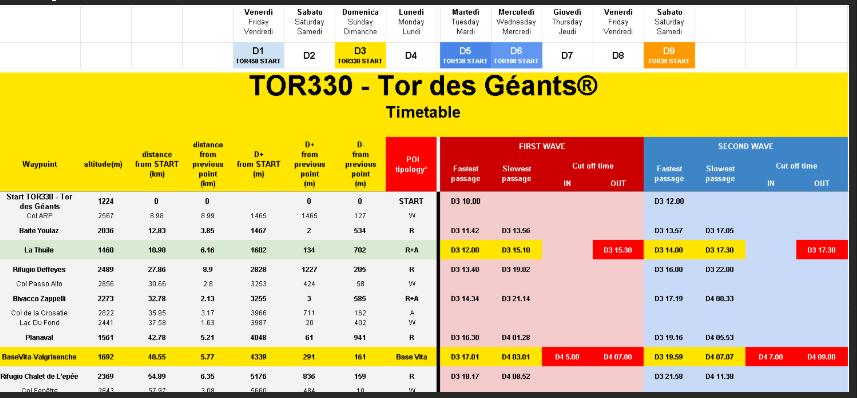


#### Stage Cutoffs
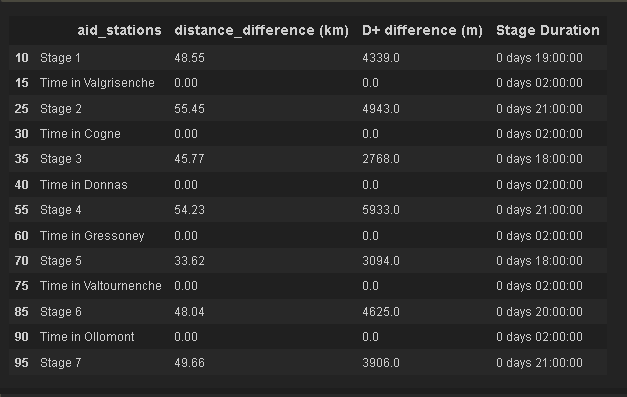

After cleaning the CSV and attaching dates instead of D1/ D2/ D3 etc, this is what the cut off talbe looks like:

#### Dates Cutoffs
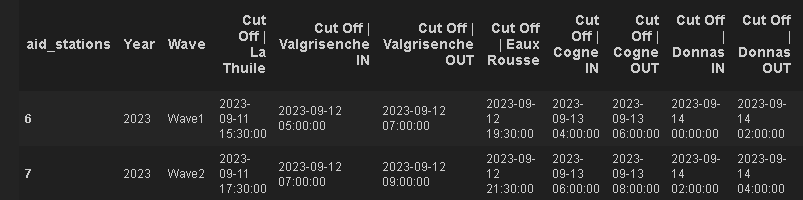

In [104]:
stages_cut_offs_df = pd.read_excel(f'{race} Data/4. TOR330 Timetable Data/{race}_stages_cut_offs_df.xlsx')
stages_cut_offs_df['stage']  = stages_cut_offs_df['stage'] + ' Time'
stages_cut_offs_df

,Checkpoint,distance_difference (km),D+ difference (m),Wave1,Stage Duration,stage
0,Valgrisenche IN,48.55,4339,2023-09-11 05:00:00,0.791667,Stage 1 Time
1,Valgrisenche OUT,0.00,0,2023-09-11 07:00:00,0.083333,Time in Valgrisenche Time
2,Cogne IN,55.45,4943,2023-09-12 04:00:00,0.875000,Stage 2 Time
3,Cogne OUT,0.00,0,2023-09-12 06:00:00,0.083333,Time in Cogne Time
4,Donnas IN,45.77,2768,2023-09-13 00:00:00,0.750000,Stage 3 Time
5,Donnas OUT,0.00,0,2023-09-13 02:00:00,0.083333,Time in Donnas Time
6,Gressoney IN,54.23,5933,2023-09-13 23:00:00,0.875000,Stage 4 Time
7,Gressoney OUT,0.00,0,2023-09-14 01:00:00,0.083333,Time in Gressoney Time
8,Valtournenche IN,33.62,3094,2023-09-14 19:00:00,0.750000,Stage 5 Time
9,Valtournenche OUT,0.00,0,2023-09-14 21:00:00,0.083333,Time in Valtournenche Time


In [105]:
cutoffs_df_pivot = pd.read_excel(f'{race} Data/4. TOR330 Timetable Data/{race}_aid_station_for_each_year_cut_offs_df.xlsx')
cutoffs_df_pivot['Year'] = cutoffs_df_pivot['Year'].astype('str')
cutoffs_df_pivot = cutoffs_df_pivot[cutoffs_df_pivot['Year'] == f'{year}']
cutoffs_df_pivot


,Checkpoint,Year,Wave,Cut Off Date
0,Start,2023,Wave1,2023-09-10 10:00:00
5,La Thuile,2023,Wave1,2023-09-10 15:30:00
10,Valgrisenche IN,2023,Wave1,2023-09-11 05:00:00
15,Valgrisenche OUT,2023,Wave1,2023-09-11 07:00:00
20,Eaux Rousse,2023,Wave1,2023-09-11 19:30:00
25,Cogne IN,2023,Wave1,2023-09-12 04:00:00
30,Cogne OUT,2023,Wave1,2023-09-12 06:00:00
35,Donnas IN,2023,Wave1,2023-09-13 00:00:00
40,Donnas OUT,2023,Wave1,2023-09-13 02:00:00
45,Rifugio della Barma,2023,Wave1,2023-09-13 13:00:00


### Did anyone who finished the race missed the cut off?

In [106]:
# bib1440 = melt_checkpoints_TOR33_df[melt_checkpoints_TOR33_df['Bib'] == 1440]
# fifty = melt_checkpoints_TOR33_df
# for aid_station in cutoffs_df_melt['aid_stations'].unique():
    
#     for wave in ['Wave1', 'Wave2']:
#         cut_off_for_checkpoint = cutoffs_df_melt['Date'][(cutoffs_df_melt['aid_stations'] == aid_station) &
#                                                          (cutoffs_df_melt['Wave'] == wave) &
#                                                          (cutoffs_df_melt['Year'] == year)].values[0]
        
        
#         df = fifty[(fifty['Checkpoint'] == aid_station) &
#               (fifty['Wave'] == wave) &
#               (fifty['Year'] == year)]
        
# #         print(df ['Timestamp'])
#         print('\n', '*'*20 ,'\n', aid_station, wave, df.shape )
#             # Iterate over rows under the condition
#         for idx, row in df.iterrows():
#             # iterrate over the rows of 
#             if 'IN' in aid_station or ' OUT' in aid_station:
#                 new_aid_station = aid_station.split('')
#                 print(new_aid_station)
#                 df['Missed'] = np.where( cut_off_for_checkpoint - df [''] < pd.to_timedelta('00:00:00'),
#                                              f'Missed cutoff at {aid_station}' ,
#                                              np.nan)           
#             else:
#                 row['Missed'] = np.where( cut_off_for_checkpoint - row['Timestamp'] < pd.to_timedelta('00:00:00'),
#                                              f'Missed cutoff at {aid_station}' ,
#                                              np.nan)
#         print(df.groupby(['Missed'])['Missed'].count())
        
# # fifty ['Missed'].unique()

### Looking for the Polish Fella!

When I ran TOR 2023, I distingly remember running into a Polish fella as I was leaving Gressoney. I was hiking with him from Rifugio Barma, he was in Wave 1. I remember running up to him at the lifebase, all excited "Hey, you made it!"

The reply I recieved was "WHat are you talking about? I missed the cutoff"

So I began looking for him to find out why I dont have more people who missed the cut off!

Here I am leaving Gressoney!

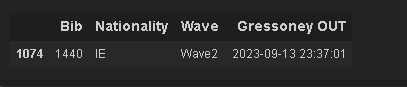

This is the cut off times
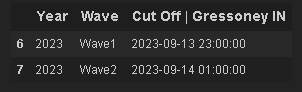

I looked for all the Poles that DNFed the race

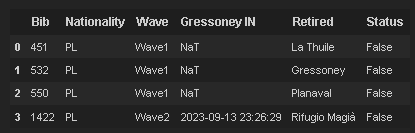

It is clear that he DNFed at 'Gressoney OUT - RITIRIO' 
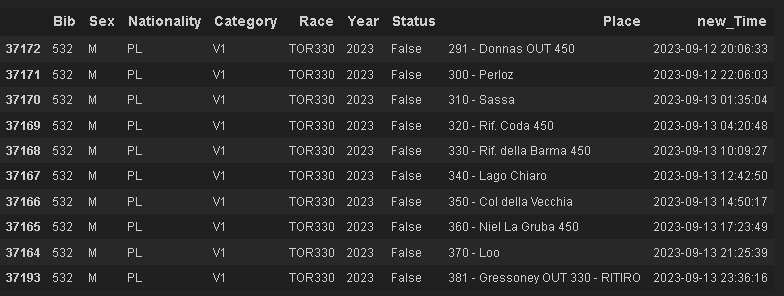
This is what is causing my heartache!



### SOLUTION
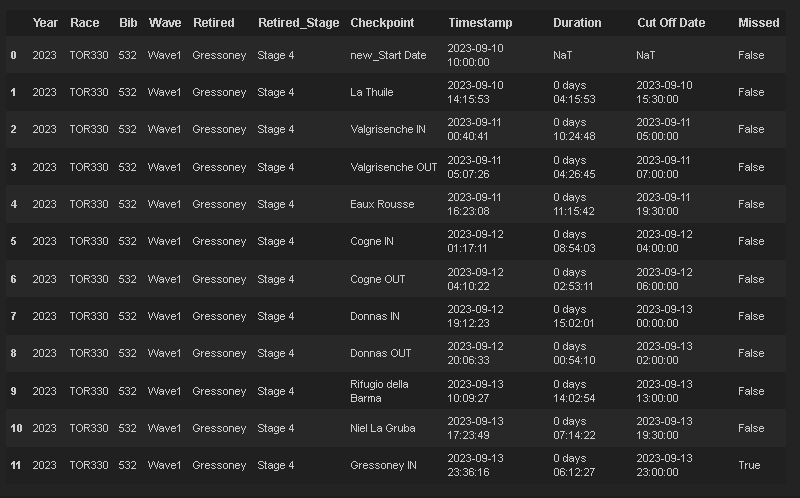


In [206]:
pivoted_TOR330_dates[['Bib','Nationality','Wave', 'Gressoney IN','Retired', 'Status']][
    (pivoted_TOR330_dates['Nationality'] == 'PL') &
    (pivoted_TOR330_dates_DNF['Status'] == False)].reset_index(drop = True)   

C:\Users\Karina\AppData\Local\Temp\ipykernel_7752\3548030829.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pivoted_TOR330_dates[['Bib','Nationality','Wave', 'Gressoney IN','Retired', 'Status']][


,Bib,Nationality,Wave,Gressoney IN,Retired,Status
0,451,PL,Wave1,NaT,La Thuile,False
1,532,PL,Wave1,NaT,Gressoney,False
2,550,PL,Wave1,NaT,Planaval,False
3,1422,PL,Wave2,2023-09-13 23:26:29,Rifugio Magià,False


In [108]:
pivoted_TOR330_dates[[ 'Bib', 'Nationality','Wave', 'Gressoney OUT', 'Status']][
    pivoted_TOR330_dates['Bib'] == 1440]

,Bib,Nationality,Wave,Gressoney OUT,Status
1074,1440,IE,Wave2,2023-09-13 23:37:01,True


In [109]:
# Pivot the data so that each participant has its own column
polish532 =  TOR330[['Bib', 'Race','Year', 'Status' , 'Place', 'new_Time'
          ]][TOR330['Bib'] == 532].reset_index(drop = True)


polish532.sort_values(by= 'new_Time', ascending = True)[-10:]

,Bib,Race,Year,Status,Place,new_Time
8,532,TOR330,2023,False,291 - Donnas OUT 450,2023-09-12 20:06:33
7,532,TOR330,2023,False,300 - Perloz,2023-09-12 22:06:03
6,532,TOR330,2023,False,310 - Sassa,2023-09-13 01:35:04
5,532,TOR330,2023,False,320 - Rif. Coda 450,2023-09-13 04:20:48
4,532,TOR330,2023,False,330 - Rif. della Barma 450,2023-09-13 10:09:27
3,532,TOR330,2023,False,340 - Lago Chiaro,2023-09-13 12:42:50
2,532,TOR330,2023,False,350 - Col della Vecchia,2023-09-13 14:50:17
1,532,TOR330,2023,False,360 - Niel La Gruba 450,2023-09-13 17:23:49
0,532,TOR330,2023,False,370 - Loo,2023-09-13 21:25:39
29,532,TOR330,2023,False,381 - Gressoney OUT 330 - RITIRO,2023-09-13 23:36:16


#### RITIRIO

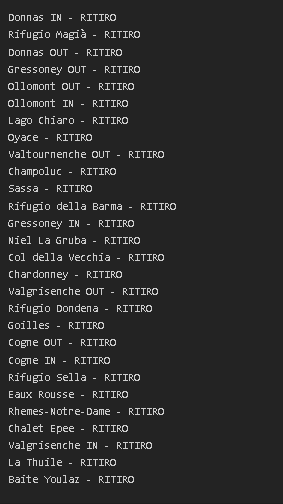



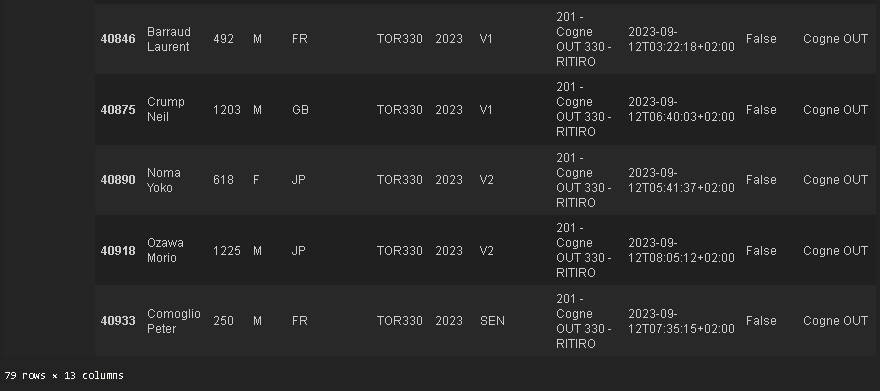

In [110]:
# Pattern to match "OUT Number - RITIRO"
pattern = r'OUT \d+ - RITIRO'

TOR330[TOR330['Place'].str.contains(pattern, na=False)].reset_index(drop = True)

,Name,Bib,Sex,Nationality,Race,Year,Category,Place,Time,Status,aid_stations,RITIRIO,new_Time
0,Smith Jonathan,1321,M,AU,TOR330,2023,V2,291 - Donnas OUT 450 - RITIRO,2023-09-12T17:18:56+02:00,True,Donnas OUT,Donnas OUT - RITIRO,2023-09-12 17:18:56
1,Houteer Magni Justine,275,F,FR,TOR330,2023,V1,381 - Gressoney OUT 330 - RITIRO,2023-09-14T01:33:04+02:00,True,Gressoney OUT,Gressoney OUT - RITIRO,2023-09-14 01:33:04
2,Delafond Sandra,1560,F,FR,TOR330,2023,V1,291 - Donnas OUT 450 - RITIRO,2023-09-13T03:44:36+02:00,False,Donnas OUT,Donnas OUT - RITIRO,2023-09-13 03:44:36
3,Compan Jean Philippe,1403,M,FR,TOR330,2023,V1,291 - Donnas OUT 450 - RITIRO,2023-09-13T03:44:00+02:00,False,Donnas OUT,Donnas OUT - RITIRO,2023-09-13 03:44:00
4,Pang Kin Sun,610,M,HK,TOR330,2023,V2,581 - Ollomont OUT 330 - RITIRO,2023-09-15T11:34:58+02:00,False,Ollomont OUT,Ollomont OUT - RITIRO,2023-09-15 11:34:58
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,Barraud Laurent,492,M,FR,TOR330,2023,V1,201 - Cogne OUT 330 - RITIRO,2023-09-12T03:22:18+02:00,False,Cogne OUT,Cogne OUT - RITIRO,2023-09-12 03:22:18
75,Crump Neil,1203,M,GB,TOR330,2023,V1,201 - Cogne OUT 330 - RITIRO,2023-09-12T06:40:03+02:00,False,Cogne OUT,Cogne OUT - RITIRO,2023-09-12 06:40:03
76,Noma Yoko,618,F,JP,TOR330,2023,V2,201 - Cogne OUT 330 - RITIRO,2023-09-12T05:41:37+02:00,False,Cogne OUT,Cogne OUT - RITIRO,2023-09-12 05:41:37
77,Ozawa Morio,1225,M,JP,TOR330,2023,V2,201 - Cogne OUT 330 - RITIRO,2023-09-12T08:05:12+02:00,False,Cogne OUT,Cogne OUT - RITIRO,2023-09-12 08:05:12


In [111]:
for i in TOR330['RITIRIO'].unique():
    print(i)


Donnas IN - RITIRO
Rifugio Magià - RITIRO
Donnas OUT - RITIRO
Gressoney OUT - RITIRO
Ollomont OUT - RITIRO
Ollomont IN - RITIRO
Lago Chiaro - RITIRO
Oyace - RITIRO
Valtournenche OUT - RITIRO
Champoluc - RITIRO
Sassa - RITIRO
Rifugio della Barma - RITIRO
Gressoney IN - RITIRO
Niel La Gruba - RITIRO
Col della Vecchia - RITIRO
Chardonney - RITIRO
Valgrisenche OUT - RITIRO
Rifugio Dondena - RITIRO
Goilles - RITIRO
Cogne OUT - RITIRO
Cogne IN - RITIRO
Rifugio Sella - RITIRO
Eaux Rousse - RITIRO
Rhemes-Notre-Dame - RITIRO
Chalet Epee - RITIRO
Valgrisenche IN - RITIRO
La Thuile - RITIRO
Baite Youlaz - RITIRO


In [229]:
# Examining only finishers
TORX_list = []
n=0
for unique_bib in melt_checkpoints_TOR330_df['Bib'].unique():

    # Filter the dataframe for the current unique_bib
    bib_df = melt_checkpoints_TOR330_df[melt_checkpoints_TOR330_df['Bib'] == unique_bib]
#     print(unique_bib, bib_df['Retired'].values[0])

    retired_location = TOR330_dem['Retired'][TOR330_dem['Bib'] == unique_bib].values[0]
    print(f"Processing Bib: {unique_bib}, Retired Location: {retired_location}")
    
    if retired_location == np.nan:

        # Merge with the cutoffs dataframe
        bib_df = bib_df.merge(
            cutoffs_df_pivot,
            on=['Checkpoint', 'Wave', 'Year'],
            how='left')
    
        n = n+1
        print(n)
        
        bib_df['Duration'] = bib_df['Timestamp'].diff()
    

        # Iterate over the rows to process the data
        for idx, row in bib_df.iterrows():
            # Check if 'Timestamp' is missing
            if pd.isna(row['Timestamp']):
                bib_df.at[idx, 'Missed'] = 'No Timestamp'
    #             print(f"Missing timestamp for Checkpoint: {row['Checkpoint']}")
            else:
    #             print(f"Checkpoint: {row['Checkpoint']}")
                # Compute the duration (example assumes 'Timestamp' is datetime)
                if idx > 0:  # To avoid accessing out of bounds
                    bib_df.at[idx, 'Duration'] = row['Timestamp'] - bib_df.at[idx - 1, 'Timestamp']
                # Compare 'Timestamp' with the cutoff
                bib_df.at[idx, 'Missed'] = row['Timestamp'] > row['Cut Off Date']
                bib_df.at[idx, 'Missed Diff'] = np.where(row['Timestamp'] > row['Cut Off Date'],
                                                        row['Timestamp'] - row['Cut Off Date'],
                                                        np.nan)

        # Print the final processed dataframe for the current 'Bib'
    #     print(bib_df)
        TORX_list.append(bib_df)
    
    # Dealing with DNFs
    else:
         pass


Processing Bib: 2, Retired Location: nan
Processing Bib: 662, Retired Location: nan
Processing Bib: 6, Retired Location: nan
Processing Bib: 20, Retired Location: nan
Processing Bib: 647, Retired Location: nan
Processing Bib: 615, Retired Location: nan
Processing Bib: 22, Retired Location: nan
Processing Bib: 8, Retired Location: nan
Processing Bib: 13, Retired Location: nan
Processing Bib: 17, Retired Location: nan
Processing Bib: 645, Retired Location: nan
Processing Bib: 663, Retired Location: nan
Processing Bib: 50, Retired Location: nan
Processing Bib: 31, Retired Location: nan
Processing Bib: 14, Retired Location: nan
Processing Bib: 15, Retired Location: nan
Processing Bib: 78, Retired Location: nan
Processing Bib: 64, Retired Location: nan
Processing Bib: 4, Retired Location: nan
Processing Bib: 92, Retired Location: nan
Processing Bib: 637, Retired Location: nan
Processing Bib: 73, Retired Location: nan
Processing Bib: 19, Retired Location: nan
Processing Bib: 11, Retired Loca

Processing Bib: 117, Retired Location: nan
Processing Bib: 385, Retired Location: nan
Processing Bib: 572, Retired Location: nan
Processing Bib: 520, Retired Location: nan
Processing Bib: 1012, Retired Location: nan
Processing Bib: 606, Retired Location: nan
Processing Bib: 151, Retired Location: nan
Processing Bib: 427, Retired Location: nan
Processing Bib: 1385, Retired Location: nan
Processing Bib: 324, Retired Location: nan
Processing Bib: 592, Retired Location: nan
Processing Bib: 1559, Retired Location: nan
Processing Bib: 1389, Retired Location: nan
Processing Bib: 181, Retired Location: nan
Processing Bib: 282, Retired Location: nan
Processing Bib: 384, Retired Location: nan
Processing Bib: 403, Retired Location: nan
Processing Bib: 1439, Retired Location: nan
Processing Bib: 340, Retired Location: nan
Processing Bib: 1376, Retired Location: nan
Processing Bib: 116, Retired Location: nan
Processing Bib: 1553, Retired Location: nan
Processing Bib: 1458, Retired Location: nan
Pro

Processing Bib: 543, Retired Location: nan
Processing Bib: 434, Retired Location: nan
Processing Bib: 218, Retired Location: nan
Processing Bib: 382, Retired Location: nan
Processing Bib: 249, Retired Location: nan
Processing Bib: 236, Retired Location: nan
Processing Bib: 501, Retired Location: nan
Processing Bib: 193, Retired Location: nan
Processing Bib: 389, Retired Location: nan
Processing Bib: 1134, Retired Location: nan
Processing Bib: 1374, Retired Location: nan
Processing Bib: 443, Retired Location: nan
Processing Bib: 1051, Retired Location: nan
Processing Bib: 430, Retired Location: nan
Processing Bib: 422, Retired Location: nan
Processing Bib: 468, Retired Location: nan
Processing Bib: 547, Retired Location: nan
Processing Bib: 489, Retired Location: nan
Processing Bib: 1083, Retired Location: nan
Processing Bib: 235, Retired Location: nan
Processing Bib: 1446, Retired Location: nan
Processing Bib: 513, Retired Location: nan
Processing Bib: 408, Retired Location: nan
Proces

Processing Bib: 113, Retired Location: Bruson Arp
Processing Bib: 114, Retired Location: new_Start Date
Processing Bib: 118, Retired Location: new_Start Date
Processing Bib: 120, Retired Location: new_Start Date
Processing Bib: 124, Retired Location: Valgrisenche
Processing Bib: 126, Retired Location: new_Start Date
Processing Bib: 127, Retired Location: Perloz
Processing Bib: 145, Retired Location: new_Start Date
Processing Bib: 160, Retired Location: Donnas
Processing Bib: 164, Retired Location: new_Start Date
Processing Bib: 172, Retired Location: Gressoney
Processing Bib: 179, Retired Location: Planaval
Processing Bib: 180, Retired Location: Valgrisenche
Processing Bib: 185, Retired Location: new_Start Date
Processing Bib: 186, Retired Location: Gressoney
Processing Bib: 188, Retired Location: Chalet Epee
Processing Bib: 194, Retired Location: Rifugio Dondena
Processing Bib: 198, Retired Location: Valgrisenche
Processing Bib: 201, Retired Location: Eaux Rousse
Processing Bib: 202, 

Processing Bib: 587, Retired Location: Ollomont
Processing Bib: 589, Retired Location: Rhemes-Notre-Dame
Processing Bib: 590, Retired Location: Valgrisenche
Processing Bib: 591, Retired Location: Perloz
Processing Bib: 595, Retired Location: Col della Vecchia
Processing Bib: 597, Retired Location: Valgrisenche
Processing Bib: 600, Retired Location: Rhemes-Notre-Dame
Processing Bib: 601, Retired Location: Pontboset
Processing Bib: 603, Retired Location: Gressoney
Processing Bib: 605, Retired Location: Donnas
Processing Bib: 607, Retired Location: Valtournenche
Processing Bib: 608, Retired Location: new_Start Date
Processing Bib: 610, Retired Location: Ollomont
Processing Bib: 612, Retired Location: Rhemes-Notre-Dame
Processing Bib: 613, Retired Location: Lago Chiaro
Processing Bib: 614, Retired Location: Lago Chiaro
Processing Bib: 617, Retired Location: Niel La Gruba
Processing Bib: 618, Retired Location: Cogne
Processing Bib: 619, Retired Location: Cogne
Processing Bib: 620, Retired L

Processing Bib: 1243, Retired Location: new_Start Date
Processing Bib: 1244, Retired Location: La Thuile
Processing Bib: 1245, Retired Location: Rhemes-Notre-Dame
Processing Bib: 1246, Retired Location: Eaux Rousse
Processing Bib: 1247, Retired Location: new_Start Date
Processing Bib: 1249, Retired Location: Eaux Rousse
Processing Bib: 1250, Retired Location: Niel La Gruba
Processing Bib: 1253, Retired Location: new_Start Date
Processing Bib: 1254, Retired Location: Eaux Rousse
Processing Bib: 1256, Retired Location: La Thuile
Processing Bib: 1257, Retired Location: Rifugio Coda
Processing Bib: 1259, Retired Location: Loo
Processing Bib: 1260, Retired Location: new_Start Date
Processing Bib: 1262, Retired Location: La Thuile
Processing Bib: 1264, Retired Location: Rifugio della Barma
Processing Bib: 1265, Retired Location: new_Start Date
Processing Bib: 1266, Retired Location: Col della Vecchia
Processing Bib: 1269, Retired Location: Rhemes-Notre-Dame
Processing Bib: 1270, Retired Loca

Processing Bib: 1574, Retired Location: Eaux Rousse


In [113]:
# Combine all processed dataframes into one
TORX_df = pd.concat(TORX_list, ignore_index=True)

# Print the final combined dataframe
print(TORX_df)

       Year    Race  Bib   Wave Retired Retired_Stage         Checkpoint  \
0      2023  TOR330    2  Wave1     NaN           NaN     new_Start Date   
1      2023  TOR330    2  Wave1     NaN           NaN          La Thuile   
2      2023  TOR330    2  Wave1     NaN           NaN    Valgrisenche IN   
3      2023  TOR330    2  Wave1     NaN           NaN   Valgrisenche OUT   
4      2023  TOR330    2  Wave1     NaN           NaN        Eaux Rousse   
...     ...     ...  ...    ...     ...           ...                ...   
12435  2023  TOR330  533  Wave1     NaN           NaN  Valtournenche OUT   
12436  2023  TOR330  533  Wave1     NaN           NaN              Oyace   
12437  2023  TOR330  533  Wave1     NaN           NaN        Ollomont IN   
12438  2023  TOR330  533  Wave1     NaN           NaN       Ollomont OUT   
12439  2023  TOR330  533  Wave1     NaN           NaN             FINISH   

                Timestamp        Cut Off Date        Duration Missed  \
0     2023-09-1

#### Which Finishers missed a cut off?

In [114]:
TORX_df[
    # everyone who finished
    (TORX_df['Retired'].isna()) &
    # missed the cut off but finished
    (TORX_df['Missed'] == True)]

,Year,Race,Bib,Wave,Retired,Retired_Stage,Checkpoint,Timestamp,Cut Off Date,Duration,Missed,Missed Diff
2721,2023,TOR330,89,Wave1,NaN,NaN,La Thuile,2023-09-10 15:59:50,2023-09-10 15:30:00,0 days 05:59:50,True,0 days 00:29:50
7792,2023,TOR330,1536,Wave2,NaN,NaN,Gressoney OUT,2023-09-14 03:02:33,2023-09-14 03:00:00,0 days 09:51:18,True,0 days 00:02:33
8832,2023,TOR330,486,Wave1,NaN,NaN,Gressoney OUT,2023-09-14 01:07:06,2023-09-14 01:00:00,0 days 04:42:12,True,0 days 00:07:06
9821,2023,TOR330,1001,Wave1,NaN,NaN,La Thuile,2023-09-10 15:31:19,2023-09-10 15:30:00,0 days 03:31:19,True,0 days 00:01:19
11236,2023,TOR330,1311,Wave2,NaN,NaN,Oyace,2023-09-15 14:03:35,2023-09-15 14:00:00,0 days 18:26:57,True,0 days 00:03:35
12338,2023,TOR330,290,Wave1,NaN,NaN,Ollomont OUT,2023-09-15 19:00:42,2023-09-15 19:00:00,0 days 02:39:04,True,0 days 00:00:42
12396,2023,TOR330,190,Wave1,NaN,NaN,Oyace,2023-09-15 12:50:39,2023-09-15 12:00:00,0 days 17:33:57,True,0 days 00:50:39
12419,2023,TOR330,1155,Wave2,NaN,NaN,FINISH,2023-09-16 20:05:50,2023-09-16 18:00:00,0 days 23:58:07,True,0 days 02:05:50
12439,2023,TOR330,533,Wave1,NaN,NaN,FINISH,2023-09-16 18:15:44,2023-09-16 16:00:00,1 days 00:27:53,True,0 days 02:15:44


#### Which DNFs missed the cut off

In [241]:
TORX_list = []
n = 0

# Filter unique Bibs where 'Retired' is not NaN
for unique_bib in list(melt_checkpoints_TOR330_df['Bib'][~(melt_checkpoints_TOR330_df['Retired'].isna())
                                                        ].unique()):
    # Filter the dataframe for the current unique_bib
    bib_df = melt_checkpoints_TOR330_df[melt_checkpoints_TOR330_df['Bib'] == unique_bib]

############################################################
    # Group by 'Bib' and find the last valid timestamp index
    last_valid_indices = bib_df[bib_df['Timestamp'].notna()].groupby('Bib').tail(1).index

    # Create a mask to filter out rows after the last valid timestamp for each 'Bib'
    mask = pd.Series(True, index=bib_df.index)
    for idx in last_valid_indices:
        bib = bib_df.at[idx, 'Bib']
        mask &= ~((bib_df['Bib'] == bib) & (bib_df.index > idx) & bib_df['Timestamp'].isna())

    # Apply the mask to filter the DataFrame
    bib_df = bib_df[mask]
    bib_df = bib_df.reset_index(drop = True)

# ############################################################
# FIxing the Polish fella issue!
    
    retired_location = TOR330_dem['Retired'][TOR330_dem['Bib'] == unique_bib].values[0]
    print(f"Processing Bib: {unique_bib}, Retired Location: {retired_location}")

    # Iterate over the rows to process the data
    for idx, row in bib_df.iterrows():
        checkpoint = row['Checkpoint']
                    
        ############ FIXING THE POLISH MAN 532 issue!
        if retired_location in checkpoint:
            # Check if the checkpoint does not contain 'OUT' or 'IN'
            if 'OUT' in  checkpoint or 'IN' in checkpoint:
#                 print('I am working on it!!!!')
                # Extract the matching cutoff row
                single_cutoffs_df_pivot = cutoffs_df_pivot[cutoffs_df_pivot['Checkpoint'] == checkpoint]
            

                # If the checkpoint is retired_location + 'IN' and Timestamp is NaN
                if checkpoint == f"{retired_location} IN" and pd.isna(row['Timestamp']):
                    print(checkpoint)
                    # Locate the 'OUT' checkpoint row
                    out_row = bib_df[bib_df['Checkpoint'] == f"{retired_location} OUT"]
                    print(out_row)
                    if not out_row.empty:
                        
                        # Make next checkpoint down Nan
                        bib_df.at[idx +1, 'Checkpoint'] =  np.nan
                        # Make the next Timestamp Nan
                        bib_df.at[idx +1, 'Timestamp'] = pd.NaT
                        
                                                # Use the Timestamp from 'OUT'
                        bib_df.at[idx, 'Timestamp'] = out_row['Timestamp'].values[0]
                        
                        
                        bib_df.at[idx, 'Missed Last Checkpoint'] = np.where(
                                bib_df.at[idx,'Timestamp'] > single_cutoffs_df_pivot['Cut Off Date'],
                                True,
                                False
                            )
                        bib_df.at[idx, 'Missed Last Checkpoint'] = True
                        
                        # Check if the last row contains NaT in the 'Timestamp' column
                        if pd.isna(bib_df.loc[bib_df.index[-1], 'Timestamp']):
                            # Drop the last row
                            bib_df = bib_df.iloc[:-1]
    bib_df['Duration'] = bib_df['Timestamp'].diff()
             
    # Append the processed DataFrame to the list
    TORX_list.append(bib_df)
    n += 1
    print(f"Processed {n} Bib(s).", unique_bib)

# Combine all results into one DataFrame
if TORX_list:
    final_df = pd.concat(TORX_list, ignore_index=True)
    print("Combined DataFrame created.")
else:
    final_df = pd.DataFrame()
    print("No DataFrames were processed.")

    

# Merge single row cutoffs with current row data
final_df = final_df.merge(
    cutoffs_df_pivot,
    on=['Checkpoint', 'Wave', 'Year'],
    how='left')

# Compare 'Timestamp' with the cutoff
final_df['Missed'] = final_df['Timestamp'] >   final_df['Cut Off Date']
final_df['Missed Diff'] = np.where(
    final_df['Timestamp'] > final_df['Cut Off Date'],
    final_df['Timestamp'] - final_df['Cut Off Date'],
    pd.NaT  # Ensure missing values are compatible with timedelta64
)

# Explicitly cast 'Missed Diff' to timedelta64[ns] to enforce the type
final_df['Missed Diff'] = final_df['Missed Diff'].astype('timedelta64[ns]')


final_df

Processing Bib: 1, Retired Location: new_Start Date
Processed 1 Bib(s). 1
Processing Bib: 3, Retired Location: new_Start Date
Processed 2 Bib(s). 3
Processing Bib: 5, Retired Location: Chardonney
Processed 3 Bib(s). 5
Processing Bib: 7, Retired Location: Eaux Rousse
Processed 4 Bib(s). 7
Processing Bib: 9, Retired Location: new_Start Date
Processed 5 Bib(s). 9
Processing Bib: 10, Retired Location: Gressoney
Processed 6 Bib(s). 10
Processing Bib: 12, Retired Location: Perloz
Processed 7 Bib(s). 12
Processing Bib: 16, Retired Location: Oyace
Processed 8 Bib(s). 16
Processing Bib: 21, Retired Location: Eaux Rousse
Processed 9 Bib(s). 21
Processing Bib: 24, Retired Location: Sassa
Processed 10 Bib(s). 24
Processing Bib: 27, Retired Location: Rhemes-Notre-Dame
Processed 11 Bib(s). 27
Processing Bib: 30, Retired Location: Gressoney
Processed 12 Bib(s). 30
Processing Bib: 32, Retired Location: Rifugio Magià
Processed 13 Bib(s). 32
Processing Bib: 34, Retired Location: new_Start Date
Processed

Processing Bib: 304, Retired Location: Cogne
Processed 99 Bib(s). 304
Processing Bib: 305, Retired Location: Ponteille Desot
Processed 100 Bib(s). 305
Processing Bib: 309, Retired Location: Gressoney
Processed 101 Bib(s). 309
Processing Bib: 312, Retired Location: Valgrisenche
Processed 102 Bib(s). 312
Processing Bib: 320, Retired Location: new_Start Date
Processed 103 Bib(s). 320
Processing Bib: 321, Retired Location: Ollomont
Ollomont IN
    Year    Race  Bib   Wave   Retired Retired_Stage    Checkpoint  \
18  2023  TOR330  321  Wave1  Ollomont       Stage 6  Ollomont OUT   

             Timestamp  
18 2023-09-15 18:39:01  
Processed 104 Bib(s). 321
Processing Bib: 322, Retired Location: Rifugio Dondena
Processed 105 Bib(s). 322
Processing Bib: 323, Retired Location: Champoluc
Processed 106 Bib(s). 323
Processing Bib: 326, Retired Location: Rifugio della Barma
Processed 107 Bib(s). 326
Processing Bib: 327, Retired Location: Champoluc
Processed 108 Bib(s). 327
Processing Bib: 331, Re

Processing Bib: 550, Retired Location: Planaval
Processed 189 Bib(s). 550
Processing Bib: 553, Retired Location: Niel La Gruba
Processed 190 Bib(s). 553
Processing Bib: 554, Retired Location: Niel La Gruba
Processed 191 Bib(s). 554
Processing Bib: 555, Retired Location: new_Start Date
Processed 192 Bib(s). 555
Processing Bib: 557, Retired Location: Bosses
Processed 193 Bib(s). 557
Processing Bib: 558, Retired Location: Gressoney
Processed 194 Bib(s). 558
Processing Bib: 559, Retired Location: Bosses
Processed 195 Bib(s). 559
Processing Bib: 561, Retired Location: Chalet Epee
Processed 196 Bib(s). 561
Processing Bib: 564, Retired Location: Oyace
Processed 197 Bib(s). 564
Processing Bib: 566, Retired Location: Rifugio Grand Tournalin
Processed 198 Bib(s). 566
Processing Bib: 568, Retired Location: Valgrisenche
Processed 199 Bib(s). 568
Processing Bib: 571, Retired Location: Rifugio Magià
Processed 200 Bib(s). 571
Processing Bib: 574, Retired Location: Valgrisenche
Processed 201 Bib(s). 5

Processing Bib: 1066, Retired Location: Cogne
Processed 279 Bib(s). 1066
Processing Bib: 1069, Retired Location: Lago Chiaro
Processed 280 Bib(s). 1069
Processing Bib: 1070, Retired Location: Gressoney
Gressoney IN
    Year    Race   Bib   Wave    Retired Retired_Stage     Checkpoint  \
12  2023  TOR330  1070  Wave2  Gressoney       Stage 4  Gressoney OUT   

             Timestamp  
12 2023-09-13 14:36:49  
Processed 281 Bib(s). 1070
Processing Bib: 1071, Retired Location: Eaux Rousse
Processed 282 Bib(s). 1071
Processing Bib: 1072, Retired Location: new_Start Date
Processed 283 Bib(s). 1072
Processing Bib: 1073, Retired Location: Valgrisenche
Processed 284 Bib(s). 1073
Processing Bib: 1075, Retired Location: Cogne
Processed 285 Bib(s). 1075
Processing Bib: 1076, Retired Location: Gressoney
Gressoney IN
    Year    Race   Bib   Wave    Retired Retired_Stage     Checkpoint  \
12  2023  TOR330  1076  Wave2  Gressoney       Stage 4  Gressoney OUT   

             Timestamp  
12 2023-09-1

Processing Bib: 1182, Retired Location: new_Start Date
Processed 356 Bib(s). 1182
Processing Bib: 1185, Retired Location: Sassa
Processed 357 Bib(s). 1185
Processing Bib: 1187, Retired Location: Valgrisenche
Processed 358 Bib(s). 1187
Processing Bib: 1188, Retired Location: new_Start Date
Processed 359 Bib(s). 1188
Processing Bib: 1189, Retired Location: Gressoney
Processed 360 Bib(s). 1189
Processing Bib: 1190, Retired Location: Eaux Rousse
Processed 361 Bib(s). 1190
Processing Bib: 1193, Retired Location: Eaux Rousse
Processed 362 Bib(s). 1193
Processing Bib: 1194, Retired Location: Perloz
Processed 363 Bib(s). 1194
Processing Bib: 1196, Retired Location: Perloz
Processed 364 Bib(s). 1196
Processing Bib: 1197, Retired Location: Gressoney
Gressoney IN
    Year    Race   Bib   Wave    Retired Retired_Stage     Checkpoint  \
12  2023  TOR330  1197  Wave2  Gressoney       Stage 4  Gressoney OUT   

             Timestamp  
12 2023-09-13 11:10:11  
Processed 365 Bib(s). 1197
Processing Bi

Processing Bib: 1297, Retired Location: Valgrisenche
Processed 439 Bib(s). 1297
Processing Bib: 1299, Retired Location: Gressoney
Gressoney IN
    Year    Race   Bib   Wave    Retired Retired_Stage     Checkpoint  \
12  2023  TOR330  1299  Wave2  Gressoney       Stage 4  Gressoney OUT   

             Timestamp  
12 2023-09-14 02:27:55  
Processed 440 Bib(s). 1299
Processing Bib: 1301, Retired Location: Gressoney
Gressoney IN
    Year    Race   Bib   Wave    Retired Retired_Stage     Checkpoint  \
12  2023  TOR330  1301  Wave2  Gressoney       Stage 4  Gressoney OUT   

             Timestamp  
12 2023-09-13 18:36:29  
Processed 441 Bib(s). 1301
Processing Bib: 1307, Retired Location: Valgrisenche
Processed 442 Bib(s). 1307
Processing Bib: 1308, Retired Location: La Thuile
Processed 443 Bib(s). 1308
Processing Bib: 1310, Retired Location: new_Start Date
Processed 444 Bib(s). 1310
Processing Bib: 1314, Retired Location: new_Start Date
Processed 445 Bib(s). 1314
Processing Bib: 1315, Ret

    Year    Race   Bib   Wave    Retired Retired_Stage     Checkpoint  \
12  2023  TOR330  1468  Wave2  Gressoney       Stage 4  Gressoney OUT   

             Timestamp  
12 2023-09-14 00:37:29  
Processed 537 Bib(s). 1468
Processing Bib: 1470, Retired Location: Vareton
Processed 538 Bib(s). 1470
Processing Bib: 1473, Retired Location: Rifugio Sella
Processed 539 Bib(s). 1473
Processing Bib: 1478, Retired Location: Rhemes-Notre-Dame
Processed 540 Bib(s). 1478
Processing Bib: 1479, Retired Location: Rifugio Deffeyes
Processed 541 Bib(s). 1479
Processing Bib: 1481, Retired Location: Gressoney
Gressoney IN
    Year    Race   Bib   Wave    Retired Retired_Stage     Checkpoint  \
12  2023  TOR330  1481  Wave2  Gressoney       Stage 4  Gressoney OUT   

             Timestamp  
12 2023-09-13 07:28:30  
Processed 542 Bib(s). 1481
Processing Bib: 1482, Retired Location: Eaux Rousse
Processed 543 Bib(s). 1482
Processing Bib: 1483, Retired Location: Eaux Rousse
Processed 544 Bib(s). 1483
Proces

,Year,Race,Bib,Wave,Retired,Retired_Stage,Checkpoint,Timestamp,Duration,Missed Last Checkpoint,Cut Off Date,Missed,Missed Diff
0,2023,TOR330,1,Wave1,new_Start Date,DNS,new_Start Date,2023-09-10 10:00:00,NaT,NaN,NaT,False,NaT
1,2023,TOR330,3,Wave1,new_Start Date,DNS,new_Start Date,2023-09-10 10:00:00,NaT,NaN,NaT,False,NaT
2,2023,TOR330,5,Wave1,Chardonney,Stage 3,new_Start Date,2023-09-10 10:00:00,NaT,NaN,NaT,False,NaT
3,2023,TOR330,5,Wave1,Chardonney,Stage 3,La Thuile,2023-09-10 12:20:48,0 days 02:20:48,NaN,2023-09-10 15:30:00,False,NaT
4,2023,TOR330,5,Wave1,Chardonney,Stage 3,Valgrisenche IN,2023-09-10 17:05:39,0 days 04:44:51,NaN,2023-09-11 05:00:00,False,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3913,2023,TOR330,1574,Wave2,Eaux Rousse,Stage 2,new_Start Date,2023-09-10 12:00:00,NaT,NaN,NaT,False,NaT
3914,2023,TOR330,1574,Wave2,Eaux Rousse,Stage 2,La Thuile,2023-09-10 16:17:20,0 days 04:17:20,NaN,2023-09-10 17:30:00,False,NaT
3915,2023,TOR330,1574,Wave2,Eaux Rousse,Stage 2,Valgrisenche IN,2023-09-11 01:05:59,0 days 08:48:39,NaN,2023-09-11 07:00:00,False,NaT
3916,2023,TOR330,1574,Wave2,Eaux Rousse,Stage 2,Valgrisenche OUT,2023-09-11 02:50:42,0 days 01:44:43,NaN,2023-09-11 09:00:00,False,NaT


In [242]:
final_df[~(final_df['Missed Last Checkpoint'].isna())].groupby('Retired')['Missed Last Checkpoint'].count()

Retired
Cogne             2
Donnas            4
Gressoney        35
Ollomont          3
Valtournenche     3
Name: Missed Last Checkpoint, dtype: int64

In [243]:
final_df[~(final_df['Missed Last Checkpoint'].isna())].groupby('Retired')['Missed Diff'].describe()

,count,mean,std,min,25%,50%,75%,max
Retired,,,,,,,,
Cogne,2,0 days 01:22:37.500000,0 days 01:00:12.608545082,0 days 00:40:03,0 days 01:01:20.250000,0 days 01:22:37.500000,0 days 01:43:54.750000,0 days 02:05:12
Donnas,0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
Gressoney,20,0 days 01:27:48.300000,0 days 01:00:17.969321390,0 days 00:08:01,0 days 00:40:39.250000,0 days 01:12:59.500000,0 days 02:00:29.500000,0 days 03:19:30
Ollomont,2,0 days 02:01:40.500000,0 days 00:32:02.623338046,0 days 01:39:01,0 days 01:50:20.750000,0 days 02:01:40.500000,0 days 02:13:00.250000,0 days 02:24:20
Valtournenche,0,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [244]:
final_df[
    ~(final_df['Missed Last Checkpoint'].isna()) &
    (final_df['Retired'] == 'Valtournenche')]

,Year,Race,Bib,Wave,Retired,Retired_Stage,Checkpoint,Timestamp,Duration,Missed Last Checkpoint,Cut Off Date,Missed,Missed Diff
888,2023,TOR330,409,Wave1,Valtournenche,Stage 5,Valtournenche IN,2023-09-13 19:03:33,0 days 06:43:14,True,2023-09-14 19:00:00,False,NaT
1137,2023,TOR330,514,Wave1,Valtournenche,Stage 5,Valtournenche IN,2023-09-14 15:17:14,0 days 07:46:16,True,2023-09-14 19:00:00,False,NaT
2827,2023,TOR330,1235,Wave2,Valtournenche,Stage 5,Valtournenche IN,2023-09-14 12:02:42,NaT,True,2023-09-14 21:00:00,False,NaT


In [230]:
# Examining only finishers
TORX_list = []
n=0
for unique_bib in melt_checkpoints_TOR330_df['Bib'].unique():

    # ############################################################
    # Filter the dataframe for the current unique_bib
    bib_df = melt_checkpoints_TOR330_df[melt_checkpoints_TOR330_df['Bib'] == unique_bib]

    retired_location = TOR330_dem['Retired'][TOR330_dem['Bib'] == unique_bib].values[0]
    print(f"Processing Bib: {unique_bib}, Retired Location: {retired_location}")
    
    # calculating differnce for everyone who has finished! :)
    if retired_location == np.nan:    
        bib_df['Duration'] = bib_df['Timestamp'].diff()

    # ###########################################################
    # working with DNFs
    elif retired_location != np.nan
        ############################################################
        # Group by 'Bib' and find the last valid timestamp index
        last_valid_indices = bib_df[bib_df['Timestamp'].notna()].groupby('Bib').tail(1).index

        # Create a mask to filter out rows after the last valid timestamp for each 'Bib'
        mask = pd.Series(True, index=bib_df.index)
        for idx in last_valid_indices:
            bib = bib_df.at[idx, 'Bib']
            mask &= ~((bib_df['Bib'] == bib) & (bib_df.index > idx) & bib_df['Timestamp'].isna())

        # Apply the mask to filter the DataFrame
        bib_df = bib_df[mask]
        bib_df = bib_df.reset_index(drop = True)

    # ############################################################
    # FIxing the Polish fella issue!

        # Iterate over the rows to process the data
        for idx, row in bib_df.iterrows():
            checkpoint = row['Checkpoint']

            ############ FIXING THE POLISH MAN 532 issue!
            if retired_location in checkpoint:
                # Check if the checkpoint does not contain 'OUT' or 'IN'
                if 'OUT' in  checkpoint or 'IN' in checkpoint:
    #                 print('I am working on it!!!!')
                    # Extract the matching cutoff row
                    single_cutoffs_df_pivot = cutoffs_df_pivot[cutoffs_df_pivot['Checkpoint'] == checkpoint]


                    # If the checkpoint is retired_location + 'IN' and Timestamp is NaN
                    if checkpoint == f"{retired_location} IN" and pd.isna(row['Timestamp']):
                        print(checkpoint)
                        # Locate the 'OUT' checkpoint row
                        out_row = bib_df[bib_df['Checkpoint'] == f"{retired_location} OUT"]
                        print(out_row)
                        if not out_row.empty:

                            # Make next checkpoint down Nan
                            bib_df.at[idx +1, 'Checkpoint'] =  np.nan
                            # Make the next Timestamp Nan
                            bib_df.at[idx +1, 'Timestamp'] = pd.NaT

                                                    # Use the Timestamp from 'OUT'
                            bib_df.at[idx, 'Timestamp'] = out_row['Timestamp'].values[0]
                            bib_df.at[idx, 'Missed Last Checkpoint'] = True

                            # Check if the last row contains NaT in the 'Timestamp' column
                            if pd.isna(bib_df.loc[bib_df.index[-1], 'Timestamp']):
                                # Drop the last row
                                bib_df = bib_df.iloc[:-1]
        bib_df['Duration'] = bib_df['Timestamp'].diff()
    else:
        print('Something went terribly wrong!')
             
    # Append the processed DataFrame to the list
    TORX_list.append(bib_df)
    n += 1
    print(f"Processed {n} Bib(s).", unique_bib)

# Combine all results into one DataFrame
if TORX_list:
    final_df = pd.concat(TORX_list, ignore_index=True)
    print("Combined DataFrame created.")
else:
    final_df = pd.DataFrame()
    print("No DataFrames were processed.")

    

# Merge single row cutoffs with current row data
final_df = final_df.merge(
    cutoffs_df_pivot,
    on=['Checkpoint', 'Wave', 'Year'],
    how='left')

# Compare 'Timestamp' with the cutoff
final_df['Missed'] = final_df['Timestamp'] >   final_df['Cut Off Date']
final_df['Missed Diff'] = np.where(
    final_df['Timestamp'] > final_df['Cut Off Date'],
    final_df['Timestamp'] - final_df['Cut Off Date'],
    pd.NaT  # Ensure missing values are compatible with timedelta64
)

# Explicitly cast 'Missed Diff' to timedelta64[ns] to enforce the type
final_df['Missed Diff'] = final_df['Missed Diff'].astype('timedelta64[ns]')


final_df

SyntaxError: invalid syntax (3427484160.py, line 18)